In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import numpy as np
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

2024-04-23 11:58:22.832575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


device is cuda:0


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.Sigmoid()

        # input: 100      
        self.fc1 = nn.Linear(in_features=100, out_features=128)    
        self.fc2 = nn.Linear(in_features=128, out_features=784)

        self.sig = nn.Sigmoid()


    
    def forward(self, x):
        x = self.fc1(x) #100->128
        x = self.act(x) #128->128
        x = self.fc2(x) #128->784
        x = self.sig(x) #784->784 (28x28)
        return x

class Generator_loss(nn.Module):
    def __init__(self):
        super(Generator_loss, self).__init__()

    def forward(self, output_fake):
        loss = -torch.log(output_fake)
        return loss.mean()
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.ReLU()

        # input: 784     
        self.fc1 = nn.Linear(in_features=784, out_features=128) 
        self.fc2 = nn.Linear(in_features=128, out_features=1)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x) #784->128
        x = self.act(x) #128->128
        x = self.fc2(x) #128->1
        x = self.sig(x) #1->1
        return x
    
class Discriminator_loss(nn.Module):
    def __init__(self):
        super(Discriminator_loss, self).__init__()

    def forward(self, output_real, output_fake):
        loss = -(torch.log(output_real)+torch.log(1-output_fake))
        return loss.mean()

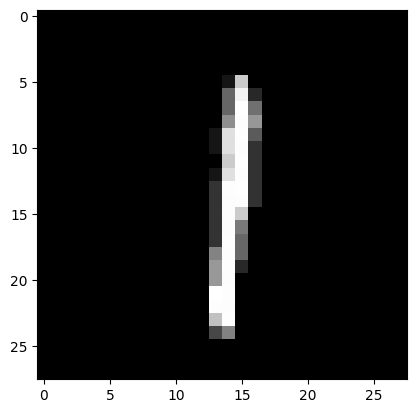

In [3]:
# Define the mini-batch size
batch_size = 100

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

# Dataset is split 8:2
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")

    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

In [4]:
def train_models(model_d, criterion_d, optimizer_d, scheduler_d, model_g, criterion_g, optimizer_g, scheduler_g, epochs, train_loader, k, batch_sz):
    it = iter(train_loader)
    for epoch in range(epochs):
          
        #Train Discriminator 
        for batch_nr in range(k):
            try:
                images,_ = next(it)
            except:
                it = iter(train_loader)
                images,_ = next(it)          
            out_real = model_d(torch.flatten(images,start_dim=1).to(device))
            out_fake = model_d(model_g(torch.rand(batch_sz,1,100).to(device)))
            optimizer_d.zero_grad()
            loss_d = criterion_d(out_real,out_fake).to(device)
            loss_d.backward()
            optimizer_d.step()
            scheduler_d.step()

        #Train Generator
        out_fake = model_d(model_g(torch.rand(batch_sz,1,100).to(device)))
        optimizer_g.zero_grad()
        loss_g = criterion_g(out_fake).to(device)
        loss_g.backward()
        optimizer_g.step()
        scheduler_g.step()
        
        disp = model_g(torch.rand(batch_sz,1,100).to(device))
        
        if epoch%50==0:
            print("Epoch:",epoch)  
            print("loss_g:",loss_g.item(),"\tloss_d:",loss_d.item())
        if epoch%500==0:
            plot_digit(torch.reshape(disp[0,0,:],(28,28)).detach().cpu())

Epoch: 0
loss_g: 0.898330569267273 	loss_d: 1.248359203338623


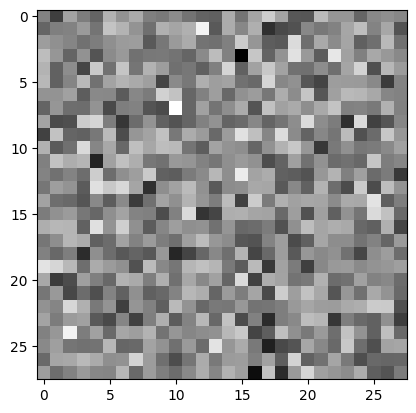

Epoch: 50
loss_g: 4.792316913604736 	loss_d: 0.04073018208146095
Epoch: 100
loss_g: 4.9647088050842285 	loss_d: 0.021906975656747818
Epoch: 150
loss_g: 4.5703229904174805 	loss_d: 0.03801749274134636
Epoch: 200
loss_g: 3.991950035095215 	loss_d: 0.06155407056212425
Epoch: 250
loss_g: 3.2971138954162598 	loss_d: 0.13811400532722473
Epoch: 300
loss_g: 3.053407907485962 	loss_d: 0.16043299436569214
Epoch: 350
loss_g: 2.7918875217437744 	loss_d: 0.19352945685386658
Epoch: 400
loss_g: 2.954679250717163 	loss_d: 0.15656030178070068
Epoch: 450
loss_g: 3.076321840286255 	loss_d: 0.127509206533432
Epoch: 500
loss_g: 3.18917179107666 	loss_d: 0.1013057753443718


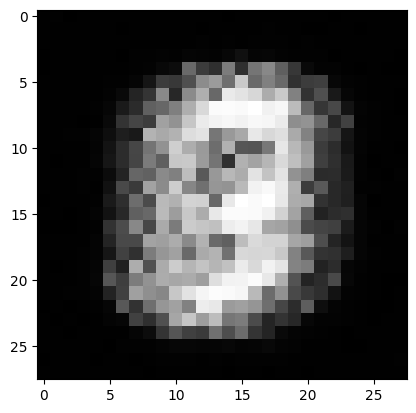

Epoch: 550
loss_g: 3.0907390117645264 	loss_d: 0.11828190833330154
Epoch: 600
loss_g: 2.973132610321045 	loss_d: 0.12355806678533554
Epoch: 650
loss_g: 2.91365909576416 	loss_d: 0.12084372341632843
Epoch: 700
loss_g: 2.2652549743652344 	loss_d: 0.22629162669181824
Epoch: 750
loss_g: 1.6986455917358398 	loss_d: 0.3296418786048889
Epoch: 800
loss_g: 1.753049612045288 	loss_d: 0.2974205017089844
Epoch: 850
loss_g: 2.0830276012420654 	loss_d: 0.24859578907489777
Epoch: 900
loss_g: 2.510240077972412 	loss_d: 0.12003947794437408
Epoch: 950
loss_g: 2.825984477996826 	loss_d: 0.07953975349664688
Epoch: 1000
loss_g: 2.797276496887207 	loss_d: 0.09070702642202377


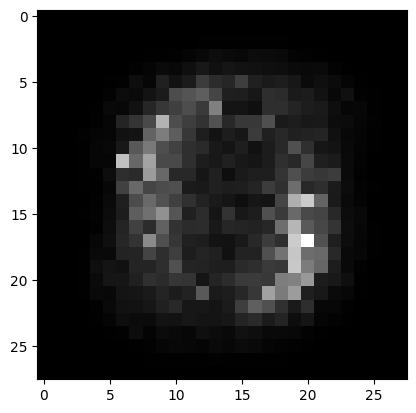

Epoch: 1050
loss_g: 3.3462657928466797 	loss_d: 0.04908514767885208
Epoch: 1100
loss_g: 3.517035961151123 	loss_d: 0.04294424504041672
Epoch: 1150
loss_g: 3.2138121128082275 	loss_d: 0.06891348958015442
Epoch: 1200
loss_g: 3.211778402328491 	loss_d: 0.061090726405382156
Epoch: 1250
loss_g: 3.2319107055664062 	loss_d: 0.07155213505029678
Epoch: 1300
loss_g: 3.1198372840881348 	loss_d: 0.10570351034402847
Epoch: 1350
loss_g: 3.2754364013671875 	loss_d: 0.06778279691934586
Epoch: 1400
loss_g: 3.3953258991241455 	loss_d: 0.15640795230865479
Epoch: 1450
loss_g: 3.259291887283325 	loss_d: 0.13143424689769745
Epoch: 1500
loss_g: 3.5201103687286377 	loss_d: 0.05949648469686508


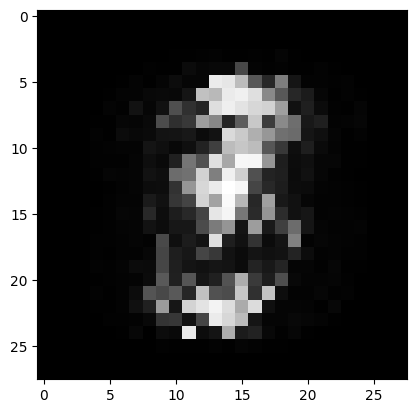

Epoch: 1550
loss_g: 3.6771223545074463 	loss_d: 0.058091867715120316
Epoch: 1600
loss_g: 3.555312156677246 	loss_d: 0.07638256996870041
Epoch: 1650
loss_g: 3.4822959899902344 	loss_d: 0.0814712718129158
Epoch: 1700
loss_g: 3.5835728645324707 	loss_d: 0.07835214585065842
Epoch: 1750
loss_g: 3.63722562789917 	loss_d: 0.06653151661157608
Epoch: 1800
loss_g: 3.702763795852661 	loss_d: 0.09229331463575363
Epoch: 1850
loss_g: 3.7925961017608643 	loss_d: 0.055520884692668915
Epoch: 1900
loss_g: 3.758781671524048 	loss_d: 0.053299449384212494
Epoch: 1950
loss_g: 3.9145050048828125 	loss_d: 0.04423809424042702
Epoch: 2000
loss_g: 3.8861236572265625 	loss_d: 0.04945925250649452


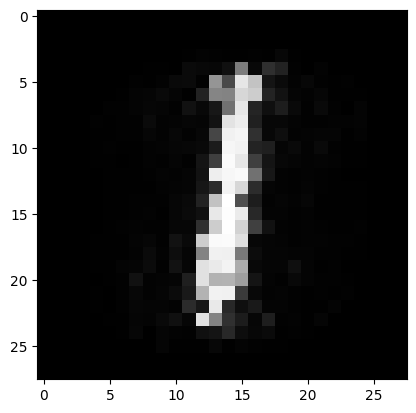

Epoch: 2050
loss_g: 3.8005831241607666 	loss_d: 0.06117558479309082
Epoch: 2100
loss_g: 4.043166160583496 	loss_d: 0.061929576098918915
Epoch: 2150
loss_g: 3.934368133544922 	loss_d: 0.0630912333726883
Epoch: 2200
loss_g: 3.8005082607269287 	loss_d: 0.05773860961198807
Epoch: 2250
loss_g: 3.9567136764526367 	loss_d: 0.037881042808294296
Epoch: 2300
loss_g: 4.057551860809326 	loss_d: 0.037664107978343964
Epoch: 2350
loss_g: 3.7322404384613037 	loss_d: 0.043224234133958817
Epoch: 2400
loss_g: 3.5376415252685547 	loss_d: 0.1281946748495102
Epoch: 2450
loss_g: 3.7655086517333984 	loss_d: 0.05897315591573715
Epoch: 2500
loss_g: 3.8335325717926025 	loss_d: 0.11499743163585663


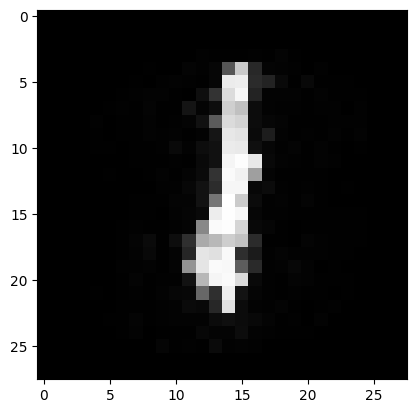

Epoch: 2550
loss_g: 3.8340837955474854 	loss_d: 0.0684652328491211
Epoch: 2600
loss_g: 3.76493763923645 	loss_d: 0.10801178961992264
Epoch: 2650
loss_g: 3.887836217880249 	loss_d: 0.07641123980283737
Epoch: 2700
loss_g: 3.8594841957092285 	loss_d: 0.050862524658441544
Epoch: 2750
loss_g: 3.9218626022338867 	loss_d: 0.07200247794389725
Epoch: 2800
loss_g: 4.051200866699219 	loss_d: 0.05570230633020401
Epoch: 2850
loss_g: 3.8977108001708984 	loss_d: 0.034279774874448776
Epoch: 2900
loss_g: 3.80240535736084 	loss_d: 0.03547731786966324
Epoch: 2950
loss_g: 3.7036519050598145 	loss_d: 0.04540828615427017
Epoch: 3000
loss_g: 3.5796282291412354 	loss_d: 0.10098394751548767


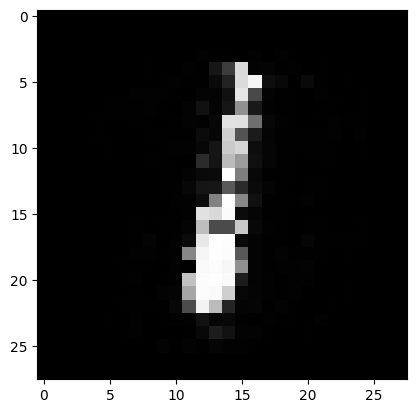

Epoch: 3050
loss_g: 3.58151912689209 	loss_d: 0.07069512456655502
Epoch: 3100
loss_g: 3.868743419647217 	loss_d: 0.043337687849998474
Epoch: 3150
loss_g: 3.8656234741210938 	loss_d: 0.07023818790912628
Epoch: 3200
loss_g: 3.776409149169922 	loss_d: 0.036540720611810684
Epoch: 3250
loss_g: 3.737462043762207 	loss_d: 0.04241737350821495
Epoch: 3300
loss_g: 3.6487510204315186 	loss_d: 0.059541087597608566
Epoch: 3350
loss_g: 3.660034656524658 	loss_d: 0.07102170586585999
Epoch: 3400
loss_g: 3.6832339763641357 	loss_d: 0.07981110364198685
Epoch: 3450
loss_g: 3.7111949920654297 	loss_d: 0.046480387449264526
Epoch: 3500
loss_g: 3.8243095874786377 	loss_d: 0.06765198707580566


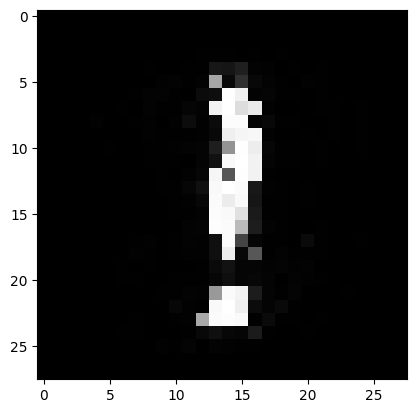

Epoch: 3550
loss_g: 4.083317756652832 	loss_d: 0.036021191626787186
Epoch: 3600
loss_g: 3.9395415782928467 	loss_d: 0.026896080002188683
Epoch: 3650
loss_g: 3.933030366897583 	loss_d: 0.07352805882692337
Epoch: 3700
loss_g: 3.690474271774292 	loss_d: 0.041704077273607254
Epoch: 3750
loss_g: 3.6248836517333984 	loss_d: 0.08889608830213547
Epoch: 3800
loss_g: 3.833710193634033 	loss_d: 0.07589267194271088
Epoch: 3850
loss_g: 3.805774688720703 	loss_d: 0.036655545234680176
Epoch: 3900
loss_g: 3.972151517868042 	loss_d: 0.026204729452729225
Epoch: 3950
loss_g: 3.6770668029785156 	loss_d: 0.0394529365003109
Epoch: 4000
loss_g: 3.667212963104248 	loss_d: 0.06324455142021179


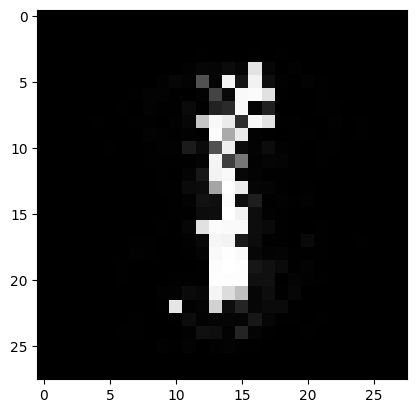

Epoch: 4050
loss_g: 3.8605711460113525 	loss_d: 0.03554064407944679
Epoch: 4100
loss_g: 3.826357364654541 	loss_d: 0.06467343121767044
Epoch: 4150
loss_g: 3.620720863342285 	loss_d: 0.037762098014354706
Epoch: 4200
loss_g: 3.6624367237091064 	loss_d: 0.1715916395187378
Epoch: 4250
loss_g: 3.686924457550049 	loss_d: 0.051997650414705276
Epoch: 4300
loss_g: 3.5302882194519043 	loss_d: 0.10088784992694855
Epoch: 4350
loss_g: 3.979743480682373 	loss_d: 0.062431760132312775
Epoch: 4400
loss_g: 3.9708757400512695 	loss_d: 0.03786497190594673
Epoch: 4450
loss_g: 3.7683067321777344 	loss_d: 0.0522712767124176
Epoch: 4500
loss_g: 4.112442970275879 	loss_d: 0.03242655470967293


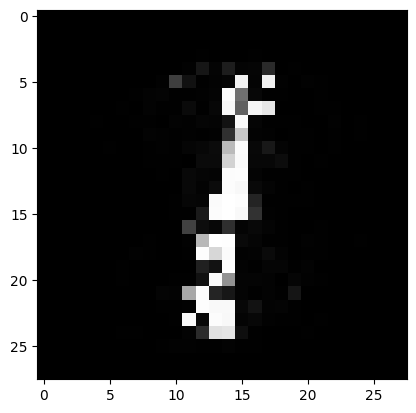

Epoch: 4550
loss_g: 3.8255932331085205 	loss_d: 0.07492949068546295
Epoch: 4600
loss_g: 3.8938000202178955 	loss_d: 0.03053341992199421
Epoch: 4650
loss_g: 3.8425920009613037 	loss_d: 0.075468048453331
Epoch: 4700
loss_g: 3.780651807785034 	loss_d: 0.028621291741728783
Epoch: 4750
loss_g: 3.783083915710449 	loss_d: 0.025948839262127876
Epoch: 4800
loss_g: 3.7233147621154785 	loss_d: 0.10030308365821838
Epoch: 4850
loss_g: 3.579014539718628 	loss_d: 0.1149948462843895
Epoch: 4900
loss_g: 3.6530215740203857 	loss_d: 0.07636061310768127
Epoch: 4950
loss_g: 3.6905550956726074 	loss_d: 0.1712951362133026
Epoch: 5000
loss_g: 3.8021018505096436 	loss_d: 0.09375367313623428


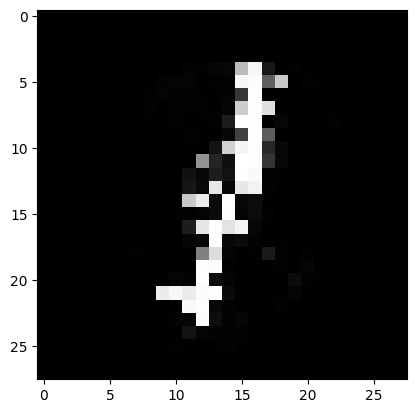

Epoch: 5050
loss_g: 4.001574993133545 	loss_d: 0.04799837991595268
Epoch: 5100
loss_g: 3.8850512504577637 	loss_d: 0.03154480457305908
Epoch: 5150
loss_g: 3.9880566596984863 	loss_d: 0.08411893993616104
Epoch: 5200
loss_g: 3.749349355697632 	loss_d: 0.041970353573560715
Epoch: 5250
loss_g: 3.6452574729919434 	loss_d: 0.07923723757266998
Epoch: 5300
loss_g: 3.694383382797241 	loss_d: 0.036909449845552444
Epoch: 5350
loss_g: 3.994309186935425 	loss_d: 0.04674949124455452
Epoch: 5400
loss_g: 3.709953546524048 	loss_d: 0.14240503311157227
Epoch: 5450
loss_g: 3.615385055541992 	loss_d: 0.05581727251410484
Epoch: 5500
loss_g: 3.6791300773620605 	loss_d: 0.06575608998537064


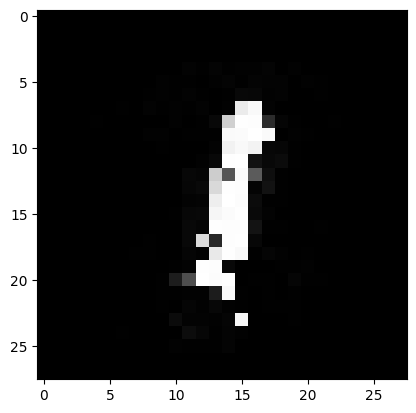

Epoch: 5550
loss_g: 3.984520196914673 	loss_d: 0.049928613007068634
Epoch: 5600
loss_g: 3.6433727741241455 	loss_d: 0.06624196469783783
Epoch: 5650
loss_g: 3.9095404148101807 	loss_d: 0.026466893032193184
Epoch: 5700
loss_g: 4.036581516265869 	loss_d: 0.07122176140546799
Epoch: 5750
loss_g: 4.078742504119873 	loss_d: 0.027039984241127968
Epoch: 5800
loss_g: 4.036523342132568 	loss_d: 0.12054780125617981
Epoch: 5850
loss_g: 4.099226951599121 	loss_d: 0.021082667633891106
Epoch: 5900
loss_g: 3.485243558883667 	loss_d: 0.04954945668578148
Epoch: 5950
loss_g: 3.869501829147339 	loss_d: 0.06505768746137619
Epoch: 6000
loss_g: 3.4621734619140625 	loss_d: 0.04332738369703293


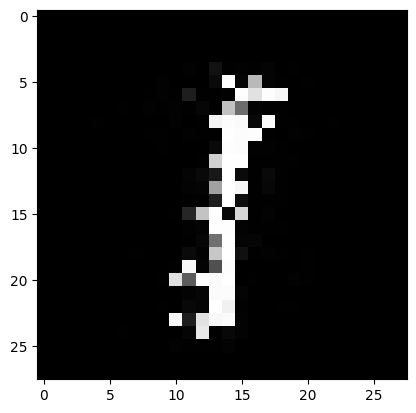

Epoch: 6050
loss_g: 3.824451446533203 	loss_d: 0.048523515462875366
Epoch: 6100
loss_g: 3.4166839122772217 	loss_d: 0.13548952341079712
Epoch: 6150
loss_g: 3.6199498176574707 	loss_d: 0.12969689071178436
Epoch: 6200
loss_g: 3.7997801303863525 	loss_d: 0.11753629148006439
Epoch: 6250
loss_g: 3.7466280460357666 	loss_d: 0.10866420716047287
Epoch: 6300
loss_g: 3.5974700450897217 	loss_d: 0.05320950970053673
Epoch: 6350
loss_g: 3.6480910778045654 	loss_d: 0.061035022139549255
Epoch: 6400
loss_g: 3.8035333156585693 	loss_d: 0.04603104293346405
Epoch: 6450
loss_g: 3.6536686420440674 	loss_d: 0.06859701126813889
Epoch: 6500
loss_g: 3.935999631881714 	loss_d: 0.08825337141752243


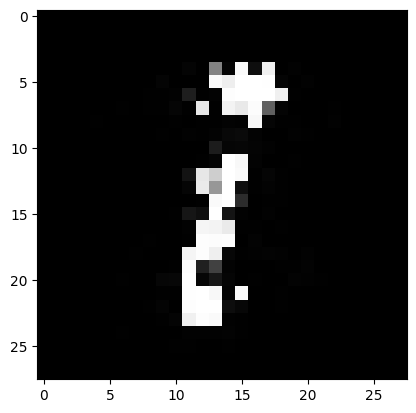

Epoch: 6550
loss_g: 3.6066396236419678 	loss_d: 0.09674514830112457
Epoch: 6600
loss_g: 3.5800719261169434 	loss_d: 0.10936232656240463
Epoch: 6650
loss_g: 3.4590983390808105 	loss_d: 0.06452102214097977
Epoch: 6700
loss_g: 3.568497896194458 	loss_d: 0.07637041807174683
Epoch: 6750
loss_g: 3.6858701705932617 	loss_d: 0.1223619133234024
Epoch: 6800
loss_g: 3.842411518096924 	loss_d: 0.03209969773888588
Epoch: 6850
loss_g: 4.0335164070129395 	loss_d: 0.04733934625983238
Epoch: 6900
loss_g: 4.194077491760254 	loss_d: 0.032948508858680725
Epoch: 6950
loss_g: 3.8696141242980957 	loss_d: 0.09905128180980682
Epoch: 7000
loss_g: 4.303962230682373 	loss_d: 0.017487293109297752


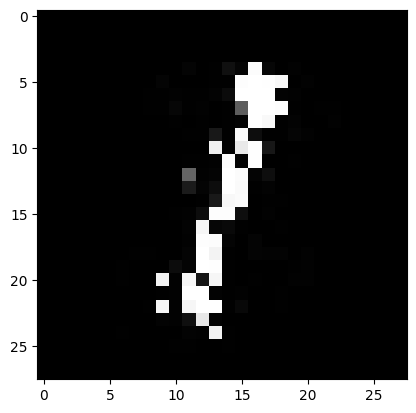

Epoch: 7050
loss_g: 3.64218807220459 	loss_d: 0.14137102663516998
Epoch: 7100
loss_g: 3.796858072280884 	loss_d: 0.11773837357759476
Epoch: 7150
loss_g: 3.593052864074707 	loss_d: 0.05735459923744202
Epoch: 7200
loss_g: 3.8990917205810547 	loss_d: 0.0707496702671051
Epoch: 7250
loss_g: 3.528801202774048 	loss_d: 0.07758690416812897
Epoch: 7300
loss_g: 3.5000317096710205 	loss_d: 0.06868928670883179
Epoch: 7350
loss_g: 3.622600555419922 	loss_d: 0.1743641495704651
Epoch: 7400
loss_g: 3.5625202655792236 	loss_d: 0.14061346650123596
Epoch: 7450
loss_g: 3.8392932415008545 	loss_d: 0.025676283985376358
Epoch: 7500
loss_g: 3.441318988800049 	loss_d: 0.07147197425365448


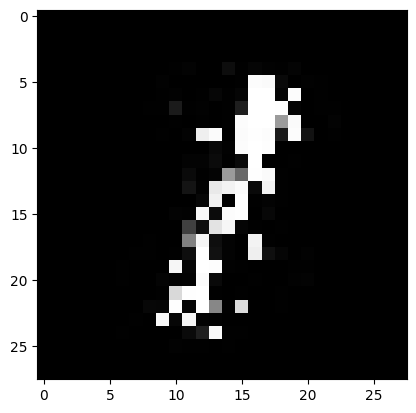

Epoch: 7550
loss_g: 3.634404182434082 	loss_d: 0.05984745919704437
Epoch: 7600
loss_g: 3.7179980278015137 	loss_d: 0.04790569469332695
Epoch: 7650
loss_g: 3.6447906494140625 	loss_d: 0.05931307375431061
Epoch: 7700
loss_g: 3.441786527633667 	loss_d: 0.07949936389923096
Epoch: 7750
loss_g: 3.672128200531006 	loss_d: 0.059396836906671524
Epoch: 7800
loss_g: 3.893009662628174 	loss_d: 0.10152824223041534
Epoch: 7850
loss_g: 4.031741142272949 	loss_d: 0.049912985414266586
Epoch: 7900
loss_g: 4.039384841918945 	loss_d: 0.03523768112063408
Epoch: 7950
loss_g: 4.076373100280762 	loss_d: 0.036174118518829346
Epoch: 8000
loss_g: 4.261934757232666 	loss_d: 0.028108784928917885


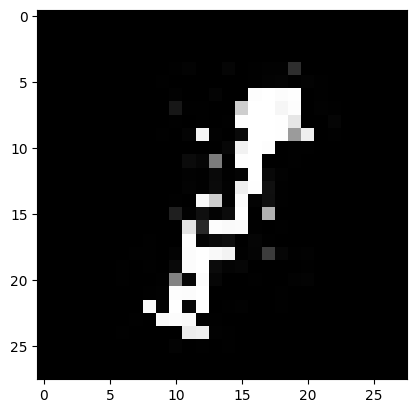

Epoch: 8050
loss_g: 4.192971229553223 	loss_d: 0.02014453336596489
Epoch: 8100
loss_g: 3.957064151763916 	loss_d: 0.045928917825222015
Epoch: 8150
loss_g: 3.728745222091675 	loss_d: 0.03978857770562172
Epoch: 8200
loss_g: 3.2737321853637695 	loss_d: 0.11379538476467133
Epoch: 8250
loss_g: 3.211290121078491 	loss_d: 0.164042666554451
Epoch: 8300
loss_g: 3.3966023921966553 	loss_d: 0.11947477608919144
Epoch: 8350
loss_g: 3.6341803073883057 	loss_d: 0.05570543184876442
Epoch: 8400
loss_g: 3.529313802719116 	loss_d: 0.08627834171056747
Epoch: 8450
loss_g: 3.49394154548645 	loss_d: 0.07052873075008392
Epoch: 8500
loss_g: 3.593421459197998 	loss_d: 0.069507896900177


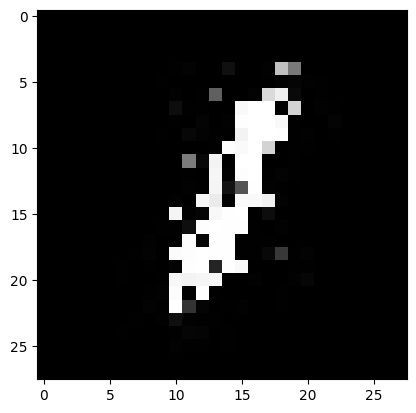

Epoch: 8550
loss_g: 3.374633312225342 	loss_d: 0.06201755255460739
Epoch: 8600
loss_g: 3.5914156436920166 	loss_d: 0.08713147044181824
Epoch: 8650
loss_g: 3.6741838455200195 	loss_d: 0.14745531976222992
Epoch: 8700
loss_g: 3.505131721496582 	loss_d: 0.10754107683897018
Epoch: 8750
loss_g: 3.649928569793701 	loss_d: 0.07163384556770325
Epoch: 8800
loss_g: 3.638953685760498 	loss_d: 0.07798642665147781
Epoch: 8850
loss_g: 3.6314685344696045 	loss_d: 0.09078054130077362
Epoch: 8900
loss_g: 3.4501519203186035 	loss_d: 0.04586492478847504
Epoch: 8950
loss_g: 3.824571371078491 	loss_d: 0.05638757720589638
Epoch: 9000
loss_g: 3.7765159606933594 	loss_d: 0.0507068857550621


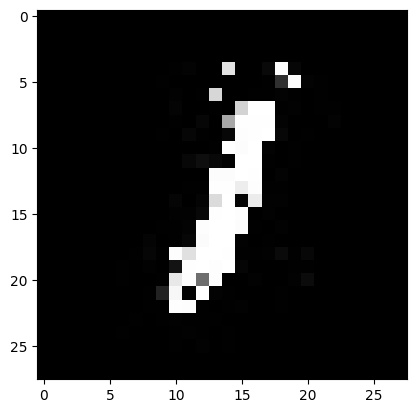

Epoch: 9050
loss_g: 3.4764015674591064 	loss_d: 0.06121151149272919
Epoch: 9100
loss_g: 3.516321897506714 	loss_d: 0.04289529472589493
Epoch: 9150
loss_g: 3.6565656661987305 	loss_d: 0.07862936705350876
Epoch: 9200
loss_g: 3.3674795627593994 	loss_d: 0.06067604944109917
Epoch: 9250
loss_g: 3.4564626216888428 	loss_d: 0.1435665786266327
Epoch: 9300
loss_g: 3.2830541133880615 	loss_d: 0.06665393710136414
Epoch: 9350
loss_g: 3.648935556411743 	loss_d: 0.0939972847700119
Epoch: 9400
loss_g: 3.446427583694458 	loss_d: 0.09050165861845016
Epoch: 9450
loss_g: 3.7550456523895264 	loss_d: 0.09507044404745102
Epoch: 9500
loss_g: 3.7818031311035156 	loss_d: 0.10861837863922119


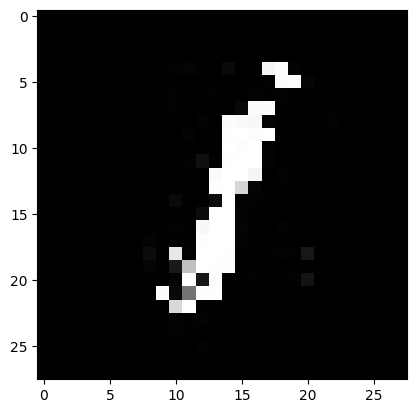

Epoch: 9550
loss_g: 3.33739972114563 	loss_d: 0.0596187487244606
Epoch: 9600
loss_g: 3.680096387863159 	loss_d: 0.04299428313970566
Epoch: 9650
loss_g: 3.700359344482422 	loss_d: 0.08160219341516495
Epoch: 9700
loss_g: 3.572561264038086 	loss_d: 0.05711546912789345
Epoch: 9750
loss_g: 3.231128692626953 	loss_d: 0.15358227491378784
Epoch: 9800
loss_g: 3.4992306232452393 	loss_d: 0.126417875289917
Epoch: 9850
loss_g: 3.7759618759155273 	loss_d: 0.027755700051784515
Epoch: 9900
loss_g: 3.5907249450683594 	loss_d: 0.05200820788741112
Epoch: 9950
loss_g: 3.3896069526672363 	loss_d: 0.08066526800394058
Epoch: 10000
loss_g: 3.40008282661438 	loss_d: 0.055517710745334625


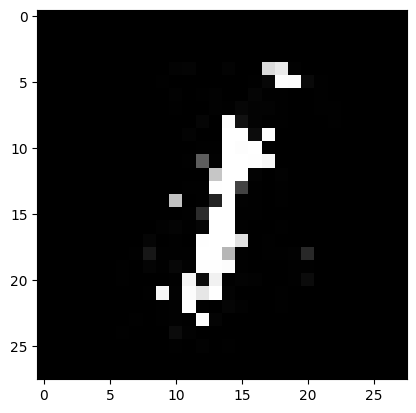

Epoch: 10050
loss_g: 3.1966781616210938 	loss_d: 0.07296888530254364
Epoch: 10100
loss_g: 3.1751110553741455 	loss_d: 0.06960291415452957
Epoch: 10150
loss_g: 3.281047821044922 	loss_d: 0.09457311779260635
Epoch: 10200
loss_g: 3.3786067962646484 	loss_d: 0.08910852670669556
Epoch: 10250
loss_g: 3.0194058418273926 	loss_d: 0.07359001785516739
Epoch: 10300
loss_g: 2.827486276626587 	loss_d: 0.08535834401845932
Epoch: 10350
loss_g: 2.553255319595337 	loss_d: 0.18792162835597992
Epoch: 10400
loss_g: 2.2847578525543213 	loss_d: 0.20676754415035248
Epoch: 10450
loss_g: 2.8570220470428467 	loss_d: 0.08357753604650497
Epoch: 10500
loss_g: 2.7733049392700195 	loss_d: 0.23139502108097076


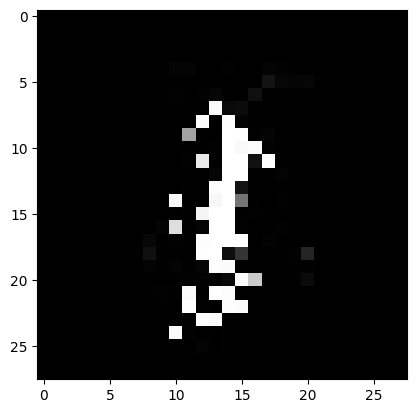

Epoch: 10550
loss_g: 3.0011940002441406 	loss_d: 0.11019261181354523
Epoch: 10600
loss_g: 3.0201356410980225 	loss_d: 0.12494435906410217
Epoch: 10650
loss_g: 3.0701420307159424 	loss_d: 0.09887129068374634
Epoch: 10700
loss_g: 3.197460174560547 	loss_d: 0.09205208718776703
Epoch: 10750
loss_g: 3.1024510860443115 	loss_d: 0.19189727306365967
Epoch: 10800
loss_g: 3.2678515911102295 	loss_d: 0.06038761883974075
Epoch: 10850
loss_g: 3.1810545921325684 	loss_d: 0.06358134746551514
Epoch: 10900
loss_g: 2.858597993850708 	loss_d: 0.18774576485157013
Epoch: 10950
loss_g: 2.651556968688965 	loss_d: 0.1355605125427246
Epoch: 11000
loss_g: 2.9606049060821533 	loss_d: 0.10702206939458847


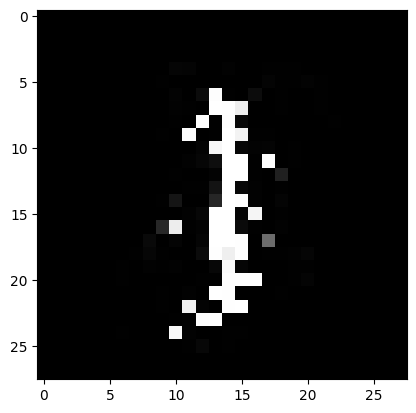

Epoch: 11050
loss_g: 3.158191680908203 	loss_d: 0.13524650037288666
Epoch: 11100
loss_g: 2.730539560317993 	loss_d: 0.09834140539169312
Epoch: 11150
loss_g: 2.995755434036255 	loss_d: 0.13978825509548187
Epoch: 11200
loss_g: 2.9602391719818115 	loss_d: 0.11583517491817474
Epoch: 11250
loss_g: 3.18435001373291 	loss_d: 0.09086348861455917
Epoch: 11300
loss_g: 3.404656410217285 	loss_d: 0.06801468133926392
Epoch: 11350
loss_g: 3.3791332244873047 	loss_d: 0.12512503564357758
Epoch: 11400
loss_g: 3.3491315841674805 	loss_d: 0.11804036796092987
Epoch: 11450
loss_g: 2.9076619148254395 	loss_d: 0.1287972331047058
Epoch: 11500
loss_g: 3.109035015106201 	loss_d: 0.08785001933574677


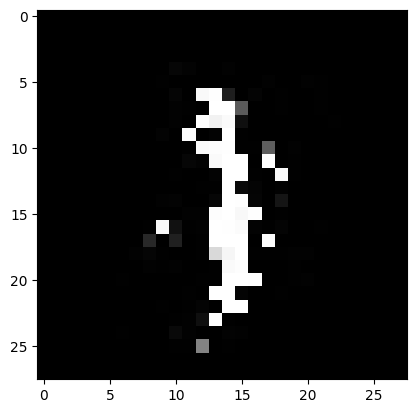

Epoch: 11550
loss_g: 2.7257211208343506 	loss_d: 0.14646796882152557
Epoch: 11600
loss_g: 3.178436517715454 	loss_d: 0.12191037088632584
Epoch: 11650
loss_g: 3.0896553993225098 	loss_d: 0.17343303561210632
Epoch: 11700
loss_g: 3.120368242263794 	loss_d: 0.0889502540230751
Epoch: 11750
loss_g: 3.1057991981506348 	loss_d: 0.13915801048278809
Epoch: 11800
loss_g: 3.24965763092041 	loss_d: 0.09625605493783951
Epoch: 11850
loss_g: 2.862539052963257 	loss_d: 0.19165827333927155
Epoch: 11900
loss_g: 3.0969722270965576 	loss_d: 0.10102348029613495
Epoch: 11950
loss_g: 3.06046986579895 	loss_d: 0.10904877632856369
Epoch: 12000
loss_g: 3.1152336597442627 	loss_d: 0.15906032919883728


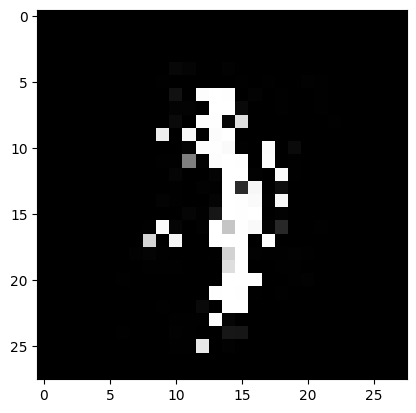

Epoch: 12050
loss_g: 2.813300609588623 	loss_d: 0.13173219561576843
Epoch: 12100
loss_g: 2.732661724090576 	loss_d: 0.15171463787555695
Epoch: 12150
loss_g: 2.6749627590179443 	loss_d: 0.2233259677886963
Epoch: 12200
loss_g: 2.4268815517425537 	loss_d: 0.19100052118301392
Epoch: 12250
loss_g: 2.889518976211548 	loss_d: 0.20414328575134277
Epoch: 12300
loss_g: 2.8909056186676025 	loss_d: 0.17087890207767487
Epoch: 12350
loss_g: 2.9881274700164795 	loss_d: 0.22889740765094757
Epoch: 12400
loss_g: 2.8662195205688477 	loss_d: 0.21653763949871063
Epoch: 12450
loss_g: 2.9703032970428467 	loss_d: 0.1845940500497818
Epoch: 12500
loss_g: 2.7350382804870605 	loss_d: 0.18398204445838928


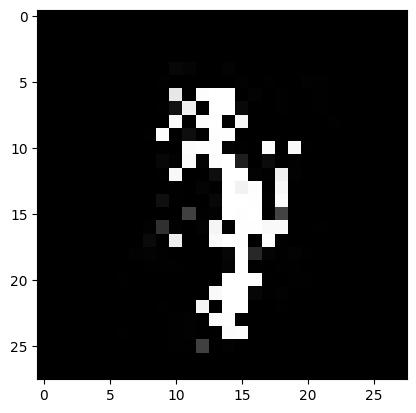

Epoch: 12550
loss_g: 2.7641546726226807 	loss_d: 0.13651464879512787
Epoch: 12600
loss_g: 2.609483003616333 	loss_d: 0.10659702122211456
Epoch: 12650
loss_g: 2.3603272438049316 	loss_d: 0.16368833184242249
Epoch: 12700
loss_g: 2.3827455043792725 	loss_d: 0.14256201684474945
Epoch: 12750
loss_g: 2.7918541431427 	loss_d: 0.22631898522377014
Epoch: 12800
loss_g: 3.055732250213623 	loss_d: 0.10885418206453323
Epoch: 12850
loss_g: 3.210583209991455 	loss_d: 0.16744600236415863
Epoch: 12900
loss_g: 3.152597188949585 	loss_d: 0.1445123255252838
Epoch: 12950
loss_g: 2.8280274868011475 	loss_d: 0.1510331779718399
Epoch: 13000
loss_g: 2.8363640308380127 	loss_d: 0.22582592070102692


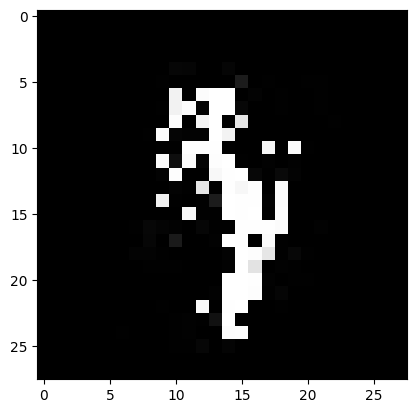

Epoch: 13050
loss_g: 3.056762933731079 	loss_d: 0.11086537688970566
Epoch: 13100
loss_g: 2.9648730754852295 	loss_d: 0.21751566231250763
Epoch: 13150
loss_g: 2.893113374710083 	loss_d: 0.17886659502983093
Epoch: 13200
loss_g: 2.925053358078003 	loss_d: 0.10802121460437775
Epoch: 13250
loss_g: 3.0721044540405273 	loss_d: 0.18129730224609375
Epoch: 13300
loss_g: 2.9954662322998047 	loss_d: 0.11346384137868881
Epoch: 13350
loss_g: 3.0011987686157227 	loss_d: 0.20447911322116852
Epoch: 13400
loss_g: 2.970670700073242 	loss_d: 0.1731172353029251
Epoch: 13450
loss_g: 2.8618812561035156 	loss_d: 0.08612808585166931
Epoch: 13500
loss_g: 2.989530563354492 	loss_d: 0.13661766052246094


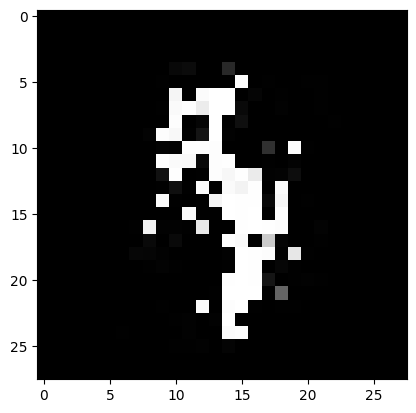

Epoch: 13550
loss_g: 2.9069719314575195 	loss_d: 0.12764668464660645
Epoch: 13600
loss_g: 2.736341714859009 	loss_d: 0.2230922132730484
Epoch: 13650
loss_g: 2.3807809352874756 	loss_d: 0.16192388534545898
Epoch: 13700
loss_g: 2.552816390991211 	loss_d: 0.17022362351417542
Epoch: 13750
loss_g: 2.6546130180358887 	loss_d: 0.12713709473609924
Epoch: 13800
loss_g: 2.7821600437164307 	loss_d: 0.369529664516449
Epoch: 13850
loss_g: 2.8647351264953613 	loss_d: 0.20707345008850098
Epoch: 13900
loss_g: 2.810223340988159 	loss_d: 0.2091737687587738
Epoch: 13950
loss_g: 2.792556047439575 	loss_d: 0.218474879860878
Epoch: 14000
loss_g: 2.8559205532073975 	loss_d: 0.1425868421792984


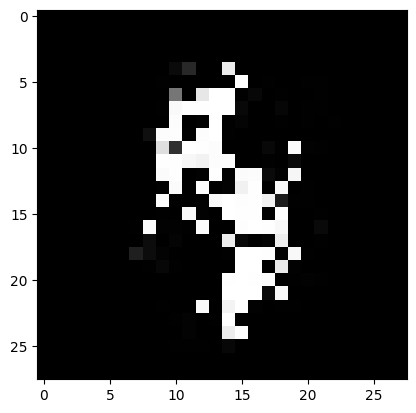

Epoch: 14050
loss_g: 2.7937560081481934 	loss_d: 0.2736435830593109
Epoch: 14100
loss_g: 2.6649608612060547 	loss_d: 0.16530528664588928
Epoch: 14150
loss_g: 2.60176682472229 	loss_d: 0.27797484397888184
Epoch: 14200
loss_g: 2.5102734565734863 	loss_d: 0.18259252607822418
Epoch: 14250
loss_g: 2.3455002307891846 	loss_d: 0.33043771982192993
Epoch: 14300
loss_g: 2.3156449794769287 	loss_d: 0.27887246012687683
Epoch: 14350
loss_g: 2.436716079711914 	loss_d: 0.25865864753723145
Epoch: 14400
loss_g: 2.54709792137146 	loss_d: 0.27373456954956055
Epoch: 14450
loss_g: 2.6619479656219482 	loss_d: 0.2832051217556
Epoch: 14500
loss_g: 2.729557991027832 	loss_d: 0.26268041133880615


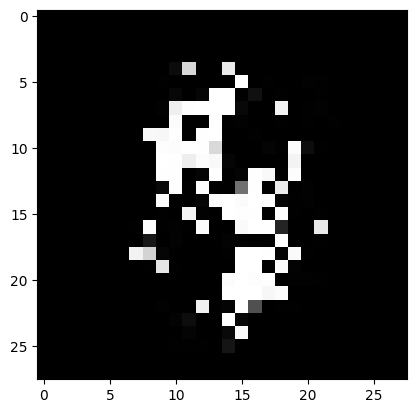

Epoch: 14550
loss_g: 2.6487693786621094 	loss_d: 0.2857322096824646
Epoch: 14600
loss_g: 2.7209291458129883 	loss_d: 0.2802274227142334
Epoch: 14650
loss_g: 2.702824592590332 	loss_d: 0.24523817002773285
Epoch: 14700
loss_g: 2.409107208251953 	loss_d: 0.2464877814054489
Epoch: 14750
loss_g: 2.4319100379943848 	loss_d: 0.343275785446167
Epoch: 14800
loss_g: 2.4593875408172607 	loss_d: 0.2405710369348526
Epoch: 14850
loss_g: 2.2817866802215576 	loss_d: 0.3076324462890625
Epoch: 14900
loss_g: 2.392498254776001 	loss_d: 0.2725101411342621
Epoch: 14950
loss_g: 2.546475410461426 	loss_d: 0.20105887949466705
Epoch: 15000
loss_g: 2.5156843662261963 	loss_d: 0.17056432366371155


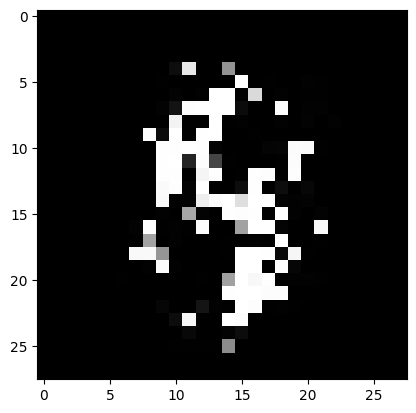

Epoch: 15050
loss_g: 2.410832166671753 	loss_d: 0.2791009843349457
Epoch: 15100
loss_g: 2.5106332302093506 	loss_d: 0.19455690681934357
Epoch: 15150
loss_g: 2.6721813678741455 	loss_d: 0.20598715543746948
Epoch: 15200
loss_g: 2.7611024379730225 	loss_d: 0.22105780243873596
Epoch: 15250
loss_g: 2.6711833477020264 	loss_d: 0.1776295304298401
Epoch: 15300
loss_g: 2.5366756916046143 	loss_d: 0.251773864030838
Epoch: 15350
loss_g: 2.273099422454834 	loss_d: 0.2750353515148163
Epoch: 15400
loss_g: 2.40442156791687 	loss_d: 0.2613306939601898
Epoch: 15450
loss_g: 2.5536367893218994 	loss_d: 0.24453744292259216
Epoch: 15500
loss_g: 2.4697892665863037 	loss_d: 0.27151885628700256


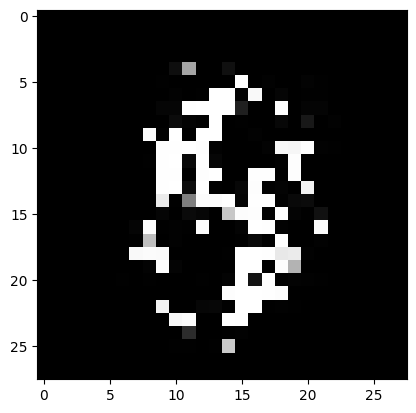

Epoch: 15550
loss_g: 2.193150043487549 	loss_d: 0.26588767766952515
Epoch: 15600
loss_g: 2.332172155380249 	loss_d: 0.2756713926792145
Epoch: 15650
loss_g: 2.3773415088653564 	loss_d: 0.28102731704711914
Epoch: 15700
loss_g: 2.3981950283050537 	loss_d: 0.28357088565826416
Epoch: 15750
loss_g: 2.25423002243042 	loss_d: 0.33923885226249695
Epoch: 15800
loss_g: 2.00333309173584 	loss_d: 0.4235355854034424
Epoch: 15850
loss_g: 2.0283942222595215 	loss_d: 0.32682904601097107
Epoch: 15900
loss_g: 2.127650499343872 	loss_d: 0.33668047189712524
Epoch: 15950
loss_g: 2.2450554370880127 	loss_d: 0.2530374526977539
Epoch: 16000
loss_g: 2.2592275142669678 	loss_d: 0.389011412858963


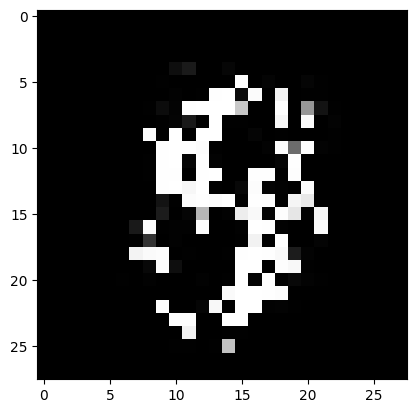

Epoch: 16050
loss_g: 2.3563034534454346 	loss_d: 0.24476414918899536
Epoch: 16100
loss_g: 2.307783842086792 	loss_d: 0.3320936858654022
Epoch: 16150
loss_g: 2.351078987121582 	loss_d: 0.25877514481544495
Epoch: 16200
loss_g: 2.3712573051452637 	loss_d: 0.4929134249687195
Epoch: 16250
loss_g: 2.331151008605957 	loss_d: 0.4261716604232788
Epoch: 16300
loss_g: 2.3846731185913086 	loss_d: 0.3314683139324188
Epoch: 16350
loss_g: 2.344855785369873 	loss_d: 0.3807818293571472
Epoch: 16400
loss_g: 2.1182796955108643 	loss_d: 0.32269251346588135
Epoch: 16450
loss_g: 2.136364459991455 	loss_d: 0.35047611594200134
Epoch: 16500
loss_g: 2.2471518516540527 	loss_d: 0.3581768572330475


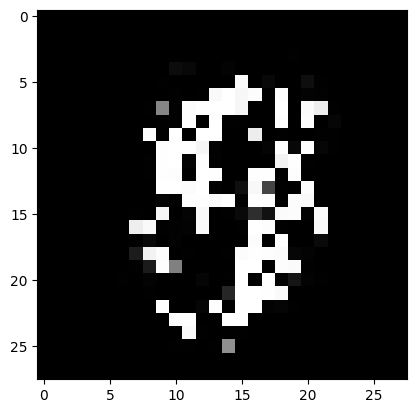

Epoch: 16550
loss_g: 2.335314989089966 	loss_d: 0.3300488591194153
Epoch: 16600
loss_g: 2.430732011795044 	loss_d: 0.38089612126350403
Epoch: 16650
loss_g: 2.5177462100982666 	loss_d: 0.4242858290672302
Epoch: 16700
loss_g: 2.5000555515289307 	loss_d: 0.3323337733745575
Epoch: 16750
loss_g: 2.307732343673706 	loss_d: 0.3194625973701477
Epoch: 16800
loss_g: 2.1381137371063232 	loss_d: 0.37845903635025024
Epoch: 16850
loss_g: 1.9366466999053955 	loss_d: 0.5503073930740356
Epoch: 16900
loss_g: 2.007312536239624 	loss_d: 0.45533061027526855
Epoch: 16950
loss_g: 2.120828866958618 	loss_d: 0.4328935444355011
Epoch: 17000
loss_g: 2.144324541091919 	loss_d: 0.39241519570350647


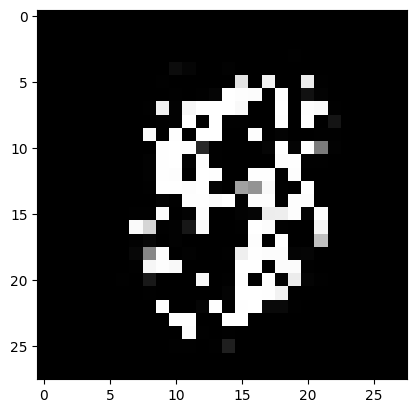

Epoch: 17050
loss_g: 2.094003200531006 	loss_d: 0.4305195212364197
Epoch: 17100
loss_g: 1.824134349822998 	loss_d: 0.41158124804496765
Epoch: 17150
loss_g: 1.658468246459961 	loss_d: 0.5507470369338989
Epoch: 17200
loss_g: 1.8027291297912598 	loss_d: 0.40206989645957947
Epoch: 17250
loss_g: 1.9929897785186768 	loss_d: 0.42875975370407104
Epoch: 17300
loss_g: 2.1166303157806396 	loss_d: 0.3634670674800873
Epoch: 17350
loss_g: 2.1465847492218018 	loss_d: 0.3457117974758148
Epoch: 17400
loss_g: 2.2166101932525635 	loss_d: 0.304616779088974
Epoch: 17450
loss_g: 2.3100900650024414 	loss_d: 0.3643476366996765
Epoch: 17500
loss_g: 2.3373708724975586 	loss_d: 0.3836413621902466


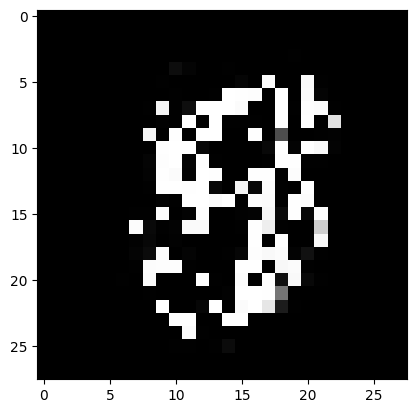

Epoch: 17550
loss_g: 2.236311912536621 	loss_d: 0.40485554933547974
Epoch: 17600
loss_g: 2.2563650608062744 	loss_d: 0.4241769313812256
Epoch: 17650
loss_g: 2.2606842517852783 	loss_d: 0.3457953929901123
Epoch: 17700
loss_g: 2.2193374633789062 	loss_d: 0.3750559985637665
Epoch: 17750
loss_g: 2.1866061687469482 	loss_d: 0.45450517535209656
Epoch: 17800
loss_g: 2.0000016689300537 	loss_d: 0.33110862970352173
Epoch: 17850
loss_g: 1.9896514415740967 	loss_d: 0.45187458395957947
Epoch: 17900
loss_g: 2.0746748447418213 	loss_d: 0.45784589648246765
Epoch: 17950
loss_g: 2.058729410171509 	loss_d: 0.3695349395275116
Epoch: 18000
loss_g: 1.9625588655471802 	loss_d: 0.47853729128837585


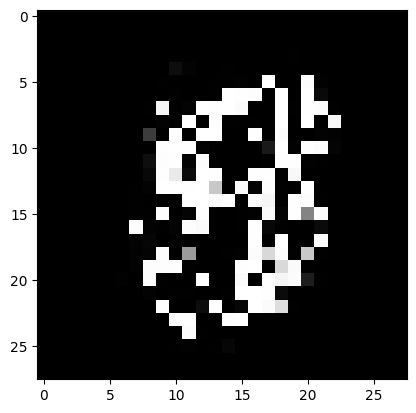

Epoch: 18050
loss_g: 1.9839057922363281 	loss_d: 0.43498495221138
Epoch: 18100
loss_g: 2.0570476055145264 	loss_d: 0.4475313425064087
Epoch: 18150
loss_g: 2.0784201622009277 	loss_d: 0.4413294792175293
Epoch: 18200
loss_g: 2.047426700592041 	loss_d: 0.4799043834209442
Epoch: 18250
loss_g: 1.9549190998077393 	loss_d: 0.40749526023864746
Epoch: 18300
loss_g: 1.9458849430084229 	loss_d: 0.45687592029571533
Epoch: 18350
loss_g: 1.9399234056472778 	loss_d: 0.36439627408981323
Epoch: 18400
loss_g: 1.837890386581421 	loss_d: 0.5534656047821045
Epoch: 18450
loss_g: 1.8673250675201416 	loss_d: 0.43386557698249817
Epoch: 18500
loss_g: 1.9819687604904175 	loss_d: 0.4494610130786896


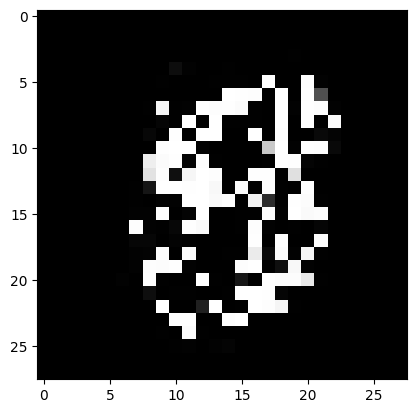

Epoch: 18550
loss_g: 2.0600357055664062 	loss_d: 0.4276297688484192
Epoch: 18600
loss_g: 2.0155081748962402 	loss_d: 0.5721278190612793
Epoch: 18650
loss_g: 1.866615891456604 	loss_d: 0.6015467643737793
Epoch: 18700
loss_g: 1.8076525926589966 	loss_d: 0.49274885654449463
Epoch: 18750
loss_g: 1.8104392290115356 	loss_d: 0.5849113464355469
Epoch: 18800
loss_g: 1.840909719467163 	loss_d: 0.4769681394100189
Epoch: 18850
loss_g: 1.848158836364746 	loss_d: 0.4421638548374176
Epoch: 18900
loss_g: 1.906983494758606 	loss_d: 0.510948121547699
Epoch: 18950
loss_g: 2.0077502727508545 	loss_d: 0.3606147766113281
Epoch: 19000
loss_g: 2.086266040802002 	loss_d: 0.5699265599250793


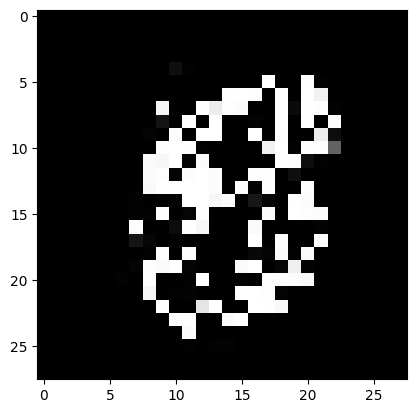

Epoch: 19050
loss_g: 2.1247525215148926 	loss_d: 0.4556457996368408
Epoch: 19100
loss_g: 2.0828850269317627 	loss_d: 0.40921059250831604
Epoch: 19150
loss_g: 1.9497514963150024 	loss_d: 0.4563806653022766
Epoch: 19200
loss_g: 1.9246309995651245 	loss_d: 0.45348817110061646
Epoch: 19250
loss_g: 1.819944977760315 	loss_d: 0.7369120717048645
Epoch: 19300
loss_g: 1.661802887916565 	loss_d: 0.5794152617454529
Epoch: 19350
loss_g: 1.615842580795288 	loss_d: 0.610323429107666
Epoch: 19400
loss_g: 1.5093945264816284 	loss_d: 0.5306396484375
Epoch: 19450
loss_g: 1.2769840955734253 	loss_d: 0.7426115274429321
Epoch: 19500
loss_g: 1.209635853767395 	loss_d: 0.7247726321220398


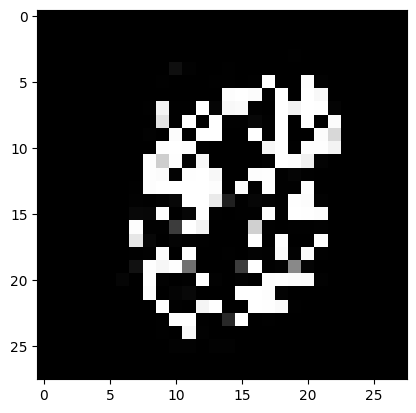

Epoch: 19550
loss_g: 1.2585641145706177 	loss_d: 0.6990032196044922
Epoch: 19600
loss_g: 1.350962519645691 	loss_d: 0.6179671883583069
Epoch: 19650
loss_g: 1.4359651803970337 	loss_d: 0.6209501624107361
Epoch: 19700
loss_g: 1.510101556777954 	loss_d: 0.5530158281326294
Epoch: 19750
loss_g: 1.5274419784545898 	loss_d: 0.5914855599403381
Epoch: 19800
loss_g: 1.4170068502426147 	loss_d: 0.5581108331680298
Epoch: 19850
loss_g: 1.3050538301467896 	loss_d: 0.691773533821106
Epoch: 19900
loss_g: 1.3282389640808105 	loss_d: 0.7235591411590576
Epoch: 19950
loss_g: 1.3557647466659546 	loss_d: 0.7929211258888245
Epoch: 20000
loss_g: 1.314144253730774 	loss_d: 0.8324217796325684


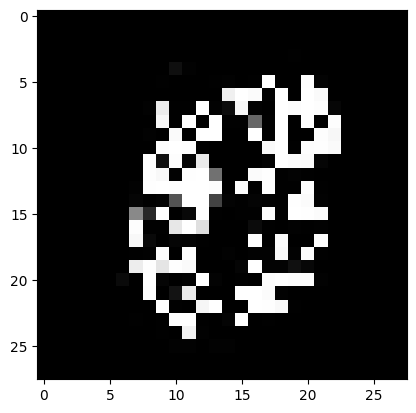

Epoch: 20050
loss_g: 1.259463906288147 	loss_d: 0.7118222713470459
Epoch: 20100
loss_g: 1.234344720840454 	loss_d: 0.7500302791595459
Epoch: 20150
loss_g: 1.151065707206726 	loss_d: 0.9520748853683472
Epoch: 20200
loss_g: 1.1041406393051147 	loss_d: 0.7554793953895569
Epoch: 20250
loss_g: 1.1679803133010864 	loss_d: 0.9161239266395569
Epoch: 20300
loss_g: 1.2668229341506958 	loss_d: 0.8318638205528259
Epoch: 20350
loss_g: 1.357680320739746 	loss_d: 0.760676920413971
Epoch: 20400
loss_g: 1.43055260181427 	loss_d: 0.8311435580253601
Epoch: 20450
loss_g: 1.4898769855499268 	loss_d: 0.7996938824653625
Epoch: 20500
loss_g: 1.5411360263824463 	loss_d: 0.7379858493804932


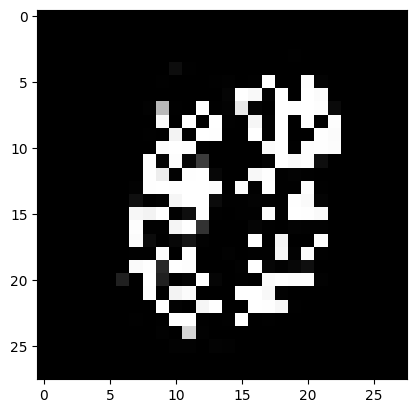

Epoch: 20550
loss_g: 1.565136432647705 	loss_d: 0.6881449222564697
Epoch: 20600
loss_g: 1.5315570831298828 	loss_d: 0.7359381914138794
Epoch: 20650
loss_g: 1.4264919757843018 	loss_d: 0.6833672523498535
Epoch: 20700
loss_g: 1.3249038457870483 	loss_d: 0.8806703090667725
Epoch: 20750
loss_g: 1.2841100692749023 	loss_d: 0.683885931968689
Epoch: 20800
loss_g: 1.2507292032241821 	loss_d: 0.9407766461372375
Epoch: 20850
loss_g: 1.2033263444900513 	loss_d: 0.8686074018478394
Epoch: 20900
loss_g: 1.1639090776443481 	loss_d: 0.9724650382995605
Epoch: 20950
loss_g: 1.1264842748641968 	loss_d: 0.998884916305542
Epoch: 21000
loss_g: 1.0681633949279785 	loss_d: 1.0190285444259644


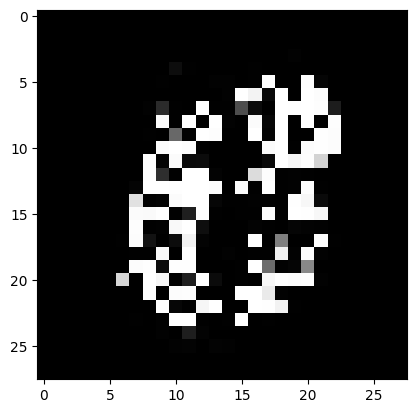

Epoch: 21050
loss_g: 1.0143474340438843 	loss_d: 1.1361876726150513
Epoch: 21100
loss_g: 0.9662051796913147 	loss_d: 1.0393534898757935
Epoch: 21150
loss_g: 0.9277324676513672 	loss_d: 1.3401809930801392
Epoch: 21200
loss_g: 0.9592217803001404 	loss_d: 1.0689722299575806
Epoch: 21250
loss_g: 1.0196456909179688 	loss_d: 0.9673341512680054
Epoch: 21300
loss_g: 1.0721029043197632 	loss_d: 1.0860823392868042
Epoch: 21350
loss_g: 1.094314455986023 	loss_d: 0.7412024140357971
Epoch: 21400
loss_g: 1.0772868394851685 	loss_d: 1.2264388799667358
Epoch: 21450
loss_g: 1.014400601387024 	loss_d: 0.9116302728652954
Epoch: 21500
loss_g: 0.8985339403152466 	loss_d: 1.0772062540054321


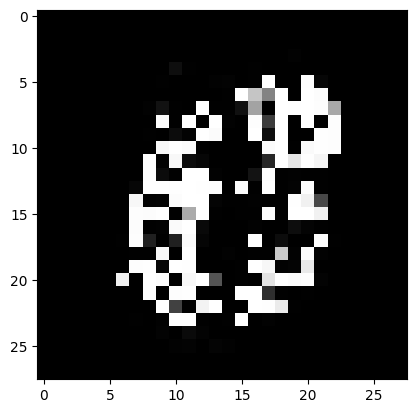

Epoch: 21550
loss_g: 0.754217803478241 	loss_d: 1.2659358978271484
Epoch: 21600
loss_g: 0.6737208962440491 	loss_d: 1.2841002941131592
Epoch: 21650
loss_g: 0.672543466091156 	loss_d: 1.8104026317596436
Epoch: 21700
loss_g: 0.7082983255386353 	loss_d: 1.4714173078536987
Epoch: 21750
loss_g: 0.7521491646766663 	loss_d: 1.4507216215133667
Epoch: 21800
loss_g: 0.7900248765945435 	loss_d: 1.2078273296356201
Epoch: 21850
loss_g: 0.8119648694992065 	loss_d: 1.3766847848892212
Epoch: 21900
loss_g: 0.808344841003418 	loss_d: 1.4015812873840332
Epoch: 21950
loss_g: 0.8135285973548889 	loss_d: 1.2383859157562256
Epoch: 22000
loss_g: 0.8386875987052917 	loss_d: 1.294904351234436


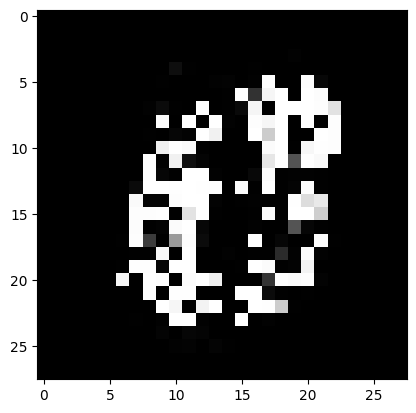

Epoch: 22050
loss_g: 0.8720861673355103 	loss_d: 1.381351351737976
Epoch: 22100
loss_g: 0.9008430242538452 	loss_d: 1.1859791278839111
Epoch: 22150
loss_g: 0.9195358157157898 	loss_d: 1.2912341356277466
Epoch: 22200
loss_g: 0.9054083228111267 	loss_d: 1.1349992752075195
Epoch: 22250
loss_g: 0.8321776986122131 	loss_d: 1.4779880046844482
Epoch: 22300
loss_g: 0.7953927516937256 	loss_d: 1.3341652154922485
Epoch: 22350
loss_g: 0.8017826676368713 	loss_d: 1.506038784980774
Epoch: 22400
loss_g: 0.8031571507453918 	loss_d: 1.448881983757019
Epoch: 22450
loss_g: 0.7923745512962341 	loss_d: 1.3734538555145264
Epoch: 22500
loss_g: 0.7891658544540405 	loss_d: 1.4129763841629028


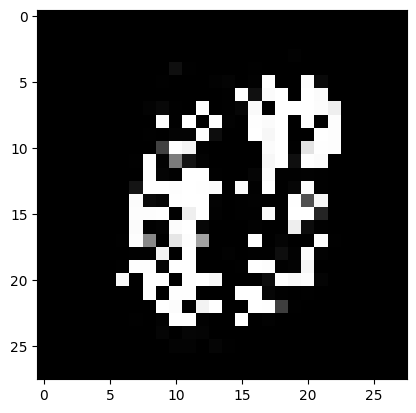

Epoch: 22550
loss_g: 0.8104074597358704 	loss_d: 1.4999501705169678
Epoch: 22600
loss_g: 0.8514909744262695 	loss_d: 1.2146642208099365
Epoch: 22650
loss_g: 0.899391770362854 	loss_d: 1.524071216583252
Epoch: 22700
loss_g: 0.9450032114982605 	loss_d: 1.402625322341919
Epoch: 22750
loss_g: 0.98136967420578 	loss_d: 1.409761905670166
Epoch: 22800
loss_g: 1.0077216625213623 	loss_d: 1.3816254138946533
Epoch: 22850
loss_g: 1.0333985090255737 	loss_d: 1.4520128965377808
Epoch: 22900
loss_g: 1.0580123662948608 	loss_d: 1.319309115409851
Epoch: 22950
loss_g: 1.069959044456482 	loss_d: 1.1894688606262207
Epoch: 23000
loss_g: 1.0571496486663818 	loss_d: 1.3012657165527344


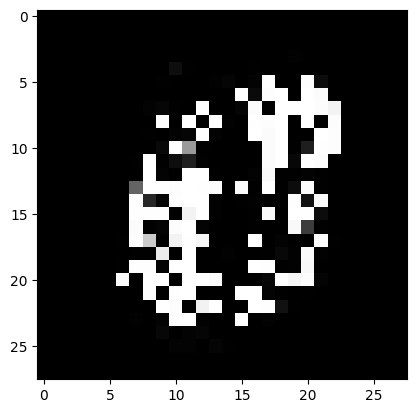

Epoch: 23050
loss_g: 1.024423599243164 	loss_d: 1.2246137857437134
Epoch: 23100
loss_g: 0.9953481554985046 	loss_d: 1.569821834564209
Epoch: 23150
loss_g: 0.9769260287284851 	loss_d: 1.1460449695587158
Epoch: 23200
loss_g: 0.9740443229675293 	loss_d: 1.4605556726455688
Epoch: 23250
loss_g: 0.9870778918266296 	loss_d: 1.374360203742981
Epoch: 23300
loss_g: 1.012690544128418 	loss_d: 1.663111686706543
Epoch: 23350
loss_g: 1.0454802513122559 	loss_d: 1.5097438097000122
Epoch: 23400
loss_g: 1.0769321918487549 	loss_d: 1.3272898197174072
Epoch: 23450
loss_g: 1.1011924743652344 	loss_d: 1.5151567459106445
Epoch: 23500
loss_g: 1.1099269390106201 	loss_d: 1.291907548904419


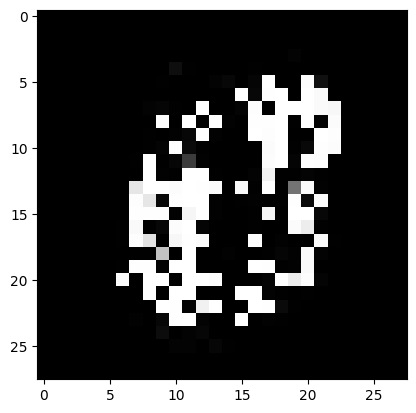

Epoch: 23550
loss_g: 1.1138218641281128 	loss_d: 1.7207269668579102
Epoch: 23600
loss_g: 1.1242042779922485 	loss_d: 1.313187837600708
Epoch: 23650
loss_g: 1.1397771835327148 	loss_d: 1.1772701740264893
Epoch: 23700
loss_g: 1.1497094631195068 	loss_d: 1.3937108516693115
Epoch: 23750
loss_g: 1.1604472398757935 	loss_d: 0.8662897348403931
Epoch: 23800
loss_g: 1.1744054555892944 	loss_d: 1.5030553340911865
Epoch: 23850
loss_g: 1.1903246641159058 	loss_d: 0.9791997671127319
Epoch: 23900
loss_g: 1.2057486772537231 	loss_d: 1.1921335458755493
Epoch: 23950
loss_g: 1.2187412977218628 	loss_d: 1.2329530715942383
Epoch: 24000
loss_g: 1.2234423160552979 	loss_d: 1.1012085676193237


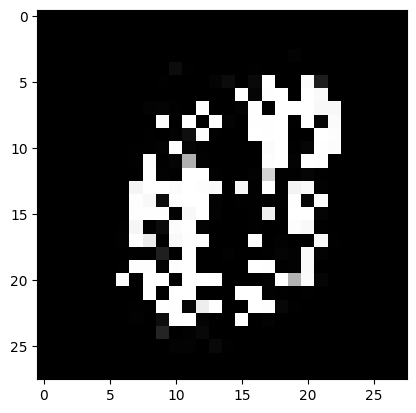

Epoch: 24050
loss_g: 1.2185146808624268 	loss_d: 1.6922898292541504
Epoch: 24100
loss_g: 1.2031261920928955 	loss_d: 1.3730169534683228
Epoch: 24150
loss_g: 1.1770557165145874 	loss_d: 1.3548845052719116
Epoch: 24200
loss_g: 1.1449236869812012 	loss_d: 1.0956475734710693
Epoch: 24250
loss_g: 1.1151621341705322 	loss_d: 1.3064969778060913
Epoch: 24300
loss_g: 1.0916869640350342 	loss_d: 1.3472814559936523
Epoch: 24350
loss_g: 1.0698082447052002 	loss_d: 1.1614277362823486
Epoch: 24400
loss_g: 1.0522936582565308 	loss_d: 1.2953752279281616
Epoch: 24450
loss_g: 1.0314854383468628 	loss_d: 1.4379767179489136
Epoch: 24500
loss_g: 0.9996300339698792 	loss_d: 1.2044271230697632


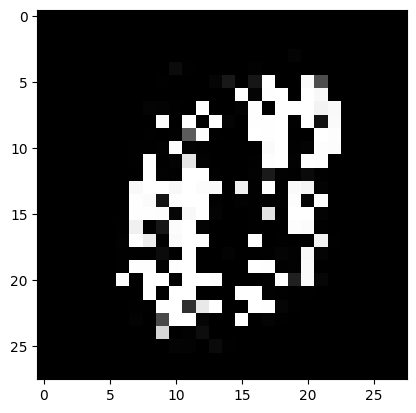

Epoch: 24550
loss_g: 0.9500609636306763 	loss_d: 1.3635660409927368
Epoch: 24600
loss_g: 0.8740106225013733 	loss_d: 1.203251838684082
Epoch: 24650
loss_g: 0.794323742389679 	loss_d: 1.624350666999817
Epoch: 24700
loss_g: 0.7455887198448181 	loss_d: 1.3992637395858765
Epoch: 24750
loss_g: 0.7225724458694458 	loss_d: 1.5988640785217285
Epoch: 24800
loss_g: 0.712256133556366 	loss_d: 1.5577956438064575
Epoch: 24850
loss_g: 0.7048612833023071 	loss_d: 1.5065410137176514
Epoch: 24900
loss_g: 0.6885660290718079 	loss_d: 1.5598880052566528
Epoch: 24950
loss_g: 0.6623955368995667 	loss_d: 1.664118766784668
Epoch: 25000
loss_g: 0.6368644833564758 	loss_d: 1.4583157300949097


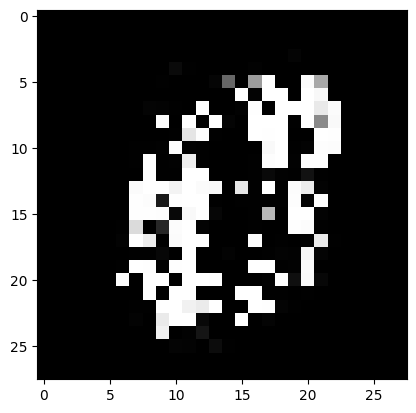

Epoch: 25050
loss_g: 0.6197584271430969 	loss_d: 1.8301883935928345
Epoch: 25100
loss_g: 0.611587405204773 	loss_d: 1.7507073879241943
Epoch: 25150
loss_g: 0.6105981469154358 	loss_d: 1.7977014780044556
Epoch: 25200
loss_g: 0.6147173047065735 	loss_d: 1.7419089078903198
Epoch: 25250
loss_g: 0.6222039461135864 	loss_d: 1.855678677558899
Epoch: 25300
loss_g: 0.6307851076126099 	loss_d: 1.739833116531372
Epoch: 25350
loss_g: 0.6390781402587891 	loss_d: 1.5616782903671265
Epoch: 25400
loss_g: 0.6464643478393555 	loss_d: 1.6956267356872559
Epoch: 25450
loss_g: 0.6516186594963074 	loss_d: 1.5996677875518799
Epoch: 25500
loss_g: 0.6547831296920776 	loss_d: 1.9579452276229858


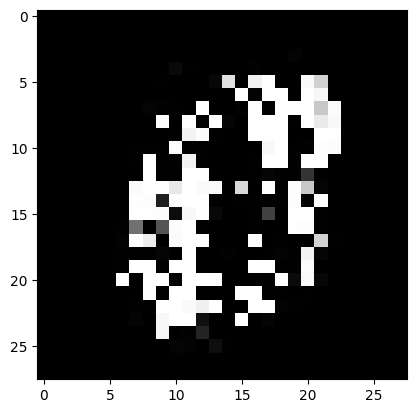

Epoch: 25550
loss_g: 0.6550969481468201 	loss_d: 1.4855376482009888
Epoch: 25600
loss_g: 0.6524995565414429 	loss_d: 1.803758978843689
Epoch: 25650
loss_g: 0.6469166278839111 	loss_d: 1.7492649555206299
Epoch: 25700
loss_g: 0.6381478309631348 	loss_d: 2.116851806640625
Epoch: 25750
loss_g: 0.62701016664505 	loss_d: 1.9683159589767456
Epoch: 25800
loss_g: 0.6143397092819214 	loss_d: 1.7704882621765137
Epoch: 25850
loss_g: 0.5998920202255249 	loss_d: 2.0197646617889404
Epoch: 25900
loss_g: 0.5846960544586182 	loss_d: 1.8161410093307495
Epoch: 25950
loss_g: 0.5697455406188965 	loss_d: 2.309307336807251
Epoch: 26000
loss_g: 0.5540381669998169 	loss_d: 1.9064991474151611


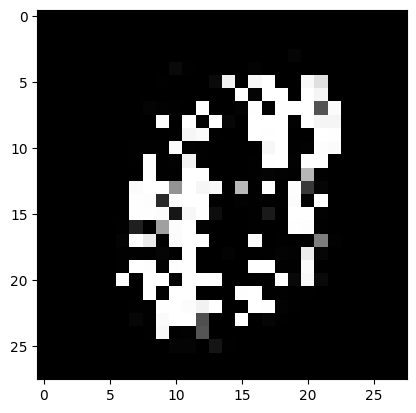

Epoch: 26050
loss_g: 0.5379201173782349 	loss_d: 1.7813218832015991
Epoch: 26100
loss_g: 0.5229647755622864 	loss_d: 2.0666232109069824
Epoch: 26150
loss_g: 0.5085520148277283 	loss_d: 1.498744249343872
Epoch: 26200
loss_g: 0.49801528453826904 	loss_d: 2.2292959690093994
Epoch: 26250
loss_g: 0.49177977442741394 	loss_d: 1.6622780561447144
Epoch: 26300
loss_g: 0.49120962619781494 	loss_d: 1.9549371004104614
Epoch: 26350
loss_g: 0.4936985969543457 	loss_d: 1.9868121147155762
Epoch: 26400
loss_g: 0.49572402238845825 	loss_d: 1.8296364545822144
Epoch: 26450
loss_g: 0.49896103143692017 	loss_d: 2.4832839965820312
Epoch: 26500
loss_g: 0.503732442855835 	loss_d: 2.1442651748657227


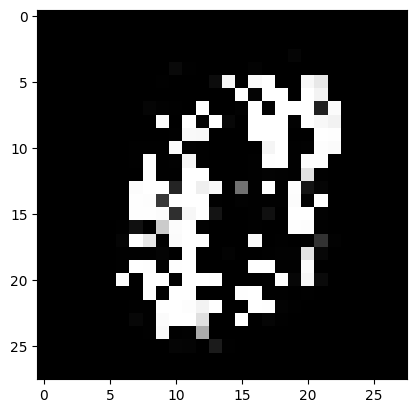

Epoch: 26550
loss_g: 0.5092083215713501 	loss_d: 2.0867364406585693
Epoch: 26600
loss_g: 0.5149064660072327 	loss_d: 1.7826809883117676
Epoch: 26650
loss_g: 0.5209519267082214 	loss_d: 2.009389877319336
Epoch: 26700
loss_g: 0.526631236076355 	loss_d: 2.042046070098877
Epoch: 26750
loss_g: 0.5316226482391357 	loss_d: 1.821540355682373
Epoch: 26800
loss_g: 0.5355969071388245 	loss_d: 1.992987871170044
Epoch: 26850
loss_g: 0.5380273461341858 	loss_d: 2.134153127670288
Epoch: 26900
loss_g: 0.5400398373603821 	loss_d: 1.8120417594909668
Epoch: 26950
loss_g: 0.5419650673866272 	loss_d: 1.9800843000411987
Epoch: 27000
loss_g: 0.5431058406829834 	loss_d: 1.7139009237289429


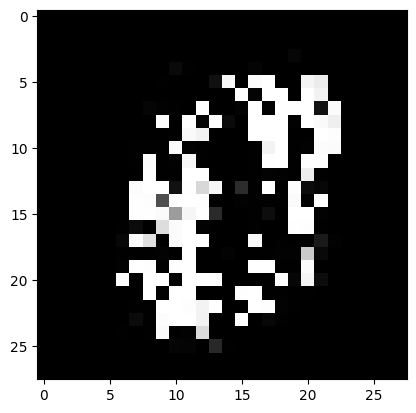

Epoch: 27050
loss_g: 0.5438516139984131 	loss_d: 2.1769492626190186
Epoch: 27100
loss_g: 0.5449541211128235 	loss_d: 1.8004952669143677
Epoch: 27150
loss_g: 0.5446117520332336 	loss_d: 1.9909433126449585
Epoch: 27200
loss_g: 0.5438390970230103 	loss_d: 1.927717685699463
Epoch: 27250
loss_g: 0.5414851903915405 	loss_d: 1.9108859300613403
Epoch: 27300
loss_g: 0.5376491546630859 	loss_d: 1.944063425064087
Epoch: 27350
loss_g: 0.5322330594062805 	loss_d: 2.0209555625915527
Epoch: 27400
loss_g: 0.5255902409553528 	loss_d: 1.7853095531463623
Epoch: 27450
loss_g: 0.5180165767669678 	loss_d: 2.1776492595672607
Epoch: 27500
loss_g: 0.5106569528579712 	loss_d: 2.0922000408172607


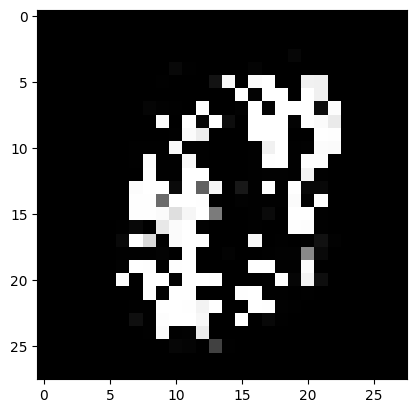

Epoch: 27550
loss_g: 0.5040464997291565 	loss_d: 2.1767477989196777
Epoch: 27600
loss_g: 0.49905264377593994 	loss_d: 2.0974605083465576
Epoch: 27650
loss_g: 0.49543407559394836 	loss_d: 2.238234043121338
Epoch: 27700
loss_g: 0.49342450499534607 	loss_d: 2.1262311935424805
Epoch: 27750
loss_g: 0.492086261510849 	loss_d: 1.9165089130401611
Epoch: 27800
loss_g: 0.49151870608329773 	loss_d: 2.0788753032684326
Epoch: 27850
loss_g: 0.49169644713401794 	loss_d: 1.9672629833221436
Epoch: 27900
loss_g: 0.4928690195083618 	loss_d: 2.394120216369629
Epoch: 27950
loss_g: 0.4941309988498688 	loss_d: 1.8619954586029053
Epoch: 28000
loss_g: 0.49553385376930237 	loss_d: 2.176194906234741


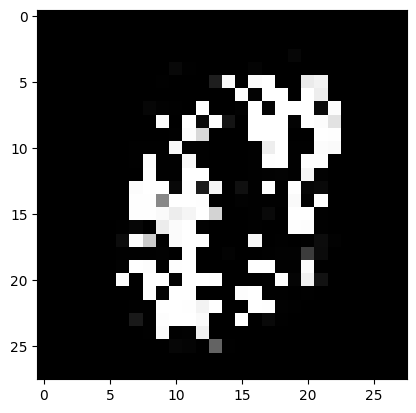

Epoch: 28050
loss_g: 0.4969881772994995 	loss_d: 2.123157501220703
Epoch: 28100
loss_g: 0.49811702966690063 	loss_d: 2.5274932384490967
Epoch: 28150
loss_g: 0.49833524227142334 	loss_d: 2.338547468185425
Epoch: 28200
loss_g: 0.4979740083217621 	loss_d: 2.0736184120178223
Epoch: 28250
loss_g: 0.4959777593612671 	loss_d: 2.346083164215088
Epoch: 28300
loss_g: 0.4926527440547943 	loss_d: 2.0961174964904785
Epoch: 28350
loss_g: 0.4878997802734375 	loss_d: 2.624577760696411
Epoch: 28400
loss_g: 0.4821358025074005 	loss_d: 2.169062614440918
Epoch: 28450
loss_g: 0.47543013095855713 	loss_d: 2.008793354034424
Epoch: 28500
loss_g: 0.4686279296875 	loss_d: 2.306793451309204


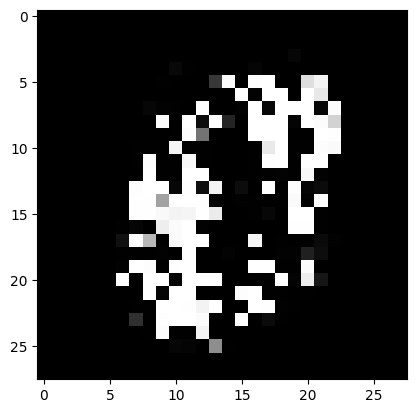

Epoch: 28550
loss_g: 0.4615589678287506 	loss_d: 1.6748650074005127
Epoch: 28600
loss_g: 0.45499318838119507 	loss_d: 2.4519600868225098
Epoch: 28650
loss_g: 0.44864386320114136 	loss_d: 1.8362419605255127
Epoch: 28700
loss_g: 0.4429081380367279 	loss_d: 2.180133819580078
Epoch: 28750
loss_g: 0.43688884377479553 	loss_d: 2.210625648498535
Epoch: 28800
loss_g: 0.43104851245880127 	loss_d: 2.0455093383789062
Epoch: 28850
loss_g: 0.4249815344810486 	loss_d: 2.7539312839508057
Epoch: 28900
loss_g: 0.41883689165115356 	loss_d: 2.4198522567749023
Epoch: 28950
loss_g: 0.41228461265563965 	loss_d: 2.3663623332977295
Epoch: 29000
loss_g: 0.405129998922348 	loss_d: 2.0709943771362305


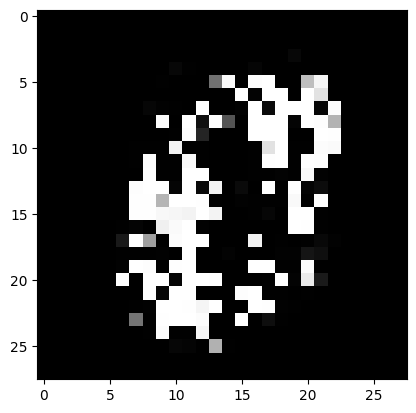

Epoch: 29050
loss_g: 0.39780038595199585 	loss_d: 2.3433878421783447
Epoch: 29100
loss_g: 0.39043131470680237 	loss_d: 2.399989604949951
Epoch: 29150
loss_g: 0.38348811864852905 	loss_d: 2.1895787715911865
Epoch: 29200
loss_g: 0.3766949772834778 	loss_d: 2.4030706882476807
Epoch: 29250
loss_g: 0.37025800347328186 	loss_d: 2.56264591217041
Epoch: 29300
loss_g: 0.36416780948638916 	loss_d: 2.2245445251464844
Epoch: 29350
loss_g: 0.3582959771156311 	loss_d: 2.429205894470215
Epoch: 29400
loss_g: 0.35300499200820923 	loss_d: 2.150975465774536
Epoch: 29450
loss_g: 0.3480744957923889 	loss_d: 2.6742186546325684
Epoch: 29500
loss_g: 0.34333258867263794 	loss_d: 2.2631654739379883


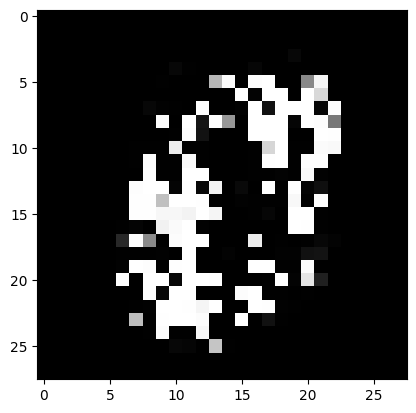

Epoch: 29550
loss_g: 0.338728129863739 	loss_d: 2.4659037590026855
Epoch: 29600
loss_g: 0.33461683988571167 	loss_d: 2.40767502784729
Epoch: 29650
loss_g: 0.3307135999202728 	loss_d: 2.4176948070526123
Epoch: 29700
loss_g: 0.3271656334400177 	loss_d: 2.448254346847534
Epoch: 29750
loss_g: 0.3235771954059601 	loss_d: 2.5266165733337402
Epoch: 29800
loss_g: 0.3198179602622986 	loss_d: 2.2850706577301025
Epoch: 29850
loss_g: 0.31627216935157776 	loss_d: 2.6873397827148438
Epoch: 29900
loss_g: 0.31308987736701965 	loss_d: 2.599872589111328
Epoch: 29950
loss_g: 0.3097122013568878 	loss_d: 2.6972737312316895
Epoch: 30000
loss_g: 0.3063797950744629 	loss_d: 2.6037373542785645


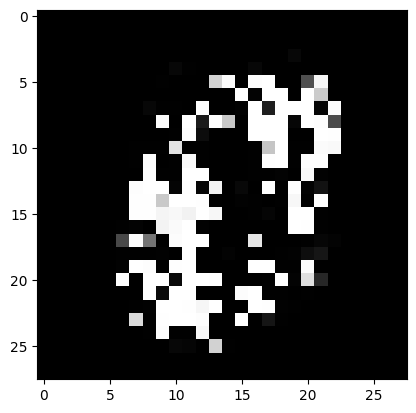

Epoch: 30050
loss_g: 0.30293580889701843 	loss_d: 2.755531072616577
Epoch: 30100
loss_g: 0.2995605170726776 	loss_d: 2.648266077041626
Epoch: 30150
loss_g: 0.29604372382164 	loss_d: 2.422840118408203
Epoch: 30200
loss_g: 0.2924264371395111 	loss_d: 2.6039881706237793
Epoch: 30250
loss_g: 0.28855082392692566 	loss_d: 2.4928789138793945
Epoch: 30300
loss_g: 0.28453993797302246 	loss_d: 2.9698941707611084
Epoch: 30350
loss_g: 0.280100554227829 	loss_d: 2.4257850646972656
Epoch: 30400
loss_g: 0.27529993653297424 	loss_d: 2.754379987716675
Epoch: 30450
loss_g: 0.2703993618488312 	loss_d: 2.7240896224975586
Epoch: 30500
loss_g: 0.26514604687690735 	loss_d: 3.1697027683258057


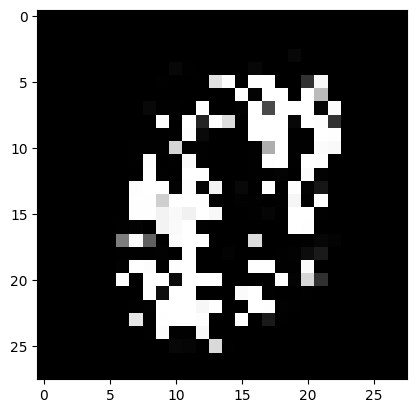

Epoch: 30550
loss_g: 0.25957193970680237 	loss_d: 2.9888455867767334
Epoch: 30600
loss_g: 0.25389963388442993 	loss_d: 2.7183029651641846
Epoch: 30650
loss_g: 0.24810239672660828 	loss_d: 3.0273778438568115
Epoch: 30700
loss_g: 0.24214614927768707 	loss_d: 2.7751197814941406
Epoch: 30750
loss_g: 0.23627951741218567 	loss_d: 3.3445565700531006
Epoch: 30800
loss_g: 0.23065732419490814 	loss_d: 2.8804850578308105
Epoch: 30850
loss_g: 0.22501572966575623 	loss_d: 2.7184762954711914
Epoch: 30900
loss_g: 0.21983718872070312 	loss_d: 3.0375611782073975
Epoch: 30950
loss_g: 0.21482311189174652 	loss_d: 2.3867454528808594
Epoch: 31000
loss_g: 0.21043798327445984 	loss_d: 3.202533483505249


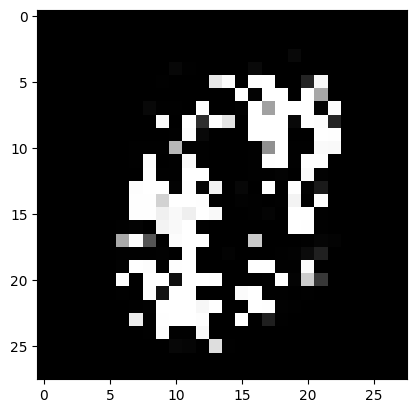

Epoch: 31050
loss_g: 0.206008642911911 	loss_d: 2.567882537841797
Epoch: 31100
loss_g: 0.20206063985824585 	loss_d: 2.9405436515808105
Epoch: 31150
loss_g: 0.1984928995370865 	loss_d: 2.970212697982788
Epoch: 31200
loss_g: 0.19497531652450562 	loss_d: 2.7979886531829834
Epoch: 31250
loss_g: 0.1918211728334427 	loss_d: 3.533132791519165
Epoch: 31300
loss_g: 0.18881763517856598 	loss_d: 3.193344831466675
Epoch: 31350
loss_g: 0.1858643889427185 	loss_d: 3.1302378177642822
Epoch: 31400
loss_g: 0.183303102850914 	loss_d: 2.827702522277832
Epoch: 31450
loss_g: 0.18052726984024048 	loss_d: 3.11126446723938
Epoch: 31500
loss_g: 0.17806535959243774 	loss_d: 3.1661715507507324


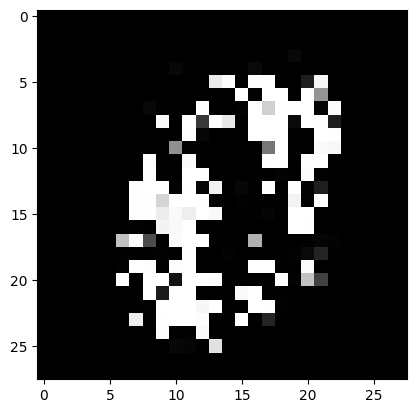

Epoch: 31550
loss_g: 0.17577657103538513 	loss_d: 2.946495532989502
Epoch: 31600
loss_g: 0.17325662076473236 	loss_d: 3.1679883003234863
Epoch: 31650
loss_g: 0.1712246835231781 	loss_d: 3.3271937370300293
Epoch: 31700
loss_g: 0.16890518367290497 	loss_d: 2.9659841060638428
Epoch: 31750
loss_g: 0.16678254306316376 	loss_d: 3.1834821701049805
Epoch: 31800
loss_g: 0.1646641194820404 	loss_d: 2.8876240253448486
Epoch: 31850
loss_g: 0.16260290145874023 	loss_d: 3.437093734741211
Epoch: 31900
loss_g: 0.16059599816799164 	loss_d: 2.9994428157806396
Epoch: 31950
loss_g: 0.15869352221488953 	loss_d: 3.201629161834717
Epoch: 32000
loss_g: 0.15681464970111847 	loss_d: 3.142671823501587


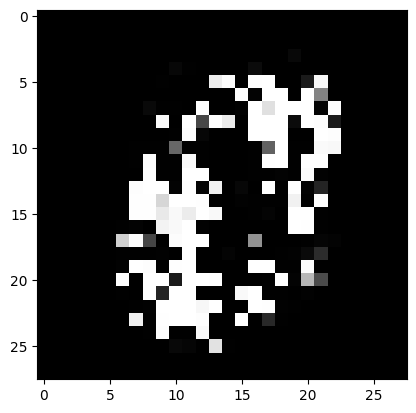

Epoch: 32050
loss_g: 0.15488748252391815 	loss_d: 3.163755178451538
Epoch: 32100
loss_g: 0.15310172736644745 	loss_d: 3.1908273696899414
Epoch: 32150
loss_g: 0.15112897753715515 	loss_d: 3.2702865600585938
Epoch: 32200
loss_g: 0.14916472136974335 	loss_d: 3.0282630920410156
Epoch: 32250
loss_g: 0.14725644886493683 	loss_d: 3.4412636756896973
Epoch: 32300
loss_g: 0.14538641273975372 	loss_d: 3.355599880218506
Epoch: 32350
loss_g: 0.14352943003177643 	loss_d: 3.464607000350952
Epoch: 32400
loss_g: 0.14168821275234222 	loss_d: 3.364471673965454
Epoch: 32450
loss_g: 0.13999544084072113 	loss_d: 3.520699977874756
Epoch: 32500
loss_g: 0.13829249143600464 	loss_d: 3.4131686687469482


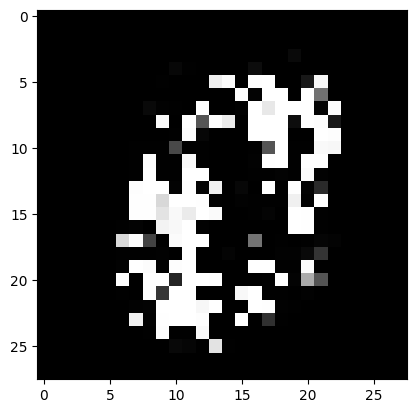

Epoch: 32550
loss_g: 0.1365634948015213 	loss_d: 3.1766271591186523
Epoch: 32600
loss_g: 0.13488613069057465 	loss_d: 3.362300395965576
Epoch: 32650
loss_g: 0.13312529027462006 	loss_d: 3.2459716796875
Epoch: 32700
loss_g: 0.13151851296424866 	loss_d: 3.7428436279296875
Epoch: 32750
loss_g: 0.12991856038570404 	loss_d: 3.180025815963745
Epoch: 32800
loss_g: 0.12824520468711853 	loss_d: 3.5044655799865723
Epoch: 32850
loss_g: 0.126670241355896 	loss_d: 3.4722342491149902
Epoch: 32900
loss_g: 0.12518912553787231 	loss_d: 3.9246134757995605
Epoch: 32950
loss_g: 0.12356577813625336 	loss_d: 3.7309694290161133
Epoch: 33000
loss_g: 0.12201788276433945 	loss_d: 3.4396920204162598


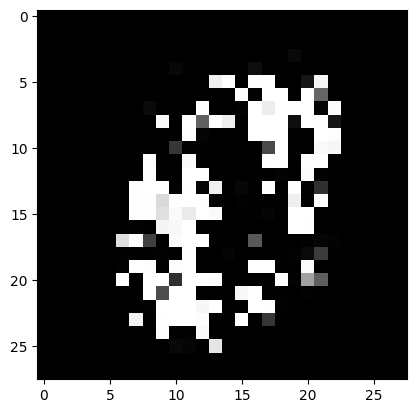

Epoch: 33050
loss_g: 0.12052295356988907 	loss_d: 3.750499963760376
Epoch: 33100
loss_g: 0.11891863495111465 	loss_d: 3.4758925437927246
Epoch: 33150
loss_g: 0.11746665835380554 	loss_d: 4.0510735511779785
Epoch: 33200
loss_g: 0.1159265860915184 	loss_d: 3.564263105392456
Epoch: 33250
loss_g: 0.11448473483324051 	loss_d: 3.386373281478882
Epoch: 33300
loss_g: 0.11302583664655685 	loss_d: 3.7009472846984863
Epoch: 33350
loss_g: 0.11156120151281357 	loss_d: 3.028740644454956
Epoch: 33400
loss_g: 0.11006922274827957 	loss_d: 3.8535826206207275
Epoch: 33450
loss_g: 0.1086561381816864 	loss_d: 3.1979620456695557
Epoch: 33500
loss_g: 0.10716833174228668 	loss_d: 3.5778117179870605


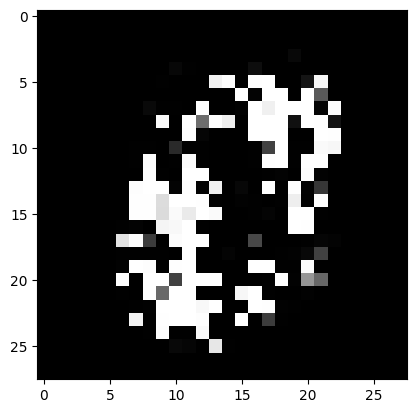

Epoch: 33550
loss_g: 0.10588956624269485 	loss_d: 3.5990397930145264
Epoch: 33600
loss_g: 0.10445749759674072 	loss_d: 3.4168593883514404
Epoch: 33650
loss_g: 0.10312963277101517 	loss_d: 4.159337043762207
Epoch: 33700
loss_g: 0.10174842923879623 	loss_d: 3.814724922180176
Epoch: 33750
loss_g: 0.10040529817342758 	loss_d: 3.7425732612609863
Epoch: 33800
loss_g: 0.09915738552808762 	loss_d: 3.4374513626098633
Epoch: 33850
loss_g: 0.09775920957326889 	loss_d: 3.7260420322418213
Epoch: 33900
loss_g: 0.09666796773672104 	loss_d: 3.781146287918091
Epoch: 33950
loss_g: 0.0953686386346817 	loss_d: 3.5573341846466064
Epoch: 34000
loss_g: 0.094169020652771 	loss_d: 3.7824482917785645


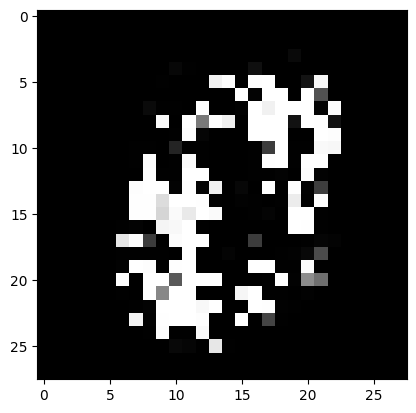

Epoch: 34050
loss_g: 0.09299291670322418 	loss_d: 3.9446170330047607
Epoch: 34100
loss_g: 0.09180954098701477 	loss_d: 3.571291208267212
Epoch: 34150
loss_g: 0.09067336469888687 	loss_d: 3.795606851577759
Epoch: 34200
loss_g: 0.08951617777347565 	loss_d: 3.4920737743377686
Epoch: 34250
loss_g: 0.08838857710361481 	loss_d: 4.0539422035217285
Epoch: 34300
loss_g: 0.08733126521110535 	loss_d: 3.6051647663116455
Epoch: 34350
loss_g: 0.08638694882392883 	loss_d: 3.804196357727051
Epoch: 34400
loss_g: 0.08538812398910522 	loss_d: 3.746084213256836
Epoch: 34450
loss_g: 0.08442014455795288 	loss_d: 3.7732839584350586
Epoch: 34500
loss_g: 0.08345549553632736 	loss_d: 3.7973029613494873


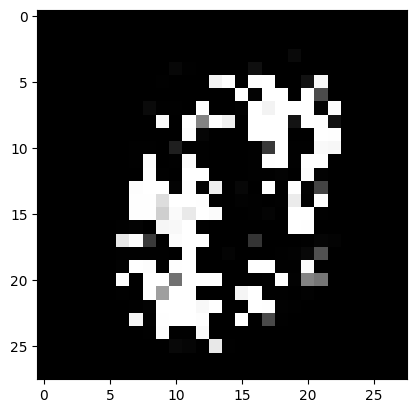

Epoch: 34550
loss_g: 0.08245950192213058 	loss_d: 3.8742284774780273
Epoch: 34600
loss_g: 0.08151863515377045 	loss_d: 3.629727602005005
Epoch: 34650
loss_g: 0.080711230635643 	loss_d: 4.042577743530273
Epoch: 34700
loss_g: 0.07984412461519241 	loss_d: 3.9556031227111816
Epoch: 34750
loss_g: 0.07905285060405731 	loss_d: 4.0672383308410645
Epoch: 34800
loss_g: 0.07817786186933517 	loss_d: 3.960430860519409
Epoch: 34850
loss_g: 0.07747971266508102 	loss_d: 4.11643648147583
Epoch: 34900
loss_g: 0.07666578888893127 	loss_d: 4.005265712738037
Epoch: 34950
loss_g: 0.0759025514125824 	loss_d: 3.761706829071045
Epoch: 35000
loss_g: 0.07526099681854248 	loss_d: 3.946049213409424


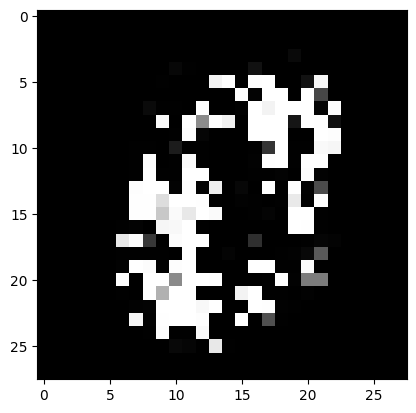

Epoch: 35050
loss_g: 0.07456699013710022 	loss_d: 3.823335886001587
Epoch: 35100
loss_g: 0.0738929808139801 	loss_d: 4.326377868652344
Epoch: 35150
loss_g: 0.0731295496225357 	loss_d: 3.7551932334899902
Epoch: 35200
loss_g: 0.07249339669942856 	loss_d: 4.07333517074585
Epoch: 35250
loss_g: 0.07184115797281265 	loss_d: 4.040499210357666
Epoch: 35300
loss_g: 0.0712231993675232 	loss_d: 4.4941630363464355
Epoch: 35350
loss_g: 0.07062754034996033 	loss_d: 4.2925262451171875
Epoch: 35400
loss_g: 0.07010073214769363 	loss_d: 3.9937915802001953
Epoch: 35450
loss_g: 0.0694376528263092 	loss_d: 4.303285121917725
Epoch: 35500
loss_g: 0.06895097345113754 	loss_d: 4.019437313079834


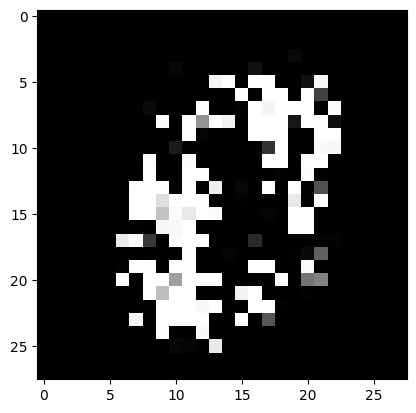

Epoch: 35550
loss_g: 0.0683489739894867 	loss_d: 4.598226547241211
Epoch: 35600
loss_g: 0.06785403192043304 	loss_d: 4.103119850158691
Epoch: 35650
loss_g: 0.06732158362865448 	loss_d: 3.9157466888427734
Epoch: 35700
loss_g: 0.0668036937713623 	loss_d: 4.225983619689941
Epoch: 35750
loss_g: 0.06633974611759186 	loss_d: 3.5444018840789795
Epoch: 35800
loss_g: 0.06572992354631424 	loss_d: 4.3708014488220215
Epoch: 35850
loss_g: 0.06522450596094131 	loss_d: 3.70505428314209
Epoch: 35900
loss_g: 0.0647185668349266 	loss_d: 4.083491802215576
Epoch: 35950
loss_g: 0.06436235457658768 	loss_d: 4.097899913787842
Epoch: 36000
loss_g: 0.06394929438829422 	loss_d: 3.907113552093506


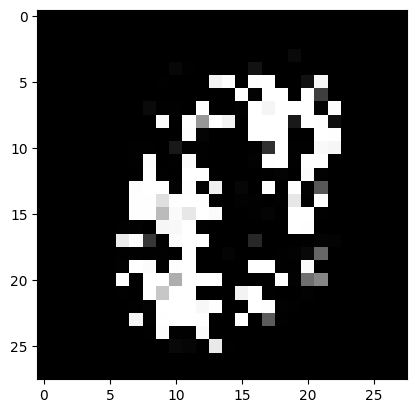

Epoch: 36050
loss_g: 0.06344849616289139 	loss_d: 4.648575305938721
Epoch: 36100
loss_g: 0.06302624195814133 	loss_d: 4.296001434326172
Epoch: 36150
loss_g: 0.06252849847078323 	loss_d: 4.214806079864502
Epoch: 36200
loss_g: 0.062047794461250305 	loss_d: 3.9025800228118896
Epoch: 36250
loss_g: 0.061731647700071335 	loss_d: 4.186551570892334
Epoch: 36300
loss_g: 0.06138408184051514 	loss_d: 4.2365312576293945
Epoch: 36350
loss_g: 0.06095072627067566 	loss_d: 4.007192611694336
Epoch: 36400
loss_g: 0.06053740903735161 	loss_d: 4.227210998535156
Epoch: 36450
loss_g: 0.0601436123251915 	loss_d: 4.382842540740967
Epoch: 36500
loss_g: 0.05972747504711151 	loss_d: 4.0000176429748535


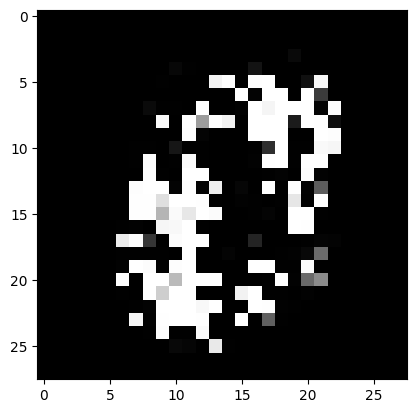

Epoch: 36550
loss_g: 0.05939604714512825 	loss_d: 4.220885276794434
Epoch: 36600
loss_g: 0.05904138460755348 	loss_d: 3.909578800201416
Epoch: 36650
loss_g: 0.05868435651063919 	loss_d: 4.469249725341797
Epoch: 36700
loss_g: 0.05837066471576691 	loss_d: 4.008426666259766
Epoch: 36750
loss_g: 0.057994335889816284 	loss_d: 4.202483654022217
Epoch: 36800
loss_g: 0.057683300226926804 	loss_d: 4.13791561126709
Epoch: 36850
loss_g: 0.05744500458240509 	loss_d: 4.1621856689453125
Epoch: 36900
loss_g: 0.05706818029284477 	loss_d: 4.178948879241943
Epoch: 36950
loss_g: 0.056887976825237274 	loss_d: 4.250377178192139
Epoch: 37000
loss_g: 0.05637019872665405 	loss_d: 3.999112367630005


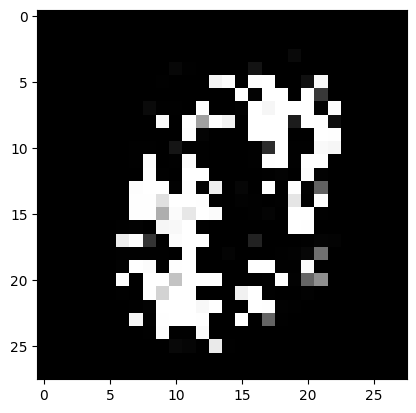

Epoch: 37050
loss_g: 0.05609110742807388 	loss_d: 4.410367012023926
Epoch: 37100
loss_g: 0.055763181298971176 	loss_d: 4.319676876068115
Epoch: 37150
loss_g: 0.0555962398648262 	loss_d: 4.424620628356934
Epoch: 37200
loss_g: 0.055221881717443466 	loss_d: 4.3121232986450195
Epoch: 37250
loss_g: 0.05494724586606026 	loss_d: 4.462094306945801
Epoch: 37300
loss_g: 0.05468256399035454 	loss_d: 4.348644256591797
Epoch: 37350
loss_g: 0.054407887160778046 	loss_d: 4.096816539764404
Epoch: 37400
loss_g: 0.05409878492355347 	loss_d: 4.277803897857666
Epoch: 37450
loss_g: 0.053814597427845 	loss_d: 4.149092674255371
Epoch: 37500
loss_g: 0.053606681525707245 	loss_d: 4.654006004333496


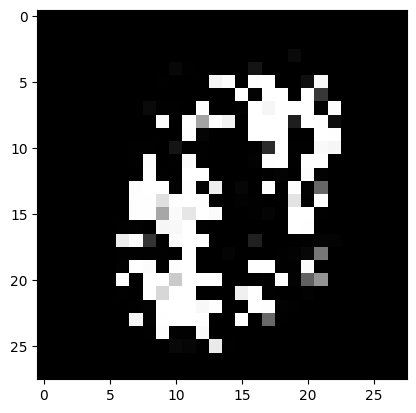

Epoch: 37550
loss_g: 0.0532526895403862 	loss_d: 4.074296951293945
Epoch: 37600
loss_g: 0.05304648354649544 	loss_d: 4.3883280754089355
Epoch: 37650
loss_g: 0.05271322280168533 	loss_d: 4.3502607345581055
Epoch: 37700
loss_g: 0.0525248721241951 	loss_d: 4.802548408508301
Epoch: 37750
loss_g: 0.05228344723582268 	loss_d: 4.598161697387695
Epoch: 37800
loss_g: 0.05200134217739105 	loss_d: 4.290700435638428
Epoch: 37850
loss_g: 0.05176536738872528 	loss_d: 4.6018452644348145
Epoch: 37900
loss_g: 0.05153622478246689 	loss_d: 4.311288356781006
Epoch: 37950
loss_g: 0.0513264499604702 	loss_d: 4.889559268951416
Epoch: 38000
loss_g: 0.05102833732962608 	loss_d: 4.3895263671875


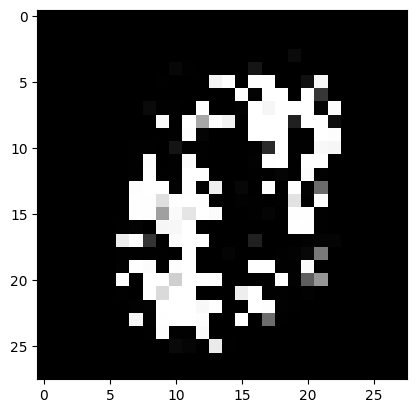

Epoch: 38050
loss_g: 0.05082719773054123 	loss_d: 4.197870254516602
Epoch: 38100
loss_g: 0.0505819208920002 	loss_d: 4.507035255432129
Epoch: 38150
loss_g: 0.05037333816289902 	loss_d: 3.8184967041015625
Epoch: 38200
loss_g: 0.050178974866867065 	loss_d: 4.645004749298096
Epoch: 38250
loss_g: 0.0498725101351738 	loss_d: 3.9715054035186768
Epoch: 38300
loss_g: 0.04972065985202789 	loss_d: 4.349075794219971
Epoch: 38350
loss_g: 0.0494546964764595 	loss_d: 4.3613176345825195
Epoch: 38400
loss_g: 0.049147214740514755 	loss_d: 4.166601657867432
Epoch: 38450
loss_g: 0.049031034111976624 	loss_d: 4.906668186187744
Epoch: 38500
loss_g: 0.048790138214826584 	loss_d: 4.553091049194336


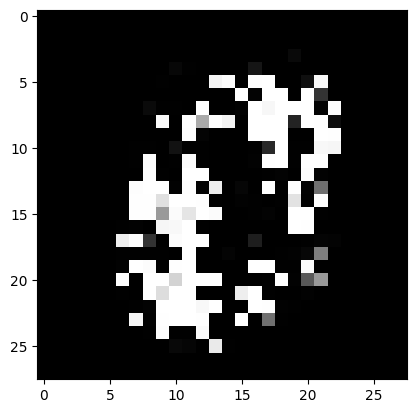

Epoch: 38550
loss_g: 0.04855514317750931 	loss_d: 4.46707820892334
Epoch: 38600
loss_g: 0.04837638884782791 	loss_d: 4.151607513427734
Epoch: 38650
loss_g: 0.048107437789440155 	loss_d: 4.436820983886719
Epoch: 38700
loss_g: 0.04798445105552673 	loss_d: 4.482785701751709
Epoch: 38750
loss_g: 0.04773670434951782 	loss_d: 4.249825477600098
Epoch: 38800
loss_g: 0.04757199063897133 	loss_d: 4.469831943511963
Epoch: 38850
loss_g: 0.04730170965194702 	loss_d: 4.62369966506958
Epoch: 38900
loss_g: 0.04714484140276909 	loss_d: 4.237877368927002
Epoch: 38950
loss_g: 0.0469062365591526 	loss_d: 4.457363128662109
Epoch: 39000
loss_g: 0.04675109684467316 	loss_d: 4.14005184173584


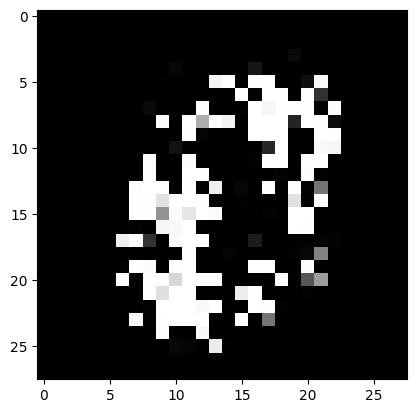

Epoch: 39050
loss_g: 0.04649997130036354 	loss_d: 4.702640533447266
Epoch: 39100
loss_g: 0.046397533267736435 	loss_d: 4.239781379699707
Epoch: 39150
loss_g: 0.04616124927997589 	loss_d: 4.432018280029297
Epoch: 39200
loss_g: 0.04602135717868805 	loss_d: 4.36506986618042
Epoch: 39250
loss_g: 0.04578511044383049 	loss_d: 4.387229919433594
Epoch: 39300
loss_g: 0.04559030011296272 	loss_d: 4.40138053894043
Epoch: 39350
loss_g: 0.04540363326668739 	loss_d: 4.472382068634033
Epoch: 39400
loss_g: 0.04521477594971657 	loss_d: 4.219211101531982
Epoch: 39450
loss_g: 0.045045383274555206 	loss_d: 4.6286516189575195
Epoch: 39500
loss_g: 0.04491100832819939 	loss_d: 4.533679008483887


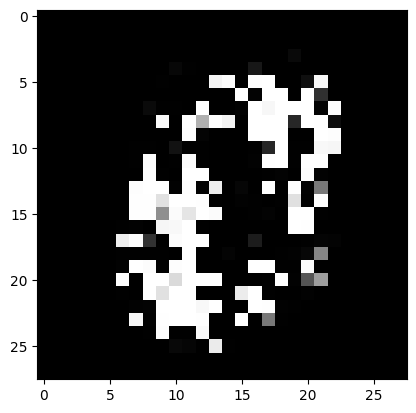

Epoch: 39550
loss_g: 0.04468066245317459 	loss_d: 4.6411967277526855
Epoch: 39600
loss_g: 0.04451967030763626 	loss_d: 4.528227806091309
Epoch: 39650
loss_g: 0.04433203116059303 	loss_d: 4.6749114990234375
Epoch: 39700
loss_g: 0.044132452458143234 	loss_d: 4.558676242828369
Epoch: 39750
loss_g: 0.04399976506829262 	loss_d: 4.305644989013672
Epoch: 39800
loss_g: 0.04385768249630928 	loss_d: 4.485147476196289
Epoch: 39850
loss_g: 0.043675992637872696 	loss_d: 4.356742858886719
Epoch: 39900
loss_g: 0.0435757152736187 	loss_d: 4.858545303344727
Epoch: 39950
loss_g: 0.04337289184331894 	loss_d: 4.278136730194092
Epoch: 40000
loss_g: 0.043204791843891144 	loss_d: 4.591952800750732


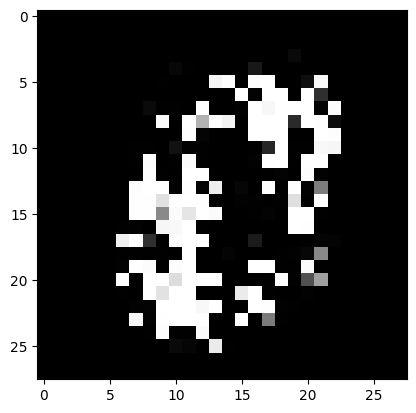

Epoch: 40050
loss_g: 0.04303242266178131 	loss_d: 4.553452491760254
Epoch: 40100
loss_g: 0.04285411909222603 	loss_d: 5.00571346282959
Epoch: 40150
loss_g: 0.042733773589134216 	loss_d: 4.796786785125732
Epoch: 40200
loss_g: 0.042546261101961136 	loss_d: 4.490808486938477
Epoch: 40250
loss_g: 0.042422011494636536 	loss_d: 4.800186634063721
Epoch: 40300
loss_g: 0.042284660041332245 	loss_d: 4.507448673248291
Epoch: 40350
loss_g: 0.042172662913799286 	loss_d: 5.084397792816162
Epoch: 40400
loss_g: 0.04196865111589432 	loss_d: 4.580155849456787
Epoch: 40450
loss_g: 0.041788499802351 	loss_d: 4.3897247314453125
Epoch: 40500
loss_g: 0.041702751070261 	loss_d: 4.698967933654785


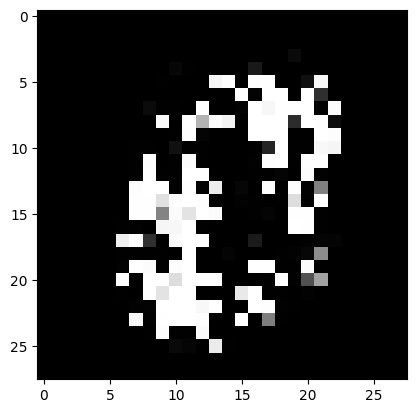

Epoch: 40550
loss_g: 0.04149125516414642 	loss_d: 4.007824897766113
Epoch: 40600
loss_g: 0.04137938469648361 	loss_d: 4.834033489227295
Epoch: 40650
loss_g: 0.04127955809235573 	loss_d: 4.160183429718018
Epoch: 40700
loss_g: 0.041073523461818695 	loss_d: 4.5370025634765625
Epoch: 40750
loss_g: 0.04095057025551796 	loss_d: 4.546581268310547
Epoch: 40800
loss_g: 0.04081270098686218 	loss_d: 4.35147762298584
Epoch: 40850
loss_g: 0.04068577289581299 	loss_d: 5.089688777923584
Epoch: 40900
loss_g: 0.04053439944982529 	loss_d: 4.735358238220215
Epoch: 40950
loss_g: 0.04044576734304428 	loss_d: 4.646420001983643
Epoch: 41000
loss_g: 0.04029158502817154 	loss_d: 4.332691669464111


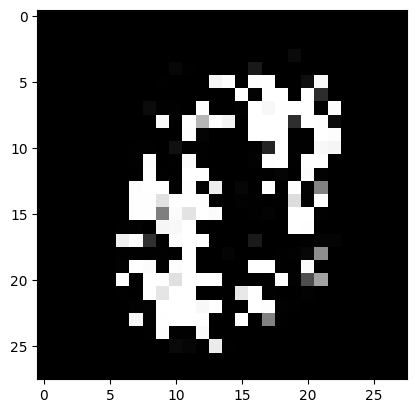

Epoch: 41050
loss_g: 0.04014967009425163 	loss_d: 4.614436626434326
Epoch: 41100
loss_g: 0.040057048201560974 	loss_d: 4.660780906677246
Epoch: 41150
loss_g: 0.039933137595653534 	loss_d: 4.426639556884766
Epoch: 41200
loss_g: 0.03981790319085121 	loss_d: 4.645049095153809
Epoch: 41250
loss_g: 0.039605990052223206 	loss_d: 4.798564910888672
Epoch: 41300
loss_g: 0.03953453153371811 	loss_d: 4.410020351409912
Epoch: 41350
loss_g: 0.03939484804868698 	loss_d: 4.629914283752441
Epoch: 41400
loss_g: 0.03930596262216568 	loss_d: 4.31236457824707
Epoch: 41450
loss_g: 0.039130959659814835 	loss_d: 4.873551368713379
Epoch: 41500
loss_g: 0.0390310101211071 	loss_d: 4.408121585845947


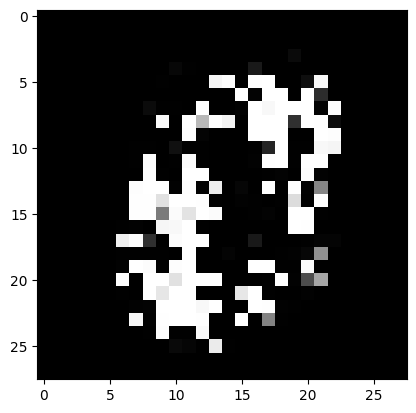

Epoch: 41550
loss_g: 0.03889821469783783 	loss_d: 4.598320960998535
Epoch: 41600
loss_g: 0.03876551240682602 	loss_d: 4.5308356285095215
Epoch: 41650
loss_g: 0.03863901644945145 	loss_d: 4.553516864776611
Epoch: 41700
loss_g: 0.038531526923179626 	loss_d: 4.567860126495361
Epoch: 41750
loss_g: 0.03842979297041893 	loss_d: 4.6377644538879395
Epoch: 41800
loss_g: 0.038286495953798294 	loss_d: 4.382379531860352
Epoch: 41850
loss_g: 0.038197245448827744 	loss_d: 4.79058837890625
Epoch: 41900
loss_g: 0.03809246048331261 	loss_d: 4.696654796600342
Epoch: 41950
loss_g: 0.037945255637168884 	loss_d: 4.802689552307129
Epoch: 42000
loss_g: 0.03783369064331055 	loss_d: 4.685925483703613


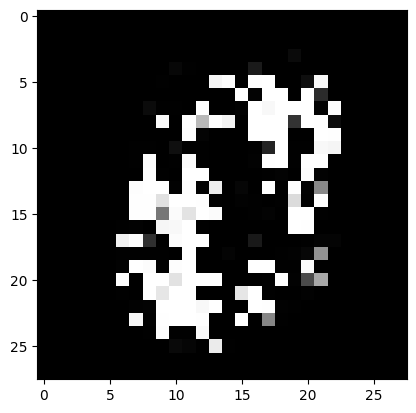

Epoch: 42050
loss_g: 0.03777223825454712 	loss_d: 4.833135604858398
Epoch: 42100
loss_g: 0.03759175166487694 	loss_d: 4.716250896453857
Epoch: 42150
loss_g: 0.037573542445898056 	loss_d: 4.462741374969482
Epoch: 42200
loss_g: 0.037430863827466965 	loss_d: 4.642139911651611
Epoch: 42250
loss_g: 0.0372631698846817 	loss_d: 4.5112528800964355
Epoch: 42300
loss_g: 0.037217967212200165 	loss_d: 5.012963771820068
Epoch: 42350
loss_g: 0.037119172513484955 	loss_d: 4.431424140930176
Epoch: 42400
loss_g: 0.03698994964361191 	loss_d: 4.742915630340576
Epoch: 42450
loss_g: 0.03693178668618202 	loss_d: 4.7051568031311035
Epoch: 42500
loss_g: 0.036795035004615784 	loss_d: 5.15521764755249


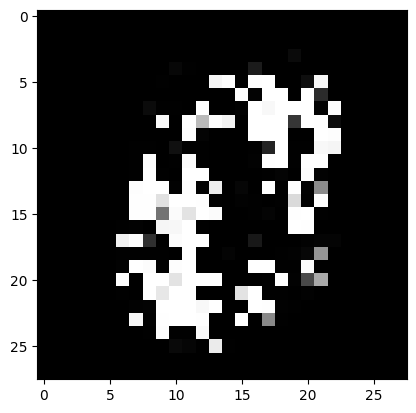

Epoch: 42550
loss_g: 0.03668561205267906 	loss_d: 4.946794509887695
Epoch: 42600
loss_g: 0.03652646392583847 	loss_d: 4.64032506942749
Epoch: 42650
loss_g: 0.03652510046958923 	loss_d: 4.948280334472656
Epoch: 42700
loss_g: 0.03640007600188255 	loss_d: 4.653304100036621
Epoch: 42750
loss_g: 0.03630192577838898 	loss_d: 5.231143474578857
Epoch: 42800
loss_g: 0.03626501187682152 	loss_d: 4.726810932159424
Epoch: 42850
loss_g: 0.03608609363436699 	loss_d: 4.534029483795166
Epoch: 42900
loss_g: 0.03596958518028259 	loss_d: 4.841733455657959
Epoch: 42950
loss_g: 0.03592543303966522 	loss_d: 4.14952278137207
Epoch: 43000
loss_g: 0.0358702652156353 	loss_d: 4.9748125076293945


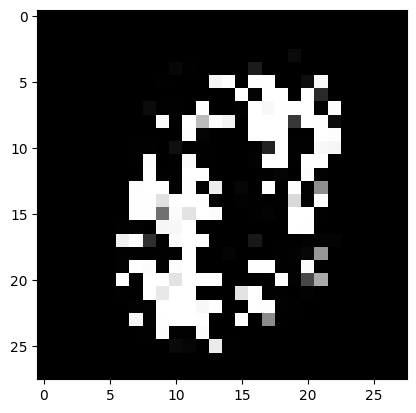

Epoch: 43050
loss_g: 0.03572842478752136 	loss_d: 4.301384925842285
Epoch: 43100
loss_g: 0.035664740949869156 	loss_d: 4.676199913024902
Epoch: 43150
loss_g: 0.03555002436041832 	loss_d: 4.686344623565674
Epoch: 43200
loss_g: 0.035452380776405334 	loss_d: 4.489938259124756
Epoch: 43250
loss_g: 0.03536727651953697 	loss_d: 5.227305889129639
Epoch: 43300
loss_g: 0.03526832535862923 	loss_d: 4.872010707855225
Epoch: 43350
loss_g: 0.03521740064024925 	loss_d: 4.783975601196289
Epoch: 43400
loss_g: 0.03512800484895706 	loss_d: 4.466907501220703
Epoch: 43450
loss_g: 0.03502935171127319 	loss_d: 4.750335693359375
Epoch: 43500
loss_g: 0.03489585965871811 	loss_d: 4.7954301834106445


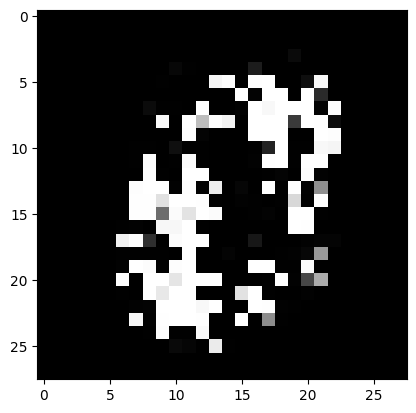

Epoch: 43550
loss_g: 0.034862179309129715 	loss_d: 4.558523178100586
Epoch: 43600
loss_g: 0.03475406393408775 	loss_d: 4.777917861938477
Epoch: 43650
loss_g: 0.034631870687007904 	loss_d: 4.931576251983643
Epoch: 43700
loss_g: 0.03455737978219986 	loss_d: 4.542324066162109
Epoch: 43750
loss_g: 0.03447003290057182 	loss_d: 4.760369300842285
Epoch: 43800
loss_g: 0.03445804864168167 	loss_d: 4.441221237182617
Epoch: 43850
loss_g: 0.03437373414635658 	loss_d: 5.003011703491211
Epoch: 43900
loss_g: 0.03424154594540596 	loss_d: 4.537032127380371
Epoch: 43950
loss_g: 0.03418615832924843 	loss_d: 4.726876258850098
Epoch: 44000
loss_g: 0.0341162346303463 	loss_d: 4.659371852874756


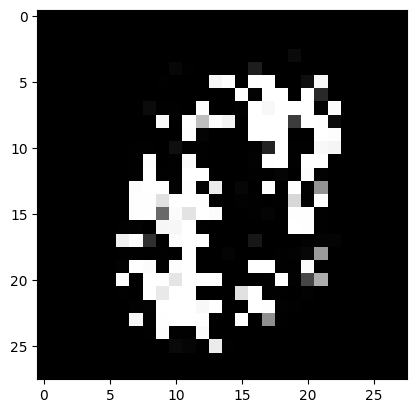

Epoch: 44050
loss_g: 0.03400753438472748 	loss_d: 4.6798810958862305
Epoch: 44100
loss_g: 0.03390461951494217 	loss_d: 4.692874908447266
Epoch: 44150
loss_g: 0.03381054103374481 	loss_d: 4.761677265167236
Epoch: 44200
loss_g: 0.03380730375647545 	loss_d: 4.506036281585693
Epoch: 44250
loss_g: 0.03366827964782715 	loss_d: 4.9132914543151855
Epoch: 44300
loss_g: 0.033608127385377884 	loss_d: 4.82027530670166
Epoch: 44350
loss_g: 0.033547937870025635 	loss_d: 4.924583911895752
Epoch: 44400
loss_g: 0.03345901519060135 	loss_d: 4.808409690856934
Epoch: 44450
loss_g: 0.03340259566903114 	loss_d: 4.954814434051514
Epoch: 44500
loss_g: 0.03331751748919487 	loss_d: 4.835640907287598


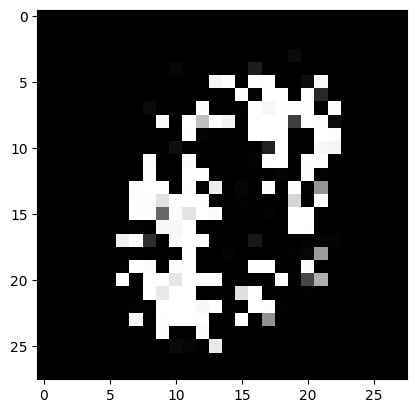

Epoch: 44550
loss_g: 0.033232182264328 	loss_d: 4.581203460693359
Epoch: 44600
loss_g: 0.03314167261123657 	loss_d: 4.759083271026611
Epoch: 44650
loss_g: 0.033063024282455444 	loss_d: 4.629628658294678
Epoch: 44700
loss_g: 0.03297482058405876 	loss_d: 5.131234169006348
Epoch: 44750
loss_g: 0.032956041395664215 	loss_d: 4.548914432525635
Epoch: 44800
loss_g: 0.03287213668227196 	loss_d: 4.860601425170898
Epoch: 44850
loss_g: 0.03280763700604439 	loss_d: 4.820843696594238
Epoch: 44900
loss_g: 0.03273771330714226 	loss_d: 5.271687984466553
Epoch: 44950
loss_g: 0.03265486657619476 	loss_d: 5.062350749969482
Epoch: 45000
loss_g: 0.03261472284793854 	loss_d: 4.752732276916504


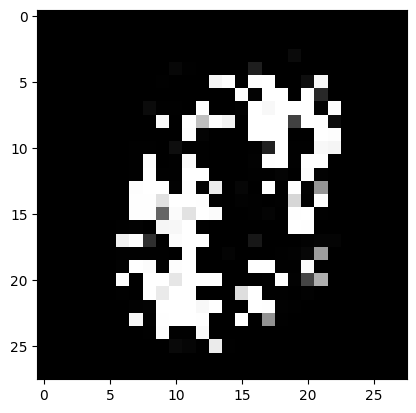

Epoch: 45050
loss_g: 0.03250940144062042 	loss_d: 5.061441898345947
Epoch: 45100
loss_g: 0.032478250563144684 	loss_d: 4.767580032348633
Epoch: 45150
loss_g: 0.032380688935518265 	loss_d: 5.341351509094238
Epoch: 45200
loss_g: 0.03233381733298302 	loss_d: 4.83804178237915
Epoch: 45250
loss_g: 0.03220909833908081 	loss_d: 4.644900798797607
Epoch: 45300
loss_g: 0.03217608854174614 	loss_d: 4.950438976287842
Epoch: 45350
loss_g: 0.032147184014320374 	loss_d: 4.258813381195068
Epoch: 45400
loss_g: 0.032055482268333435 	loss_d: 5.086291790008545
Epoch: 45450
loss_g: 0.03199932351708412 	loss_d: 4.408992767333984
Epoch: 45500
loss_g: 0.031920552253723145 	loss_d: 4.78546142578125


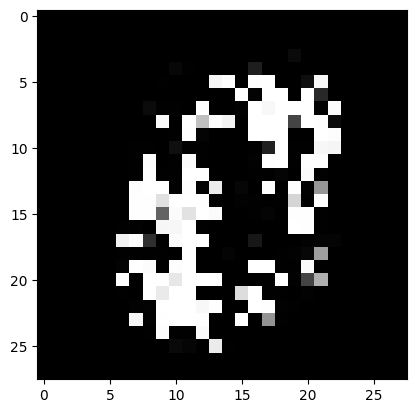

Epoch: 45550
loss_g: 0.03187137842178345 	loss_d: 4.793692588806152
Epoch: 45600
loss_g: 0.03178511559963226 	loss_d: 4.596454620361328
Epoch: 45650
loss_g: 0.03172999620437622 	loss_d: 5.334344863891602
Epoch: 45700
loss_g: 0.031697195023298264 	loss_d: 4.977002143859863
Epoch: 45750
loss_g: 0.03160911425948143 	loss_d: 4.890340805053711
Epoch: 45800
loss_g: 0.03159531205892563 	loss_d: 4.5726118087768555
Epoch: 45850
loss_g: 0.03149399161338806 	loss_d: 4.8553032875061035
Epoch: 45900
loss_g: 0.03146028518676758 	loss_d: 4.898616790771484
Epoch: 45950
loss_g: 0.03138484060764313 	loss_d: 4.663928508758545
Epoch: 46000
loss_g: 0.03130290284752846 	loss_d: 4.880196571350098


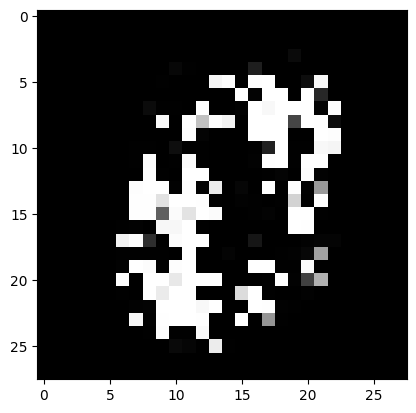

Epoch: 46050
loss_g: 0.031222576275467873 	loss_d: 5.032956123352051
Epoch: 46100
loss_g: 0.031188365072011948 	loss_d: 4.642593860626221
Epoch: 46150
loss_g: 0.03110150247812271 	loss_d: 4.860953330993652
Epoch: 46200
loss_g: 0.03107418864965439 	loss_d: 4.543220043182373
Epoch: 46250
loss_g: 0.03098161704838276 	loss_d: 5.102026462554932
Epoch: 46300
loss_g: 0.030958689749240875 	loss_d: 4.636325359344482
Epoch: 46350
loss_g: 0.03087720274925232 	loss_d: 4.82604455947876
Epoch: 46400
loss_g: 0.030815323814749718 	loss_d: 4.757612228393555
Epoch: 46450
loss_g: 0.030777456238865852 	loss_d: 4.777648448944092
Epoch: 46500
loss_g: 0.030696209520101547 	loss_d: 4.7904205322265625


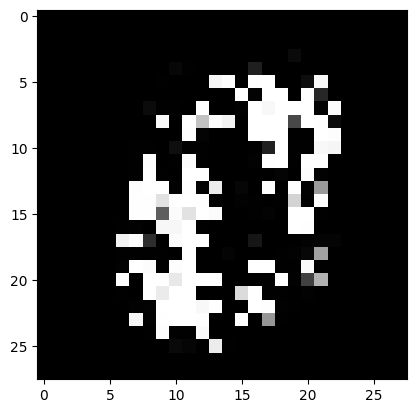

Epoch: 46550
loss_g: 0.030677199363708496 	loss_d: 4.859696388244629
Epoch: 46600
loss_g: 0.030584653839468956 	loss_d: 4.603096008300781
Epoch: 46650
loss_g: 0.030556505545973778 	loss_d: 5.0103583335876465
Epoch: 46700
loss_g: 0.03047812357544899 	loss_d: 4.916418075561523
Epoch: 46750
loss_g: 0.030419625341892242 	loss_d: 5.020087242126465
Epoch: 46800
loss_g: 0.030385702848434448 	loss_d: 4.902065277099609
Epoch: 46850
loss_g: 0.030314574018120766 	loss_d: 5.050992965698242
Epoch: 46900
loss_g: 0.030248228460550308 	loss_d: 4.931271553039551
Epoch: 46950
loss_g: 0.030240267515182495 	loss_d: 4.675541400909424
Epoch: 47000
loss_g: 0.030173834413290024 	loss_d: 4.853355884552002


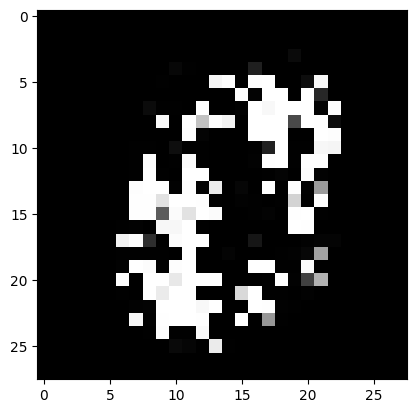

Epoch: 47050
loss_g: 0.030145348981022835 	loss_d: 4.722782135009766
Epoch: 47100
loss_g: 0.030094679445028305 	loss_d: 5.222959995269775
Epoch: 47150
loss_g: 0.02998470701277256 	loss_d: 4.640120983123779
Epoch: 47200
loss_g: 0.02994825318455696 	loss_d: 4.952096939086914
Epoch: 47250
loss_g: 0.029960934072732925 	loss_d: 4.911556243896484
Epoch: 47300
loss_g: 0.029852358624339104 	loss_d: 5.360769748687744
Epoch: 47350
loss_g: 0.02979743480682373 	loss_d: 5.153151988983154
Epoch: 47400
loss_g: 0.029762890189886093 	loss_d: 4.84271764755249
Epoch: 47450
loss_g: 0.029741385951638222 	loss_d: 5.150114059448242
Epoch: 47500
loss_g: 0.029665861278772354 	loss_d: 4.85551643371582


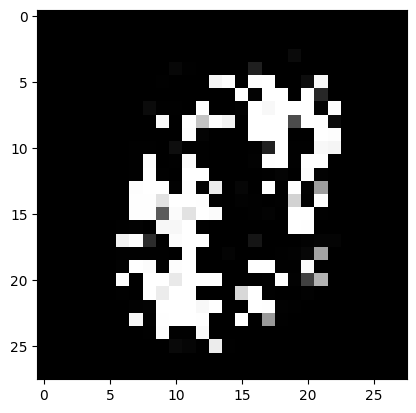

Epoch: 47550
loss_g: 0.029619228094816208 	loss_d: 5.431191921234131
Epoch: 47600
loss_g: 0.0295572467148304 	loss_d: 4.92683744430542
Epoch: 47650
loss_g: 0.029523443430662155 	loss_d: 4.732322692871094
Epoch: 47700
loss_g: 0.029479406774044037 	loss_d: 5.038076877593994
Epoch: 47750
loss_g: 0.029401885345578194 	loss_d: 4.346376419067383
Epoch: 47800
loss_g: 0.029326628893613815 	loss_d: 5.172491073608398
Epoch: 47850
loss_g: 0.029320642352104187 	loss_d: 4.49561882019043
Epoch: 47900
loss_g: 0.029247816652059555 	loss_d: 4.871312141418457
Epoch: 47950
loss_g: 0.029175452888011932 	loss_d: 4.8791327476501465
Epoch: 48000
loss_g: 0.02917575277388096 	loss_d: 4.681681156158447


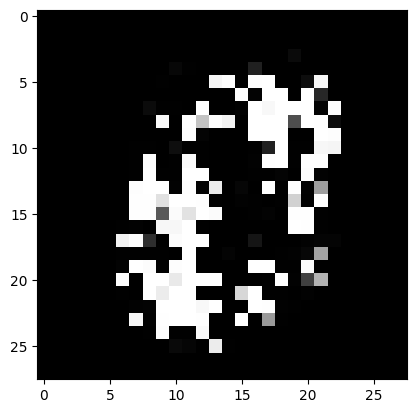

Epoch: 48050
loss_g: 0.029094761237502098 	loss_d: 5.420451641082764
Epoch: 48100
loss_g: 0.029062487185001373 	loss_d: 5.06217622756958
Epoch: 48150
loss_g: 0.029020560905337334 	loss_d: 4.9738664627075195
Epoch: 48200
loss_g: 0.028962206095457077 	loss_d: 4.657159328460693
Epoch: 48250
loss_g: 0.028945261612534523 	loss_d: 4.93729305267334
Epoch: 48300
loss_g: 0.028921103104948997 	loss_d: 4.983120918273926
Epoch: 48350
loss_g: 0.028859011828899384 	loss_d: 4.746155738830566
Epoch: 48400
loss_g: 0.02877925895154476 	loss_d: 4.962179660797119
Epoch: 48450
loss_g: 0.0287967287003994 	loss_d: 5.114736080169678
Epoch: 48500
loss_g: 0.02873302437365055 	loss_d: 4.724603652954102


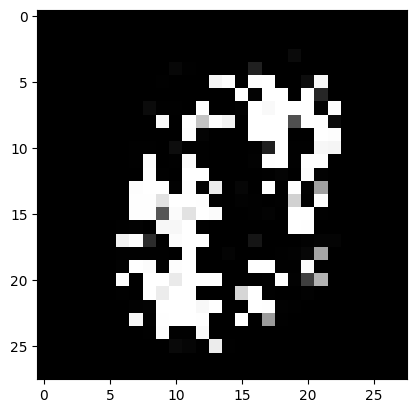

Epoch: 48550
loss_g: 0.028665143996477127 	loss_d: 4.942231178283691
Epoch: 48600
loss_g: 0.028586437925696373 	loss_d: 4.623301029205322
Epoch: 48650
loss_g: 0.028618425130844116 	loss_d: 5.183143615722656
Epoch: 48700
loss_g: 0.02858116291463375 	loss_d: 4.717177391052246
Epoch: 48750
loss_g: 0.028496721759438515 	loss_d: 4.906513690948486
Epoch: 48800
loss_g: 0.028434472158551216 	loss_d: 4.836757183074951
Epoch: 48850
loss_g: 0.028400156646966934 	loss_d: 4.856192111968994
Epoch: 48900
loss_g: 0.02836778573691845 	loss_d: 4.867944240570068
Epoch: 48950
loss_g: 0.028333215042948723 	loss_d: 4.936489582061768
Epoch: 49000
loss_g: 0.028292689472436905 	loss_d: 4.680277347564697


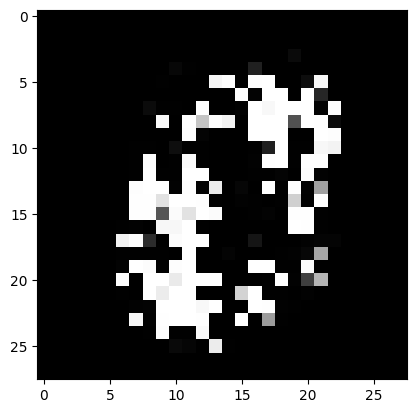

Epoch: 49050
loss_g: 0.02822115272283554 	loss_d: 5.088597297668457
Epoch: 49100
loss_g: 0.028182847425341606 	loss_d: 4.9926981925964355
Epoch: 49150
loss_g: 0.028164513409137726 	loss_d: 5.09694242477417
Epoch: 49200
loss_g: 0.028132818639278412 	loss_d: 4.978774547576904
Epoch: 49250
loss_g: 0.028071748092770576 	loss_d: 5.1243085861206055
Epoch: 49300
loss_g: 0.027999641373753548 	loss_d: 5.007673263549805
Epoch: 49350
loss_g: 0.028000513091683388 	loss_d: 4.7512617111206055
Epoch: 49400
loss_g: 0.027943886816501617 	loss_d: 4.928151607513428
Epoch: 49450
loss_g: 0.027942147105932236 	loss_d: 4.795474052429199
Epoch: 49500
loss_g: 0.027857670560479164 	loss_d: 5.296252727508545


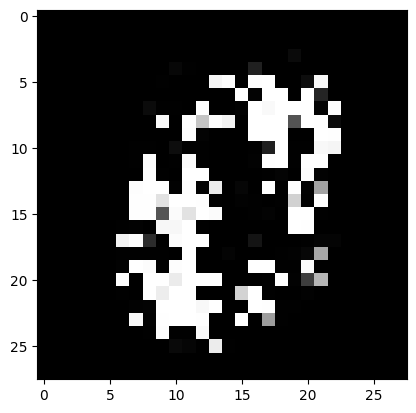

Epoch: 49550
loss_g: 0.027840131893754005 	loss_d: 4.7144293785095215
Epoch: 49600
loss_g: 0.027782443910837173 	loss_d: 5.025097846984863
Epoch: 49650
loss_g: 0.027758263051509857 	loss_d: 4.984785556793213
Epoch: 49700
loss_g: 0.02773922309279442 	loss_d: 5.434504508972168
Epoch: 49750
loss_g: 0.027690453454852104 	loss_d: 5.224752426147461
Epoch: 49800
loss_g: 0.02761922776699066 	loss_d: 4.915701389312744
Epoch: 49850
loss_g: 0.02762656845152378 	loss_d: 5.22149658203125
Epoch: 49900
loss_g: 0.02757125347852707 	loss_d: 4.92684268951416
Epoch: 49950
loss_g: 0.02750839665532112 	loss_d: 5.5019402503967285
Epoch: 50000
loss_g: 0.02750062383711338 	loss_d: 4.997190475463867


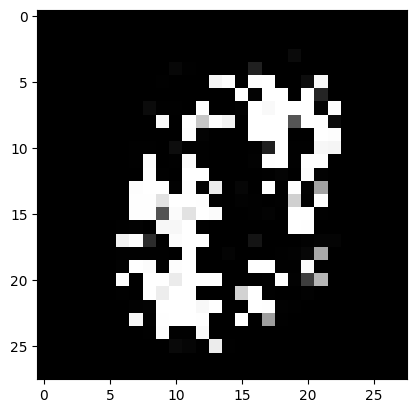

Epoch: 50050
loss_g: 0.027478422969579697 	loss_d: 4.803262233734131
Epoch: 50100
loss_g: 0.027426796033978462 	loss_d: 5.110053062438965
Epoch: 50150
loss_g: 0.027357734739780426 	loss_d: 4.416701316833496
Epoch: 50200
loss_g: 0.027311932295560837 	loss_d: 5.241379737854004
Epoch: 50250
loss_g: 0.02731326036155224 	loss_d: 4.565922737121582
Epoch: 50300
loss_g: 0.02726147137582302 	loss_d: 4.940871238708496
Epoch: 50350
loss_g: 0.0272268857806921 	loss_d: 4.947967529296875
Epoch: 50400
loss_g: 0.027182161808013916 	loss_d: 4.751491069793701
Epoch: 50450
loss_g: 0.02718491293489933 	loss_d: 5.489262580871582
Epoch: 50500
loss_g: 0.02710597962141037 	loss_d: 5.130054950714111


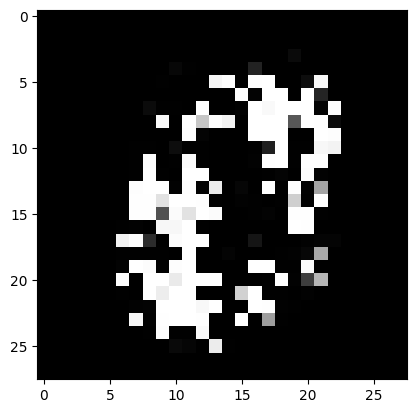

Epoch: 50550
loss_g: 0.027117908000946045 	loss_d: 5.0411787033081055
Epoch: 50600
loss_g: 0.02705513685941696 	loss_d: 4.7240166664123535
Epoch: 50650
loss_g: 0.027033179998397827 	loss_d: 5.005093574523926
Epoch: 50700
loss_g: 0.026944084092974663 	loss_d: 5.048691272735596
Epoch: 50750
loss_g: 0.026957692578434944 	loss_d: 4.811698913574219
Epoch: 50800
loss_g: 0.026925405487418175 	loss_d: 5.029306888580322
Epoch: 50850
loss_g: 0.02690136432647705 	loss_d: 5.180785179138184
Epoch: 50900
loss_g: 0.0268710944801569 	loss_d: 4.790592193603516
Epoch: 50950
loss_g: 0.026814589276909828 	loss_d: 5.0077805519104
Epoch: 51000
loss_g: 0.026798071339726448 	loss_d: 4.689650058746338


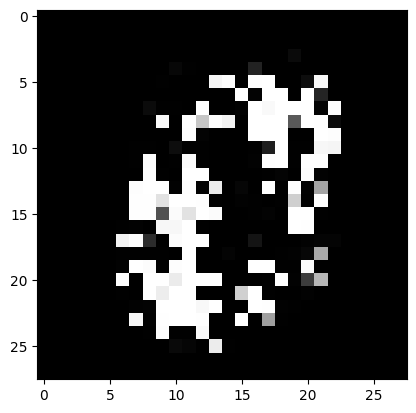

Epoch: 51050
loss_g: 0.02676684781908989 	loss_d: 5.246623516082764
Epoch: 51100
loss_g: 0.02673066034913063 	loss_d: 4.781258583068848
Epoch: 51150
loss_g: 0.026706291362643242 	loss_d: 4.970335006713867
Epoch: 51200
loss_g: 0.0266862902790308 	loss_d: 4.9026288986206055
Epoch: 51250
loss_g: 0.026611827313899994 	loss_d: 4.920116901397705
Epoch: 51300
loss_g: 0.02655007131397724 	loss_d: 4.932651996612549
Epoch: 51350
loss_g: 0.02658533677458763 	loss_d: 5.000971794128418
Epoch: 51400
loss_g: 0.026529142633080482 	loss_d: 4.7452874183654785
Epoch: 51450
loss_g: 0.026508878916502 	loss_d: 5.152516841888428
Epoch: 51500
loss_g: 0.026455171406269073 	loss_d: 5.055002212524414


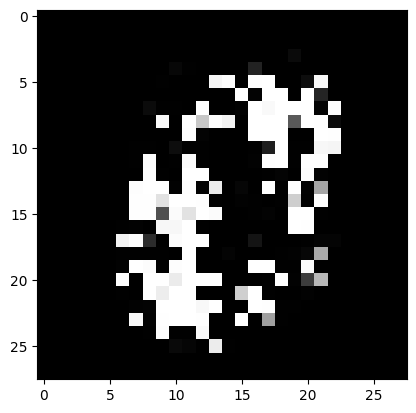

Epoch: 51550
loss_g: 0.02646491676568985 	loss_d: 5.158239364624023
Epoch: 51600
loss_g: 0.026366790756583214 	loss_d: 5.041440486907959
Epoch: 51650
loss_g: 0.026391925290226936 	loss_d: 5.188357830047607
Epoch: 51700
loss_g: 0.0263050589710474 	loss_d: 5.067655563354492
Epoch: 51750
loss_g: 0.026281103491783142 	loss_d: 4.813477993011475
Epoch: 51800
loss_g: 0.02630709297955036 	loss_d: 4.989819049835205
Epoch: 51850
loss_g: 0.02626080997288227 	loss_d: 4.856799125671387
Epoch: 51900
loss_g: 0.026228593662381172 	loss_d: 5.358977317810059
Epoch: 51950
loss_g: 0.0261648241430521 	loss_d: 4.775278091430664
Epoch: 52000
loss_g: 0.026161909103393555 	loss_d: 5.085516452789307


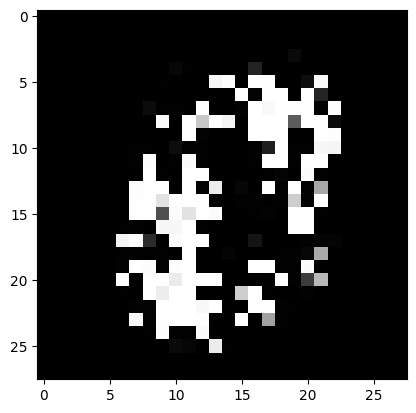

Epoch: 52050
loss_g: 0.026161450892686844 	loss_d: 5.044395923614502
Epoch: 52100
loss_g: 0.026065953075885773 	loss_d: 5.49370002746582
Epoch: 52150
loss_g: 0.026044901460409164 	loss_d: 5.284551620483398
Epoch: 52200
loss_g: 0.026053721085190773 	loss_d: 4.976157188415527
Epoch: 52250
loss_g: 0.025994176045060158 	loss_d: 5.2810821533203125
Epoch: 52300
loss_g: 0.025956163182854652 	loss_d: 4.9860310554504395
Epoch: 52350
loss_g: 0.025931762531399727 	loss_d: 5.561916828155518
Epoch: 52400
loss_g: 0.02592923305928707 	loss_d: 5.056952953338623
Epoch: 52450
loss_g: 0.02588098868727684 	loss_d: 4.860729694366455
Epoch: 52500
loss_g: 0.025860652327537537 	loss_d: 5.167835235595703


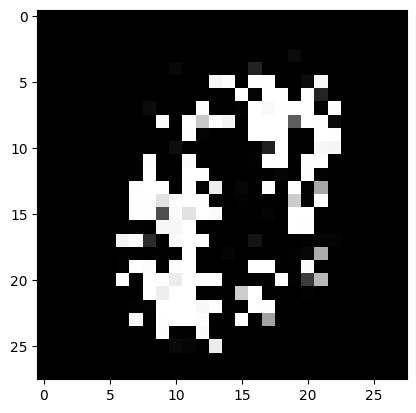

Epoch: 52550
loss_g: 0.02584822103381157 	loss_d: 4.474507808685303
Epoch: 52600
loss_g: 0.025803808122873306 	loss_d: 5.296786308288574
Epoch: 52650
loss_g: 0.02579791471362114 	loss_d: 4.622920989990234
Epoch: 52700
loss_g: 0.025736331939697266 	loss_d: 4.998849868774414
Epoch: 52750
loss_g: 0.025720251724123955 	loss_d: 5.005386829376221
Epoch: 52800
loss_g: 0.02571657858788967 	loss_d: 4.80731725692749
Epoch: 52850
loss_g: 0.025667482987046242 	loss_d: 5.544308662414551
Epoch: 52900
loss_g: 0.025628145784139633 	loss_d: 5.18472957611084
Epoch: 52950
loss_g: 0.025588350370526314 	loss_d: 5.098836898803711
Epoch: 53000
loss_g: 0.025578705593943596 	loss_d: 4.779139518737793


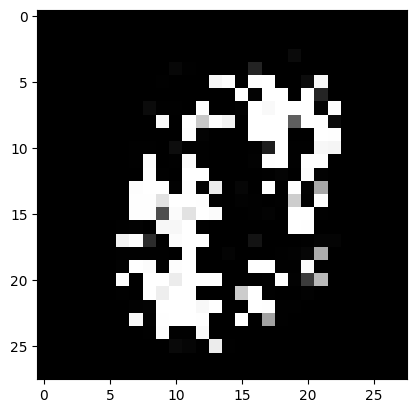

Epoch: 53050
loss_g: 0.02558261901140213 	loss_d: 5.05942964553833
Epoch: 53100
loss_g: 0.025531649589538574 	loss_d: 5.103941440582275
Epoch: 53150
loss_g: 0.025508277118206024 	loss_d: 4.866326808929443
Epoch: 53200
loss_g: 0.025485720485448837 	loss_d: 5.08243989944458
Epoch: 53250
loss_g: 0.025462541729211807 	loss_d: 5.23505973815918
Epoch: 53300
loss_g: 0.025429407134652138 	loss_d: 4.844196796417236
Epoch: 53350
loss_g: 0.025401610881090164 	loss_d: 5.061884880065918
Epoch: 53400
loss_g: 0.025355948135256767 	loss_d: 4.7417216300964355
Epoch: 53450
loss_g: 0.025327982380986214 	loss_d: 5.30152702331543
Epoch: 53500
loss_g: 0.025327719748020172 	loss_d: 4.83353328704834


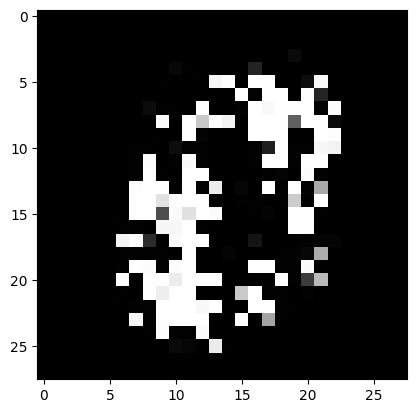

Epoch: 53550
loss_g: 0.02528975158929825 	loss_d: 5.023939609527588
Epoch: 53600
loss_g: 0.025259584188461304 	loss_d: 4.952995777130127
Epoch: 53650
loss_g: 0.02527318336069584 	loss_d: 4.973702907562256
Epoch: 53700
loss_g: 0.02523621916770935 	loss_d: 4.985317707061768
Epoch: 53750
loss_g: 0.025198182091116905 	loss_d: 5.053628444671631
Epoch: 53800
loss_g: 0.025132860988378525 	loss_d: 4.796789646148682
Epoch: 53850
loss_g: 0.025160212069749832 	loss_d: 5.2033233642578125
Epoch: 53900
loss_g: 0.025117944926023483 	loss_d: 5.107210636138916
Epoch: 53950
loss_g: 0.025113362818956375 	loss_d: 5.209909439086914
Epoch: 54000
loss_g: 0.02506858855485916 	loss_d: 5.092491149902344


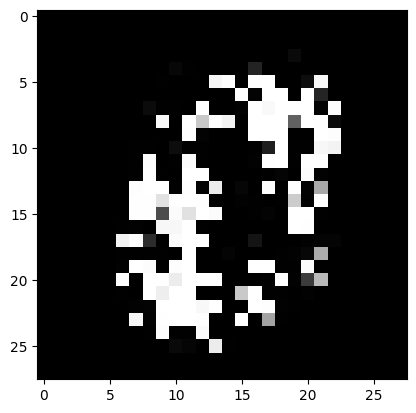

Epoch: 54050
loss_g: 0.0250356737524271 	loss_d: 5.2396464347839355
Epoch: 54100
loss_g: 0.025003232061862946 	loss_d: 5.118812084197998
Epoch: 54150
loss_g: 0.02500629797577858 	loss_d: 4.862545013427734
Epoch: 54200
loss_g: 0.024962475523352623 	loss_d: 5.040992736816406
Epoch: 54250
loss_g: 0.024942878633737564 	loss_d: 4.908179759979248
Epoch: 54300
loss_g: 0.024918217211961746 	loss_d: 5.407146453857422
Epoch: 54350
loss_g: 0.024872245267033577 	loss_d: 4.825247764587402
Epoch: 54400
loss_g: 0.024886680766940117 	loss_d: 5.13493013381958
Epoch: 54450
loss_g: 0.024863671511411667 	loss_d: 5.093296051025391
Epoch: 54500
loss_g: 0.024846894666552544 	loss_d: 5.5438008308410645


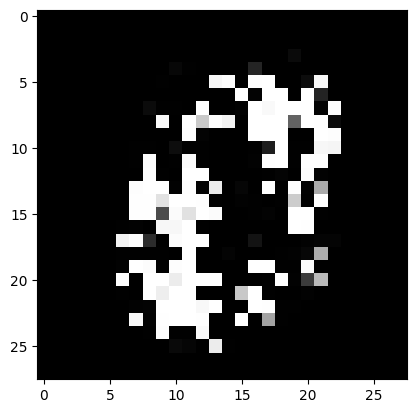

Epoch: 54550
loss_g: 0.02478739060461521 	loss_d: 5.3327531814575195
Epoch: 54600
loss_g: 0.024790100753307343 	loss_d: 5.022679805755615
Epoch: 54650
loss_g: 0.02475624904036522 	loss_d: 5.330080509185791
Epoch: 54700
loss_g: 0.024740861728787422 	loss_d: 5.035041332244873
Epoch: 54750
loss_g: 0.024715909734368324 	loss_d: 5.608852863311768
Epoch: 54800
loss_g: 0.024660306051373482 	loss_d: 5.104202747344971
Epoch: 54850
loss_g: 0.024654200300574303 	loss_d: 4.909184455871582
Epoch: 54900
loss_g: 0.024642815813422203 	loss_d: 5.2143096923828125
Epoch: 54950
loss_g: 0.024649279192090034 	loss_d: 4.521271705627441
Epoch: 55000
loss_g: 0.02459694817662239 	loss_d: 5.347168922424316


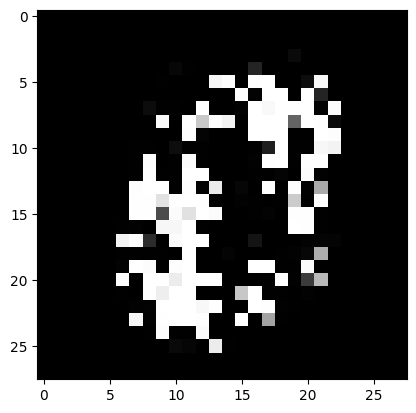

Epoch: 55050
loss_g: 0.02457418479025364 	loss_d: 4.669342041015625
Epoch: 55100
loss_g: 0.024509496986865997 	loss_d: 5.044390678405762
Epoch: 55150
loss_g: 0.024526987224817276 	loss_d: 5.051034927368164
Epoch: 55200
loss_g: 0.024496737867593765 	loss_d: 4.851670265197754
Epoch: 55250
loss_g: 0.02449670247733593 	loss_d: 5.590033054351807
Epoch: 55300
loss_g: 0.024490684270858765 	loss_d: 5.231312274932861
Epoch: 55350
loss_g: 0.0244453027844429 	loss_d: 5.142690658569336
Epoch: 55400
loss_g: 0.024431904777884483 	loss_d: 4.824054718017578
Epoch: 55450
loss_g: 0.024406518787145615 	loss_d: 5.106241703033447
Epoch: 55500
loss_g: 0.02438567578792572 	loss_d: 5.149760723114014


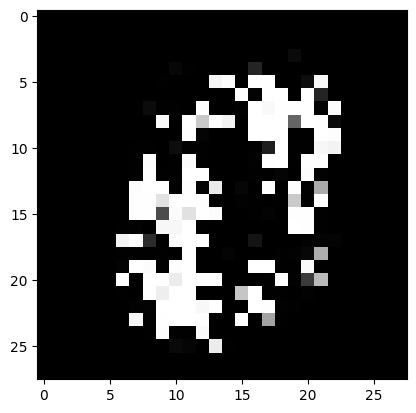

Epoch: 55550
loss_g: 0.024371422827243805 	loss_d: 4.911578178405762
Epoch: 55600
loss_g: 0.024341216310858727 	loss_d: 5.127927780151367
Epoch: 55650
loss_g: 0.02429242618381977 	loss_d: 5.279740333557129
Epoch: 55700
loss_g: 0.02429172769188881 	loss_d: 4.889214038848877
Epoch: 55750
loss_g: 0.024286357685923576 	loss_d: 5.107415676116943
Epoch: 55800
loss_g: 0.024245550855994225 	loss_d: 4.78572940826416
Epoch: 55850
loss_g: 0.024249987676739693 	loss_d: 5.345085620880127
Epoch: 55900
loss_g: 0.024216247722506523 	loss_d: 4.876964569091797
Epoch: 55950
loss_g: 0.02419307827949524 	loss_d: 5.065910816192627
Epoch: 56000
loss_g: 0.02416425198316574 	loss_d: 4.995563983917236


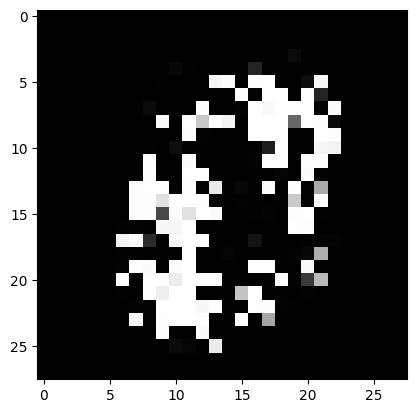

Epoch: 56050
loss_g: 0.024153735488653183 	loss_d: 5.01624059677124
Epoch: 56100
loss_g: 0.024130553007125854 	loss_d: 5.028409481048584
Epoch: 56150
loss_g: 0.024105168879032135 	loss_d: 5.094587326049805
Epoch: 56200
loss_g: 0.024097761139273643 	loss_d: 4.837921619415283
Epoch: 56250
loss_g: 0.024089839309453964 	loss_d: 5.2459516525268555
Epoch: 56300
loss_g: 0.02404654026031494 	loss_d: 5.148591041564941
Epoch: 56350
loss_g: 0.024076055735349655 	loss_d: 5.251061916351318
Epoch: 56400
loss_g: 0.02402520552277565 	loss_d: 5.134100437164307
Epoch: 56450
loss_g: 0.023989439010620117 	loss_d: 5.279121398925781
Epoch: 56500
loss_g: 0.023998431861400604 	loss_d: 5.16105842590332


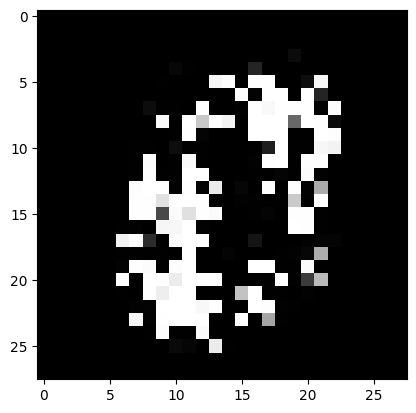

Epoch: 56550
loss_g: 0.023961424827575684 	loss_d: 4.903385639190674
Epoch: 56600
loss_g: 0.023972930386662483 	loss_d: 5.081785202026367
Epoch: 56650
loss_g: 0.023912720382213593 	loss_d: 4.948581695556641
Epoch: 56700
loss_g: 0.0239446721971035 	loss_d: 5.448700428009033
Epoch: 56750
loss_g: 0.023873867467045784 	loss_d: 4.864468574523926
Epoch: 56800
loss_g: 0.023861825466156006 	loss_d: 5.175477027893066
Epoch: 56850
loss_g: 0.0238955020904541 	loss_d: 5.1345133781433105
Epoch: 56900
loss_g: 0.023818636313080788 	loss_d: 5.5828423500061035
Epoch: 56950
loss_g: 0.023800823837518692 	loss_d: 5.374668121337891
Epoch: 57000
loss_g: 0.023791734129190445 	loss_d: 5.063846111297607


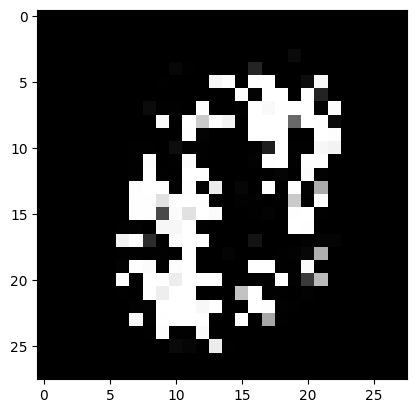

Epoch: 57050
loss_g: 0.02377968467772007 	loss_d: 5.3691511154174805
Epoch: 57100
loss_g: 0.023745335638523102 	loss_d: 5.074272632598877
Epoch: 57150
loss_g: 0.02375403605401516 	loss_d: 5.649438381195068
Epoch: 57200
loss_g: 0.02374475821852684 	loss_d: 5.143923282623291
Epoch: 57250
loss_g: 0.023727506399154663 	loss_d: 4.948614597320557
Epoch: 57300
loss_g: 0.023725420236587524 	loss_d: 5.253965377807617
Epoch: 57350
loss_g: 0.023661259561777115 	loss_d: 4.560393810272217
Epoch: 57400
loss_g: 0.02365582436323166 	loss_d: 5.3828840255737305
Epoch: 57450
loss_g: 0.02363433875143528 	loss_d: 4.708311557769775
Epoch: 57500
loss_g: 0.02364168129861355 	loss_d: 5.082160472869873


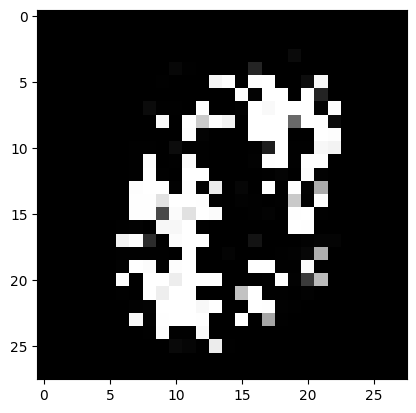

Epoch: 57550
loss_g: 0.02358662150800228 	loss_d: 5.088867664337158
Epoch: 57600
loss_g: 0.02359563298523426 	loss_d: 4.889636039733887
Epoch: 57650
loss_g: 0.023589948192238808 	loss_d: 5.628392696380615
Epoch: 57700
loss_g: 0.023558028042316437 	loss_d: 5.270763874053955
Epoch: 57750
loss_g: 0.023554233834147453 	loss_d: 5.180933475494385
Epoch: 57800
loss_g: 0.02349291741847992 	loss_d: 4.8620686531066895
Epoch: 57850
loss_g: 0.023520512506365776 	loss_d: 5.140845775604248
Epoch: 57900
loss_g: 0.023463081568479538 	loss_d: 5.186443328857422
Epoch: 57950
loss_g: 0.02345469407737255 	loss_d: 4.94942569732666
Epoch: 58000
loss_g: 0.023446230217814445 	loss_d: 5.164077281951904


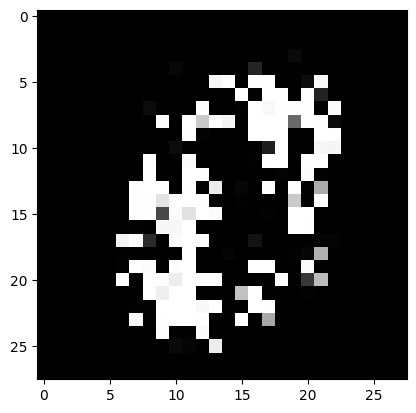

Epoch: 58050
loss_g: 0.023428896442055702 	loss_d: 5.315495014190674
Epoch: 58100
loss_g: 0.02340964786708355 	loss_d: 4.925217151641846
Epoch: 58150
loss_g: 0.023421239107847214 	loss_d: 5.142233848571777
Epoch: 58200
loss_g: 0.023401379585266113 	loss_d: 4.822754383087158
Epoch: 58250
loss_g: 0.023405658081173897 	loss_d: 5.381036758422852
Epoch: 58300
loss_g: 0.02334352396428585 	loss_d: 4.913665294647217
Epoch: 58350
loss_g: 0.02336938865482807 	loss_d: 5.103184223175049
Epoch: 58400
loss_g: 0.023328248411417007 	loss_d: 5.031528949737549
Epoch: 58450
loss_g: 0.023325728252530098 	loss_d: 5.05025053024292
Epoch: 58500
loss_g: 0.023314571008086205 	loss_d: 5.06322717666626


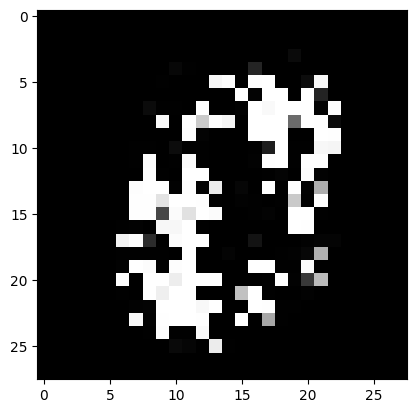

Epoch: 58550
loss_g: 0.023283571004867554 	loss_d: 5.131401538848877
Epoch: 58600
loss_g: 0.02327032946050167 	loss_d: 4.874414443969727
Epoch: 58650
loss_g: 0.02325395494699478 	loss_d: 5.280529022216797
Epoch: 58700
loss_g: 0.023245271295309067 	loss_d: 5.182427883148193
Epoch: 58750
loss_g: 0.02322242595255375 	loss_d: 5.286715030670166
Epoch: 58800
loss_g: 0.023196259513497353 	loss_d: 5.168431282043457
Epoch: 58850
loss_g: 0.023186273872852325 	loss_d: 5.314001560211182
Epoch: 58900
loss_g: 0.023153120651841164 	loss_d: 5.193991184234619
Epoch: 58950
loss_g: 0.02315008081495762 	loss_d: 4.938626766204834
Epoch: 59000
loss_g: 0.023131946101784706 	loss_d: 5.115161895751953


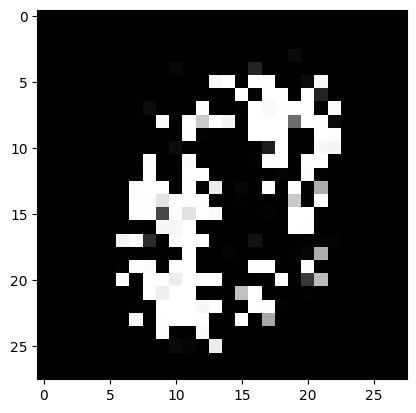

Epoch: 59050
loss_g: 0.023116206750273705 	loss_d: 4.981268882751465
Epoch: 59100
loss_g: 0.02311958186328411 	loss_d: 5.481588363647461
Epoch: 59150
loss_g: 0.02310866303741932 	loss_d: 4.899026393890381
Epoch: 59200
loss_g: 0.02311059832572937 	loss_d: 5.209911823272705
Epoch: 59250
loss_g: 0.023090416565537453 	loss_d: 5.168018817901611
Epoch: 59300
loss_g: 0.023074109107255936 	loss_d: 5.616134166717529
Epoch: 59350
loss_g: 0.023057708516716957 	loss_d: 5.406642436981201
Epoch: 59400
loss_g: 0.023038411512970924 	loss_d: 5.096459865570068
Epoch: 59450
loss_g: 0.0230186115950346 	loss_d: 5.399662017822266
Epoch: 59500
loss_g: 0.02299906685948372 	loss_d: 5.1073198318481445


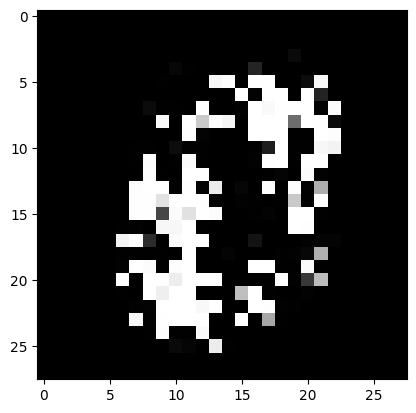

Epoch: 59550
loss_g: 0.02300455793738365 	loss_d: 5.6800537109375
Epoch: 59600
loss_g: 0.02298053726553917 	loss_d: 5.174490928649902
Epoch: 59650
loss_g: 0.022979505360126495 	loss_d: 4.980575084686279
Epoch: 59700
loss_g: 0.022961506620049477 	loss_d: 5.285548210144043
Epoch: 59750
loss_g: 0.02291991002857685 	loss_d: 4.591574668884277
Epoch: 59800
loss_g: 0.022927816957235336 	loss_d: 5.417713165283203
Epoch: 59850
loss_g: 0.022876329720020294 	loss_d: 4.739908695220947
Epoch: 59900
loss_g: 0.022899622097611427 	loss_d: 5.1139655113220215
Epoch: 59950
loss_g: 0.022892965003848076 	loss_d: 5.119754791259766
Epoch: 60000
loss_g: 0.022832712158560753 	loss_d: 4.923971176147461


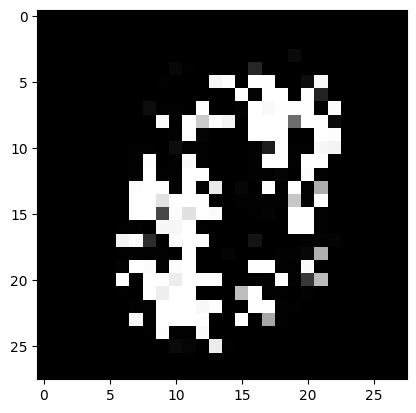

Epoch: 60050
loss_g: 0.022848326712846756 	loss_d: 5.660433292388916
Epoch: 60100
loss_g: 0.022863682359457016 	loss_d: 5.299860000610352
Epoch: 60150
loss_g: 0.022801723331212997 	loss_d: 5.2110114097595215
Epoch: 60200
loss_g: 0.022808069363236427 	loss_d: 4.892021656036377
Epoch: 60250
loss_g: 0.022812793031334877 	loss_d: 5.174583435058594
Epoch: 60300
loss_g: 0.022781401872634888 	loss_d: 5.215734958648682
Epoch: 60350
loss_g: 0.02275010012090206 	loss_d: 4.979770660400391
Epoch: 60400
loss_g: 0.02276502549648285 	loss_d: 5.193881511688232
Epoch: 60450
loss_g: 0.022726954892277718 	loss_d: 5.3453803062438965
Epoch: 60500
loss_g: 0.022713569924235344 	loss_d: 4.956169605255127


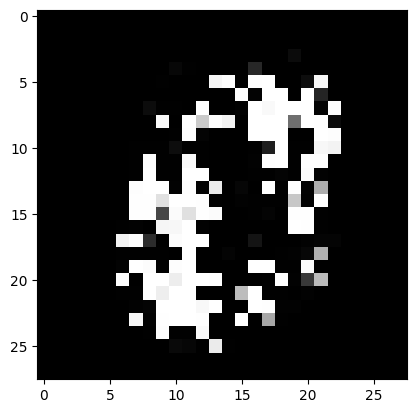

Epoch: 60550
loss_g: 0.02271651290357113 	loss_d: 5.172629356384277
Epoch: 60600
loss_g: 0.02267826907336712 	loss_d: 4.851230144500732
Epoch: 60650
loss_g: 0.02267112024128437 	loss_d: 5.411097526550293
Epoch: 60700
loss_g: 0.022669510915875435 	loss_d: 4.942770481109619
Epoch: 60750
loss_g: 0.02268294245004654 	loss_d: 5.130195140838623
Epoch: 60800
loss_g: 0.022637030109763145 	loss_d: 5.0617475509643555
Epoch: 60850
loss_g: 0.022644247859716415 	loss_d: 5.080222129821777
Epoch: 60900
loss_g: 0.022626830264925957 	loss_d: 5.092888355255127
Epoch: 60950
loss_g: 0.022619720548391342 	loss_d: 5.158999919891357
Epoch: 61000
loss_g: 0.022608157247304916 	loss_d: 4.90321159362793


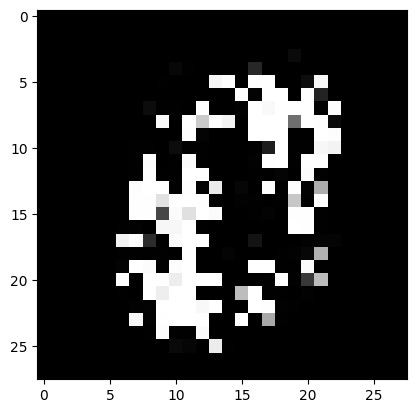

Epoch: 61050
loss_g: 0.022594818845391273 	loss_d: 5.309715747833252
Epoch: 61100
loss_g: 0.02259446121752262 	loss_d: 5.21164608001709
Epoch: 61150
loss_g: 0.02253563143312931 	loss_d: 5.314711093902588
Epoch: 61200
loss_g: 0.022561993449926376 	loss_d: 5.195470809936523
Epoch: 61250
loss_g: 0.02256143093109131 	loss_d: 5.341864109039307
Epoch: 61300
loss_g: 0.022521359845995903 	loss_d: 5.221458435058594
Epoch: 61350
loss_g: 0.022517429664731026 	loss_d: 4.9665350914001465
Epoch: 61400
loss_g: 0.022490596398711205 	loss_d: 5.142253875732422
Epoch: 61450
loss_g: 0.022484859451651573 	loss_d: 5.009342670440674
Epoch: 61500
loss_g: 0.022487690672278404 	loss_d: 5.510779857635498


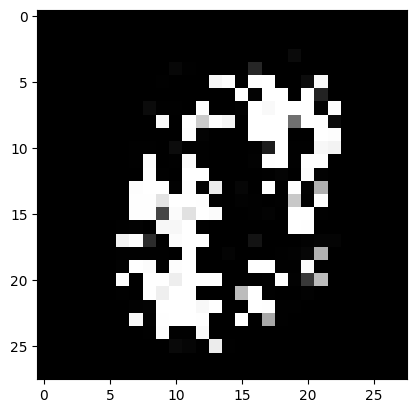

Epoch: 61550
loss_g: 0.022461432963609695 	loss_d: 4.9257493019104
Epoch: 61600
loss_g: 0.022454652935266495 	loss_d: 5.2370452880859375
Epoch: 61650
loss_g: 0.022415632382035255 	loss_d: 5.194483757019043
Epoch: 61700
loss_g: 0.022466344758868217 	loss_d: 5.645082950592041
Epoch: 61750
loss_g: 0.022415688261389732 	loss_d: 5.432976245880127
Epoch: 61800
loss_g: 0.02236929163336754 	loss_d: 5.1242356300354
Epoch: 61850
loss_g: 0.02238042838871479 	loss_d: 5.429088115692139
Epoch: 61900
loss_g: 0.02240474708378315 	loss_d: 5.133235931396484
Epoch: 61950
loss_g: 0.022371524944901466 	loss_d: 5.707448482513428
Epoch: 62000
loss_g: 0.02237626351416111 	loss_d: 5.203127384185791


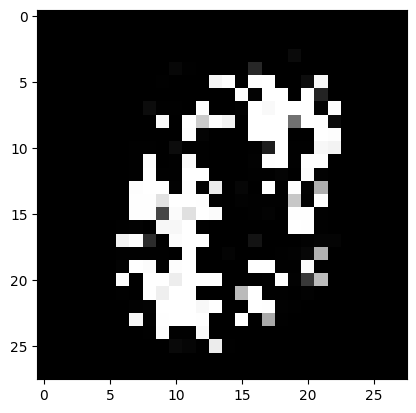

Epoch: 62050
loss_g: 0.02234632894396782 	loss_d: 5.006049156188965
Epoch: 62100
loss_g: 0.02234152890741825 	loss_d: 5.312108516693115
Epoch: 62150
loss_g: 0.022313160821795464 	loss_d: 4.617271900177002
Epoch: 62200
loss_g: 0.022319002076983452 	loss_d: 5.443492889404297
Epoch: 62250
loss_g: 0.02233658917248249 	loss_d: 4.765446662902832
Epoch: 62300
loss_g: 0.022298015654087067 	loss_d: 5.138795375823975
Epoch: 62350
loss_g: 0.02230777218937874 	loss_d: 5.14614200592041
Epoch: 62400
loss_g: 0.02228747121989727 	loss_d: 4.946956157684326
Epoch: 62450
loss_g: 0.022290276363492012 	loss_d: 5.685679912567139
Epoch: 62500
loss_g: 0.022262396290898323 	loss_d: 5.3263654708862305


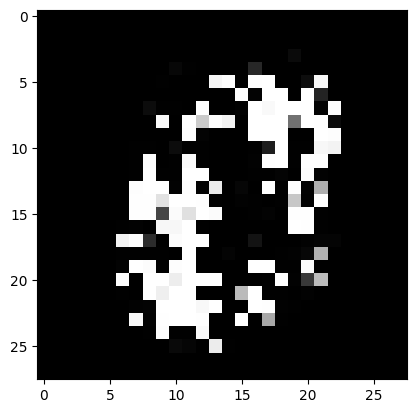

Epoch: 62550
loss_g: 0.02221379242837429 	loss_d: 5.237387180328369
Epoch: 62600
loss_g: 0.022195300087332726 	loss_d: 4.917304515838623
Epoch: 62650
loss_g: 0.02221556194126606 	loss_d: 5.197657108306885
Epoch: 62700
loss_g: 0.022225745022296906 	loss_d: 5.242501258850098
Epoch: 62750
loss_g: 0.022198958322405815 	loss_d: 5.0031514167785645
Epoch: 62800
loss_g: 0.022177474573254585 	loss_d: 5.220144271850586
Epoch: 62850
loss_g: 0.022143734619021416 	loss_d: 5.371127128601074
Epoch: 62900
loss_g: 0.022158754989504814 	loss_d: 4.980439186096191
Epoch: 62950
loss_g: 0.022164182737469673 	loss_d: 5.197632789611816
Epoch: 63000
loss_g: 0.02214222401380539 	loss_d: 4.877326011657715


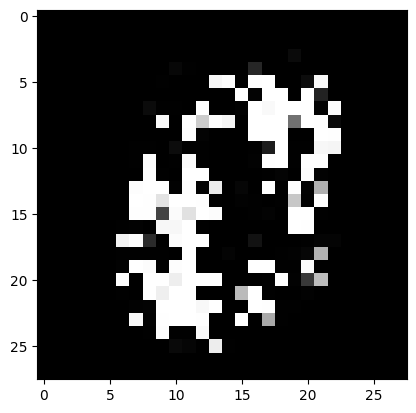

Epoch: 63050
loss_g: 0.022126855328679085 	loss_d: 5.4353928565979
Epoch: 63100
loss_g: 0.022115496918559074 	loss_d: 4.966716289520264
Epoch: 63150
loss_g: 0.022094259038567543 	loss_d: 5.155519008636475
Epoch: 63200
loss_g: 0.022110233083367348 	loss_d: 5.085787773132324
Epoch: 63250
loss_g: 0.02210763841867447 	loss_d: 5.104411602020264
Epoch: 63300
loss_g: 0.022082094103097916 	loss_d: 5.116755962371826
Epoch: 63350
loss_g: 0.02208932861685753 	loss_d: 5.182275772094727
Epoch: 63400
loss_g: 0.022061971947550774 	loss_d: 4.926794528961182
Epoch: 63450
loss_g: 0.022039929404854774 	loss_d: 5.3327250480651855
Epoch: 63500
loss_g: 0.022017350420355797 	loss_d: 5.236498832702637


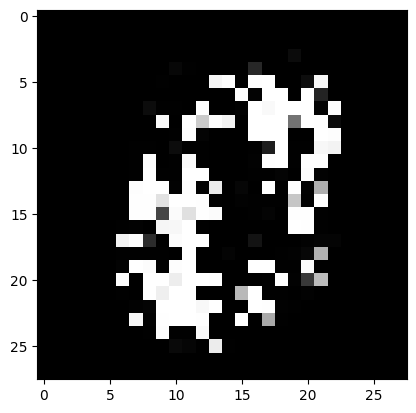

Epoch: 63550
loss_g: 0.022025521844625473 	loss_d: 5.339598178863525
Epoch: 63600
loss_g: 0.022036537528038025 	loss_d: 5.218412399291992
Epoch: 63650
loss_g: 0.02202087827026844 	loss_d: 5.3647260665893555
Epoch: 63700
loss_g: 0.022033844143152237 	loss_d: 5.245354652404785
Epoch: 63750
loss_g: 0.02198447473347187 	loss_d: 4.98969841003418
Epoch: 63800
loss_g: 0.0220013540238142 	loss_d: 5.165581703186035
Epoch: 63850
loss_g: 0.022010046988725662 	loss_d: 5.033287525177002
Epoch: 63900
loss_g: 0.021987518295645714 	loss_d: 5.532477855682373
Epoch: 63950
loss_g: 0.021969938650727272 	loss_d: 4.947556495666504
Epoch: 64000
loss_g: 0.02196211740374565 	loss_d: 5.258460521697998


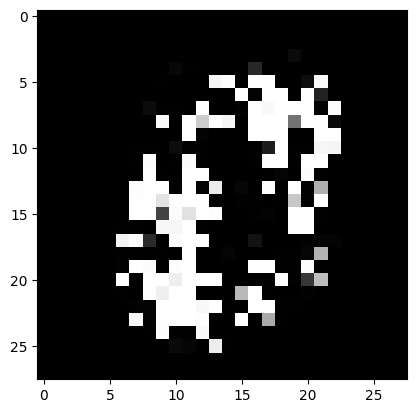

Epoch: 64050
loss_g: 0.021953454241156578 	loss_d: 5.217407703399658
Epoch: 64100
loss_g: 0.02192314900457859 	loss_d: 5.664698123931885
Epoch: 64150
loss_g: 0.02191110886633396 	loss_d: 5.453474998474121
Epoch: 64200
loss_g: 0.021923894062638283 	loss_d: 5.144676685333252
Epoch: 64250
loss_g: 0.02189834974706173 	loss_d: 5.4530158042907715
Epoch: 64300
loss_g: 0.02190682664513588 	loss_d: 5.156155109405518
Epoch: 64350
loss_g: 0.02189810201525688 	loss_d: 5.730118751525879
Epoch: 64400
loss_g: 0.02187187783420086 	loss_d: 5.223698616027832
Epoch: 64450
loss_g: 0.021857699379324913 	loss_d: 5.028592109680176
Epoch: 64500
loss_g: 0.0218442864716053 	loss_d: 5.333404541015625


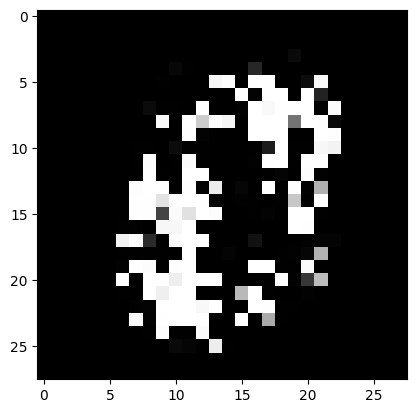

Epoch: 64550
loss_g: 0.0218303631991148 	loss_d: 4.640078544616699
Epoch: 64600
loss_g: 0.021855153143405914 	loss_d: 5.462892055511475
Epoch: 64650
loss_g: 0.02184474840760231 	loss_d: 4.787371635437012
Epoch: 64700
loss_g: 0.021819019690155983 	loss_d: 5.161899566650391
Epoch: 64750
loss_g: 0.02186666429042816 	loss_d: 5.16792631149292
Epoch: 64800
loss_g: 0.02178114838898182 	loss_d: 4.970738887786865
Epoch: 64850
loss_g: 0.02181500941514969 	loss_d: 5.7065558433532715
Epoch: 64900
loss_g: 0.021794863045215607 	loss_d: 5.347367286682129
Epoch: 64950
loss_g: 0.021772820502519608 	loss_d: 5.257744312286377
Epoch: 65000
loss_g: 0.021776627749204636 	loss_d: 4.939633846282959


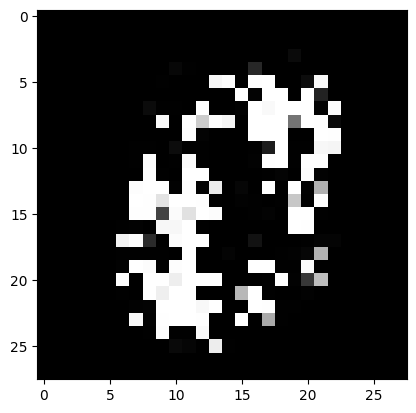

Epoch: 65050
loss_g: 0.02177528478205204 	loss_d: 5.220306396484375
Epoch: 65100
loss_g: 0.02175234816968441 	loss_d: 5.26220178604126
Epoch: 65150
loss_g: 0.02174392156302929 	loss_d: 5.024502277374268
Epoch: 65200
loss_g: 0.021740635856986046 	loss_d: 5.240621566772461
Epoch: 65250
loss_g: 0.021745700389146805 	loss_d: 5.3914475440979
Epoch: 65300
loss_g: 0.021701330319046974 	loss_d: 5.001183032989502
Epoch: 65350
loss_g: 0.021708521991968155 	loss_d: 5.2179107666015625
Epoch: 65400
loss_g: 0.021705731749534607 	loss_d: 4.896589279174805
Epoch: 65450
loss_g: 0.021710658445954323 	loss_d: 5.455672740936279
Epoch: 65500
loss_g: 0.021683406084775925 	loss_d: 4.988478660583496


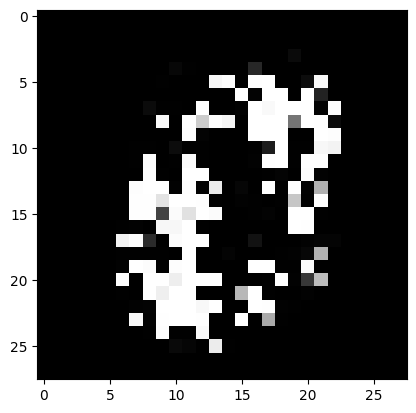

Epoch: 65550
loss_g: 0.02167765237390995 	loss_d: 5.176087379455566
Epoch: 65600
loss_g: 0.02165808156132698 	loss_d: 5.104987144470215
Epoch: 65650
loss_g: 0.021651949733495712 	loss_d: 5.123419284820557
Epoch: 65700
loss_g: 0.021648241207003593 	loss_d: 5.136202335357666
Epoch: 65750
loss_g: 0.02162361890077591 	loss_d: 5.203714847564697
Epoch: 65800
loss_g: 0.021637365221977234 	loss_d: 4.946324825286865
Epoch: 65850
loss_g: 0.02161642350256443 	loss_d: 5.352607250213623
Epoch: 65900
loss_g: 0.021624855697155 	loss_d: 5.255770206451416
Epoch: 65950
loss_g: 0.021609792485833168 	loss_d: 5.359330177307129
Epoch: 66000
loss_g: 0.021593643352389336 	loss_d: 5.23854923248291


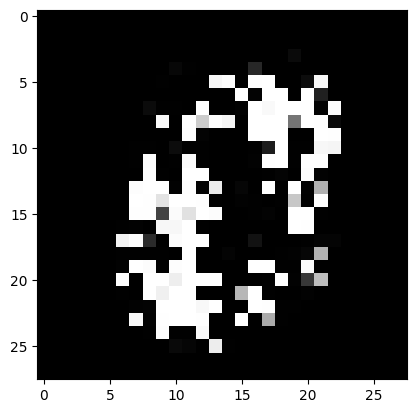

Epoch: 66050
loss_g: 0.02159670740365982 	loss_d: 5.384626865386963
Epoch: 66100
loss_g: 0.021557282656431198 	loss_d: 5.26301383972168
Epoch: 66150
loss_g: 0.02157728187739849 	loss_d: 5.00822639465332
Epoch: 66200
loss_g: 0.02156521938741207 	loss_d: 5.185235977172852
Epoch: 66250
loss_g: 0.021557802334427834 	loss_d: 5.051055431365967
Epoch: 66300
loss_g: 0.021520379930734634 	loss_d: 5.551583766937256
Epoch: 66350
loss_g: 0.021560033783316612 	loss_d: 4.968203067779541
Epoch: 66400
loss_g: 0.021573273465037346 	loss_d: 5.27808952331543
Epoch: 66450
loss_g: 0.02153657004237175 	loss_d: 5.235748767852783
Epoch: 66500
loss_g: 0.021518588066101074 	loss_d: 5.68351411819458


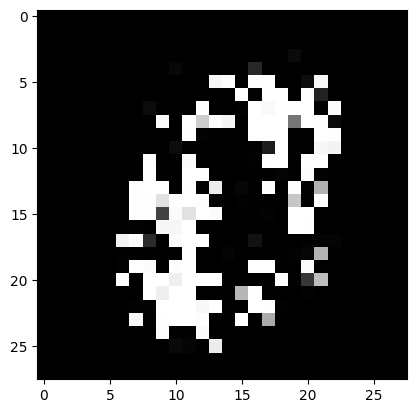

Epoch: 66550
loss_g: 0.021520275622606277 	loss_d: 5.473893165588379
Epoch: 66600
loss_g: 0.021488776430487633 	loss_d: 5.164188861846924
Epoch: 66650
loss_g: 0.021474651992321014 	loss_d: 5.470329761505127
Epoch: 66700
loss_g: 0.021497998386621475 	loss_d: 5.175003528594971
Epoch: 66750
loss_g: 0.021502923220396042 	loss_d: 5.747777938842773
Epoch: 66800
loss_g: 0.021483570337295532 	loss_d: 5.2413458824157715
Epoch: 66850
loss_g: 0.02146732248365879 	loss_d: 5.045079708099365
Epoch: 66900
loss_g: 0.0214821957051754 	loss_d: 5.352812767028809
Epoch: 66950
loss_g: 0.02144153043627739 	loss_d: 4.657890319824219
Epoch: 67000
loss_g: 0.02143053710460663 	loss_d: 5.480121612548828


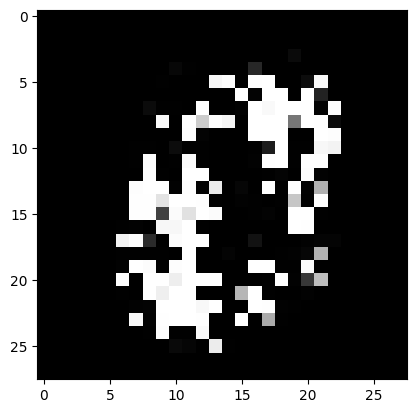

Epoch: 67050
loss_g: 0.021456651389598846 	loss_d: 4.804376602172852
Epoch: 67100
loss_g: 0.021419424563646317 	loss_d: 5.17931604385376
Epoch: 67150
loss_g: 0.021395500749349594 	loss_d: 5.1851091384887695
Epoch: 67200
loss_g: 0.021427061408758163 	loss_d: 4.984652519226074
Epoch: 67250
loss_g: 0.021421952173113823 	loss_d: 5.724348068237305
Epoch: 67300
loss_g: 0.021411849185824394 	loss_d: 5.364880561828613
Epoch: 67350
loss_g: 0.021398773416876793 	loss_d: 5.276341915130615
Epoch: 67400
loss_g: 0.021404674276709557 	loss_d: 4.956893444061279
Epoch: 67450
loss_g: 0.021363558247685432 	loss_d: 5.236049652099609
Epoch: 67500
loss_g: 0.021373972296714783 	loss_d: 5.27947473526001


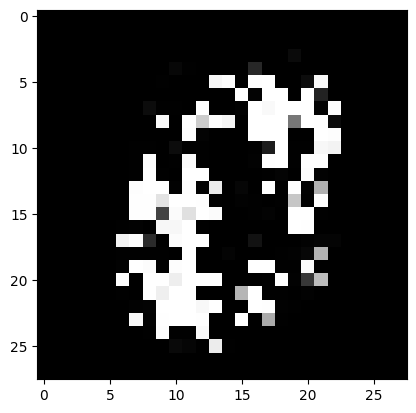

Epoch: 67550
loss_g: 0.02135988138616085 	loss_d: 5.040171146392822
Epoch: 67600
loss_g: 0.02137775532901287 	loss_d: 5.257073402404785
Epoch: 67650
loss_g: 0.02136939764022827 	loss_d: 5.409173488616943
Epoch: 67700
loss_g: 0.021364910528063774 	loss_d: 5.015928745269775
Epoch: 67750
loss_g: 0.021351566538214684 	loss_d: 5.232929706573486
Epoch: 67800
loss_g: 0.021365080028772354 	loss_d: 4.91320276260376
Epoch: 67850
loss_g: 0.02131875790655613 	loss_d: 5.471966743469238
Epoch: 67900
loss_g: 0.021322626620531082 	loss_d: 5.004216194152832
Epoch: 67950
loss_g: 0.021308159455657005 	loss_d: 5.190794944763184
Epoch: 68000
loss_g: 0.0213262178003788 	loss_d: 5.121640205383301


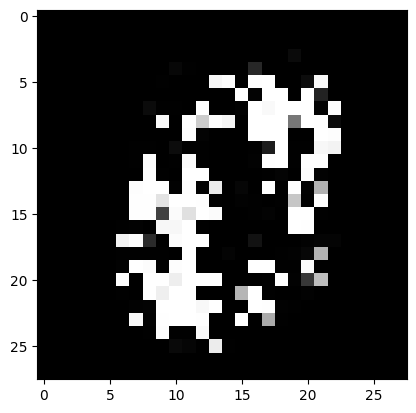

Epoch: 68050
loss_g: 0.021298283711075783 	loss_d: 5.1401801109313965
Epoch: 68100
loss_g: 0.021311435848474503 	loss_d: 5.152186393737793
Epoch: 68150
loss_g: 0.021295743063092232 	loss_d: 5.218428611755371
Epoch: 68200
loss_g: 0.021296706050634384 	loss_d: 4.961655139923096
Epoch: 68250
loss_g: 0.021282443776726723 	loss_d: 5.36843204498291
Epoch: 68300
loss_g: 0.021301450207829475 	loss_d: 5.271897792816162
Epoch: 68350
loss_g: 0.02124216966331005 	loss_d: 5.3726701736450195
Epoch: 68400
loss_g: 0.021269332617521286 	loss_d: 5.254300594329834
Epoch: 68450
loss_g: 0.021275877952575684 	loss_d: 5.401059627532959
Epoch: 68500
loss_g: 0.021229548379778862 	loss_d: 5.280048847198486


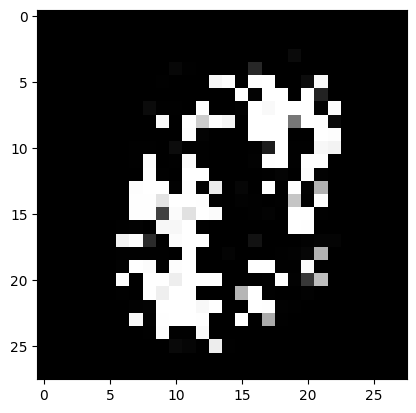

Epoch: 68550
loss_g: 0.021241391077637672 	loss_d: 5.023881912231445
Epoch: 68600
loss_g: 0.02124621346592903 	loss_d: 5.201591968536377
Epoch: 68650
loss_g: 0.02122599631547928 	loss_d: 5.067715644836426
Epoch: 68700
loss_g: 0.021231556311249733 	loss_d: 5.567285060882568
Epoch: 68750
loss_g: 0.021236972883343697 	loss_d: 4.983166217803955
Epoch: 68800
loss_g: 0.02118678018450737 	loss_d: 5.292587757110596
Epoch: 68850
loss_g: 0.021198896691203117 	loss_d: 5.252379417419434
Epoch: 68900
loss_g: 0.0212418045848608 	loss_d: 5.7003021240234375
Epoch: 68950
loss_g: 0.02119646593928337 	loss_d: 5.4889302253723145
Epoch: 69000
loss_g: 0.021183285862207413 	loss_d: 5.178101539611816


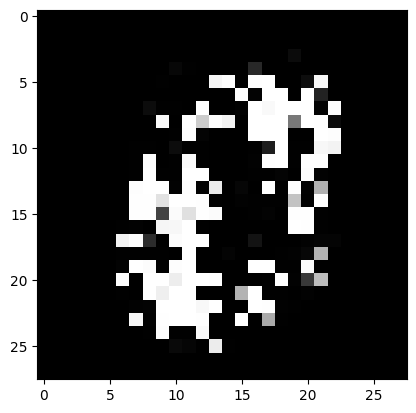

Epoch: 69050
loss_g: 0.021184692159295082 	loss_d: 5.484131336212158
Epoch: 69100
loss_g: 0.021219581365585327 	loss_d: 5.189125061035156
Epoch: 69150
loss_g: 0.021182265132665634 	loss_d: 5.7616143226623535
Epoch: 69200
loss_g: 0.0211435928940773 	loss_d: 5.255842685699463
Epoch: 69250
loss_g: 0.021143794059753418 	loss_d: 5.061364650726318
Epoch: 69300
loss_g: 0.021127209067344666 	loss_d: 5.366811275482178
Epoch: 69350
loss_g: 0.021127482876181602 	loss_d: 4.67294979095459
Epoch: 69400
loss_g: 0.021148689091205597 	loss_d: 5.497228622436523
Epoch: 69450
loss_g: 0.021106421947479248 	loss_d: 4.8201093673706055
Epoch: 69500
loss_g: 0.021130520850419998 	loss_d: 5.193221569061279


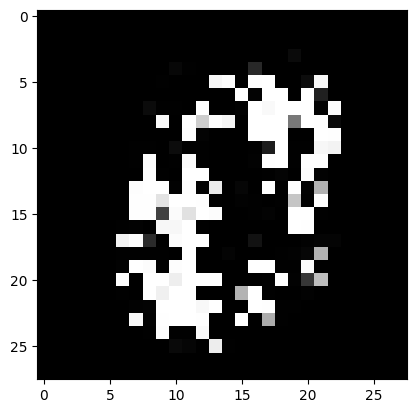

Epoch: 69550
loss_g: 0.02113298885524273 	loss_d: 5.198582649230957
Epoch: 69600
loss_g: 0.021099595353007317 	loss_d: 5.000597953796387
Epoch: 69650
loss_g: 0.021105121821165085 	loss_d: 5.737499713897705
Epoch: 69700
loss_g: 0.02112702652812004 	loss_d: 5.37809419631958
Epoch: 69750
loss_g: 0.021095193922519684 	loss_d: 5.2886738777160645
Epoch: 69800
loss_g: 0.021084511652588844 	loss_d: 4.9693403244018555
Epoch: 69850
loss_g: 0.02108025923371315 	loss_d: 5.249252796173096
Epoch: 69900
loss_g: 0.021084096282720566 	loss_d: 5.293631076812744
Epoch: 69950
loss_g: 0.021087631583213806 	loss_d: 5.055015563964844
Epoch: 70000
loss_g: 0.021063875406980515 	loss_d: 5.271536350250244


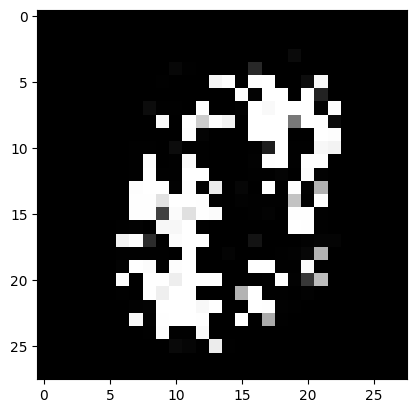

Epoch: 70050
loss_g: 0.0210612453520298 	loss_d: 5.422471523284912
Epoch: 70100
loss_g: 0.021063990890979767 	loss_d: 5.031269550323486
Epoch: 70150
loss_g: 0.02104712836444378 	loss_d: 5.2473883628845215
Epoch: 70200
loss_g: 0.021064285188913345 	loss_d: 4.9258809089660645
Epoch: 70250
loss_g: 0.021036488935351372 	loss_d: 5.4841203689575195
Epoch: 70300
loss_g: 0.021064722910523415 	loss_d: 5.016548156738281
Epoch: 70350
loss_g: 0.021019134670495987 	loss_d: 5.204477787017822
Epoch: 70400
loss_g: 0.021032264456152916 	loss_d: 5.136081695556641
Epoch: 70450
loss_g: 0.021025747060775757 	loss_d: 5.153566360473633
Epoch: 70500
loss_g: 0.020990557968616486 	loss_d: 5.164309024810791


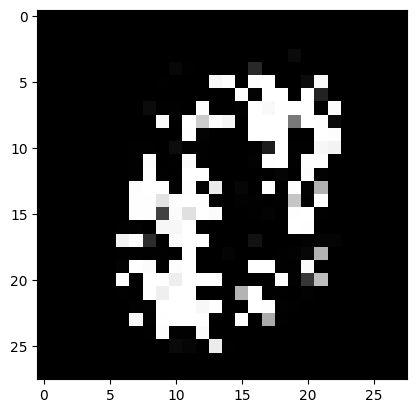

Epoch: 70550
loss_g: 0.02100900560617447 	loss_d: 5.230661392211914
Epoch: 70600
loss_g: 0.021007174625992775 	loss_d: 4.974278926849365
Epoch: 70650
loss_g: 0.021028561517596245 	loss_d: 5.3801703453063965
Epoch: 70700
loss_g: 0.020989054813981056 	loss_d: 5.2829742431640625
Epoch: 70750
loss_g: 0.020965885370969772 	loss_d: 5.386164665222168
Epoch: 70800
loss_g: 0.020991668105125427 	loss_d: 5.268199920654297
Epoch: 70850
loss_g: 0.02099343203008175 	loss_d: 5.41473913192749
Epoch: 70900
loss_g: 0.020960820838809013 	loss_d: 5.292869567871094
Epoch: 70950
loss_g: 0.020966824144124985 	loss_d: 5.035577774047852
Epoch: 71000
loss_g: 0.02096627838909626 	loss_d: 5.212820529937744


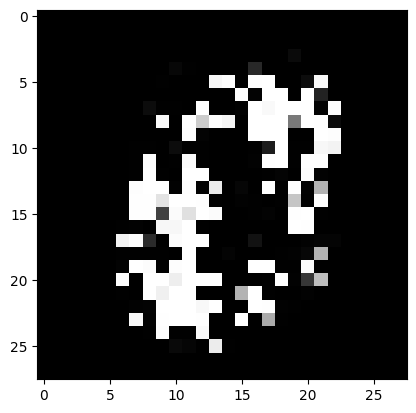

Epoch: 71050
loss_g: 0.020953034982085228 	loss_d: 5.079513072967529
Epoch: 71100
loss_g: 0.02094333805143833 	loss_d: 5.579989910125732
Epoch: 71150
loss_g: 0.02093147300183773 	loss_d: 4.99583101272583
Epoch: 71200
loss_g: 0.020932728424668312 	loss_d: 5.303919315338135
Epoch: 71250
loss_g: 0.020920157432556152 	loss_d: 5.2646331787109375
Epoch: 71300
loss_g: 0.020940525457262993 	loss_d: 5.711256980895996
Epoch: 71350
loss_g: 0.02089378796517849 	loss_d: 5.501087188720703
Epoch: 71400
loss_g: 0.020906586199998856 	loss_d: 5.19114351272583
Epoch: 71450
loss_g: 0.02093423344194889 	loss_d: 5.496104717254639
Epoch: 71500
loss_g: 0.020907871425151825 	loss_d: 5.200607776641846


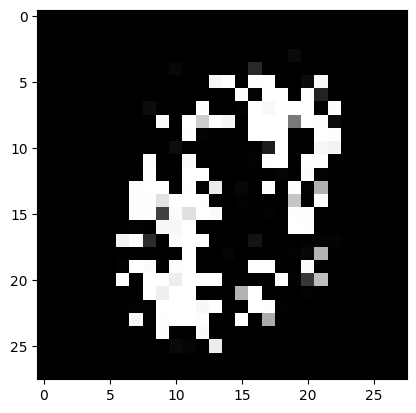

Epoch: 71550
loss_g: 0.020910726860165596 	loss_d: 5.773550033569336
Epoch: 71600
loss_g: 0.02090783789753914 	loss_d: 5.269505977630615
Epoch: 71650
loss_g: 0.02087683230638504 	loss_d: 5.072673797607422
Epoch: 71700
loss_g: 0.020908240228891373 	loss_d: 5.378013610839844
Epoch: 71750
loss_g: 0.020918402820825577 	loss_d: 4.684150695800781
Epoch: 71800
loss_g: 0.020904945209622383 	loss_d: 5.507591247558594
Epoch: 71850
loss_g: 0.02087346464395523 	loss_d: 4.832056045532227
Epoch: 71900
loss_g: 0.02090655267238617 	loss_d: 5.204696178436279
Epoch: 71950
loss_g: 0.020887870341539383 	loss_d: 5.211872577667236
Epoch: 72000
loss_g: 0.020821599289774895 	loss_d: 5.012572288513184


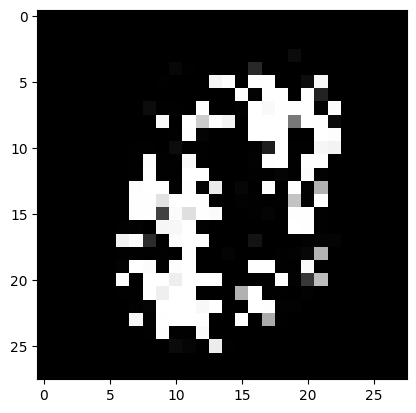

Epoch: 72050
loss_g: 0.020864997059106827 	loss_d: 5.748454570770264
Epoch: 72100
loss_g: 0.020848343148827553 	loss_d: 5.389045238494873
Epoch: 72150
loss_g: 0.02085850201547146 	loss_d: 5.301050186157227
Epoch: 72200
loss_g: 0.020841138437390327 	loss_d: 4.982011795043945
Epoch: 72250
loss_g: 0.0208341833204031 	loss_d: 5.26223087310791
Epoch: 72300
loss_g: 0.020845556631684303 	loss_d: 5.304825782775879
Epoch: 72350
loss_g: 0.02082773670554161 	loss_d: 5.066493511199951
Epoch: 72400
loss_g: 0.02080543152987957 	loss_d: 5.283302307128906
Epoch: 72450
loss_g: 0.0208111759275198 	loss_d: 5.432680130004883
Epoch: 72500
loss_g: 0.020827528089284897 	loss_d: 5.041526794433594


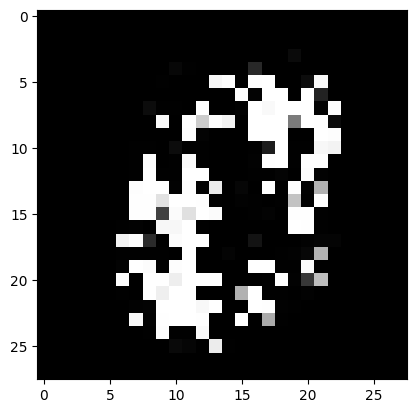

Epoch: 72550
loss_g: 0.02081865817308426 	loss_d: 5.259039878845215
Epoch: 72600
loss_g: 0.02079813741147518 	loss_d: 4.937556266784668
Epoch: 72650
loss_g: 0.020806116983294487 	loss_d: 5.495151996612549
Epoch: 72700
loss_g: 0.020818300545215607 	loss_d: 5.028949737548828
Epoch: 72750
loss_g: 0.02080477960407734 	loss_d: 5.215090274810791
Epoch: 72800
loss_g: 0.02078082598745823 	loss_d: 5.145283222198486
Epoch: 72850
loss_g: 0.0207892507314682 	loss_d: 5.164681434631348
Epoch: 72900
loss_g: 0.02080743946135044 	loss_d: 5.1758270263671875
Epoch: 72950
loss_g: 0.020819904282689095 	loss_d: 5.24282169342041
Epoch: 73000
loss_g: 0.020768364891409874 	loss_d: 4.986330032348633


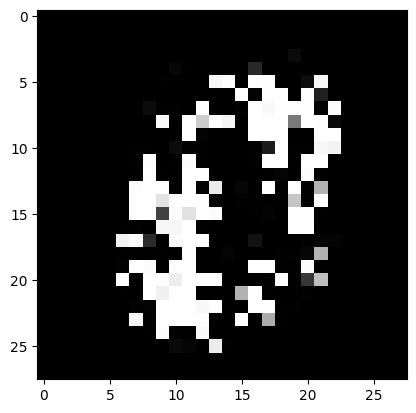

Epoch: 73050
loss_g: 0.020747380331158638 	loss_d: 5.39236307144165
Epoch: 73100
loss_g: 0.020744681358337402 	loss_d: 5.294854640960693
Epoch: 73150
loss_g: 0.020774563774466515 	loss_d: 5.396905899047852
Epoch: 73200
loss_g: 0.02073594741523266 	loss_d: 5.279540061950684
Epoch: 73250
loss_g: 0.020743321627378464 	loss_d: 5.423493385314941
Epoch: 73300
loss_g: 0.020750073716044426 	loss_d: 5.303009986877441
Epoch: 73350
loss_g: 0.020771993324160576 	loss_d: 5.046868324279785
Epoch: 73400
loss_g: 0.020741086453199387 	loss_d: 5.22327184677124
Epoch: 73450
loss_g: 0.02074488438665867 	loss_d: 5.090987205505371
Epoch: 73500
loss_g: 0.02076912857592106 	loss_d: 5.589624881744385


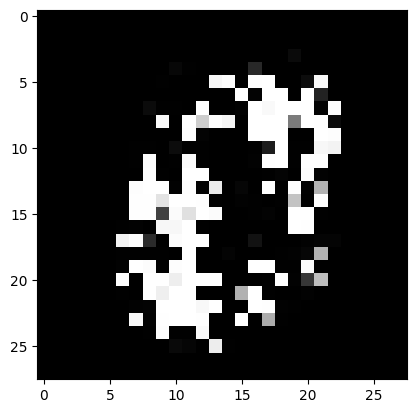

Epoch: 73550
loss_g: 0.02071022056043148 	loss_d: 5.005634307861328
Epoch: 73600
loss_g: 0.02073247916996479 	loss_d: 5.3146257400512695
Epoch: 73650
loss_g: 0.020723525434732437 	loss_d: 5.2737226486206055
Epoch: 73700
loss_g: 0.02071644924581051 	loss_d: 5.722748756408691
Epoch: 73750
loss_g: 0.020704980939626694 	loss_d: 5.511683464050293
Epoch: 73800
loss_g: 0.020713822916150093 	loss_d: 5.20103645324707
Epoch: 73850
loss_g: 0.02071106806397438 	loss_d: 5.506876468658447
Epoch: 73900
loss_g: 0.020692253485322 	loss_d: 5.2096848487854
Epoch: 73950
loss_g: 0.02070094458758831 	loss_d: 5.7843756675720215
Epoch: 74000
loss_g: 0.020698286592960358 	loss_d: 5.278972625732422


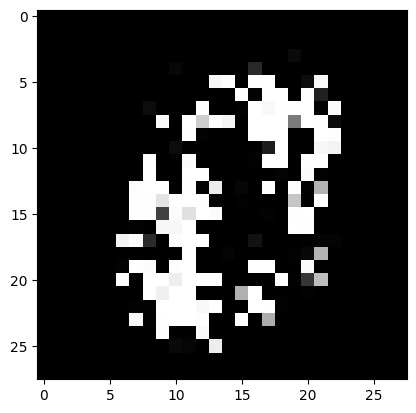

Epoch: 74050
loss_g: 0.020708899945020676 	loss_d: 5.083098888397217
Epoch: 74100
loss_g: 0.02070111222565174 	loss_d: 5.387894630432129
Epoch: 74150
loss_g: 0.02067285031080246 	loss_d: 4.694809913635254
Epoch: 74200
loss_g: 0.02068779431283474 	loss_d: 5.518701553344727
Epoch: 74250
loss_g: 0.020687097683548927 	loss_d: 4.8401007652282715
Epoch: 74300
loss_g: 0.020665474236011505 	loss_d: 5.214587211608887
Epoch: 74350
loss_g: 0.0206871647387743 	loss_d: 5.220139980316162
Epoch: 74400
loss_g: 0.020709799602627754 	loss_d: 5.022294521331787
Epoch: 74450
loss_g: 0.02065352350473404 	loss_d: 5.758484840393066
Epoch: 74500
loss_g: 0.02065325155854225 	loss_d: 5.399125099182129


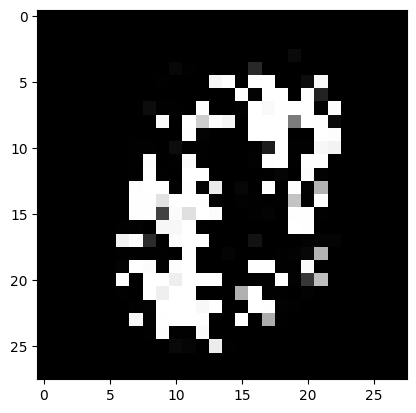

Epoch: 74550
loss_g: 0.020653601735830307 	loss_d: 5.309892654418945
Epoch: 74600
loss_g: 0.02065674029290676 	loss_d: 4.990362167358398
Epoch: 74650
loss_g: 0.020637286826968193 	loss_d: 5.271688938140869
Epoch: 74700
loss_g: 0.020646747201681137 	loss_d: 5.314137935638428
Epoch: 74750
loss_g: 0.020650234073400497 	loss_d: 5.0746684074401855
Epoch: 74800
loss_g: 0.02065301313996315 	loss_d: 5.292290687561035
Epoch: 74850
loss_g: 0.02066083438694477 	loss_d: 5.44287109375
Epoch: 74900
loss_g: 0.02062048390507698 	loss_d: 5.051673889160156
Epoch: 74950
loss_g: 0.02061360329389572 	loss_d: 5.26702880859375
Epoch: 75000
loss_g: 0.020625773817300797 	loss_d: 4.9469218254089355


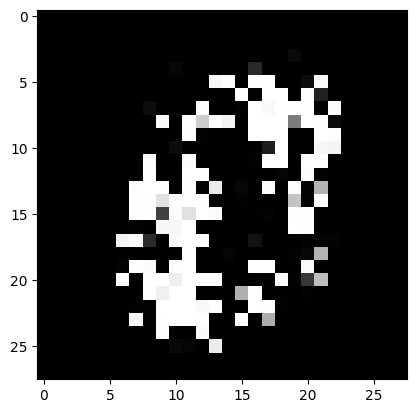

Epoch: 75050
loss_g: 0.020622147247195244 	loss_d: 5.505764484405518
Epoch: 75100
loss_g: 0.020594550296664238 	loss_d: 5.036949157714844
Epoch: 75150
loss_g: 0.020598934963345528 	loss_d: 5.225264549255371
Epoch: 75200
loss_g: 0.020606108009815216 	loss_d: 5.154364109039307
Epoch: 75250
loss_g: 0.020583540201187134 	loss_d: 5.17274808883667
Epoch: 75300
loss_g: 0.020587487146258354 	loss_d: 5.185121059417725
Epoch: 75350
loss_g: 0.020605148747563362 	loss_d: 5.251555919647217
Epoch: 75400
loss_g: 0.020587000995874405 	loss_d: 4.994045734405518
Epoch: 75450
loss_g: 0.02060335874557495 	loss_d: 5.4014129638671875
Epoch: 75500
loss_g: 0.020586123690009117 	loss_d: 5.303337097167969


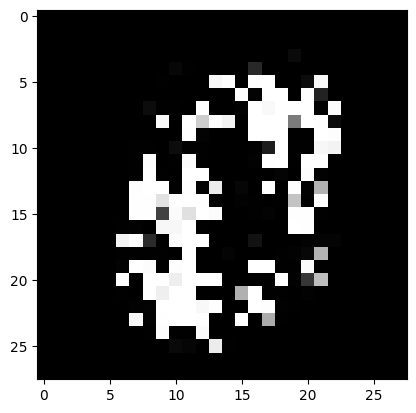

Epoch: 75550
loss_g: 0.020569700747728348 	loss_d: 5.405343532562256
Epoch: 75600
loss_g: 0.020534923300147057 	loss_d: 5.286167144775391
Epoch: 75650
loss_g: 0.020567402243614197 	loss_d: 5.431987285614014
Epoch: 75700
loss_g: 0.020578008145093918 	loss_d: 5.312256336212158
Epoch: 75750
loss_g: 0.02059120126068592 	loss_d: 5.055567741394043
Epoch: 75800
loss_g: 0.020562531426548958 	loss_d: 5.2322797775268555
Epoch: 75850
loss_g: 0.02058076113462448 	loss_d: 5.097782135009766
Epoch: 75900
loss_g: 0.020541124045848846 	loss_d: 5.599981307983398
Epoch: 75950
loss_g: 0.020550893619656563 	loss_d: 5.014833450317383
Epoch: 76000
loss_g: 0.020567307248711586 	loss_d: 5.322961807250977


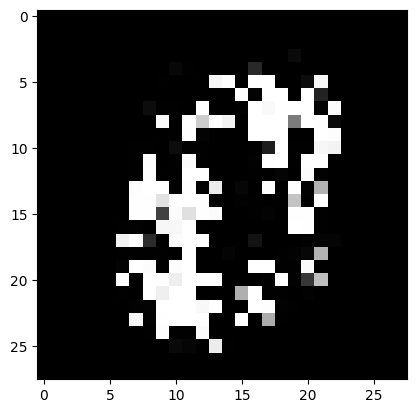

Epoch: 76050
loss_g: 0.020568260923027992 	loss_d: 5.282442569732666
Epoch: 76100
loss_g: 0.020556194707751274 	loss_d: 5.730220794677734
Epoch: 76150
loss_g: 0.02055395022034645 	loss_d: 5.519034385681152
Epoch: 76200
loss_g: 0.020541539415717125 	loss_d: 5.208858013153076
Epoch: 76250
loss_g: 0.020516734570264816 	loss_d: 5.514692783355713
Epoch: 76300
loss_g: 0.02053883671760559 	loss_d: 5.219016075134277
Epoch: 76350
loss_g: 0.020529797300696373 	loss_d: 5.793034076690674
Epoch: 76400
loss_g: 0.020505284890532494 	loss_d: 5.285949230194092
Epoch: 76450
loss_g: 0.020518042147159576 	loss_d: 5.092345237731934
Epoch: 76500
loss_g: 0.02051561512053013 	loss_d: 5.3966546058654785


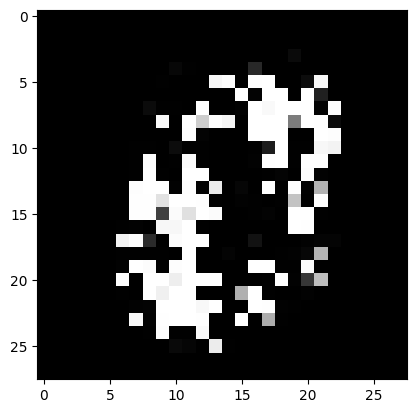

Epoch: 76550
loss_g: 0.02052403800189495 	loss_d: 4.700629711151123
Epoch: 76600
loss_g: 0.020504536107182503 	loss_d: 5.525444507598877
Epoch: 76650
loss_g: 0.020471863448619843 	loss_d: 4.848021030426025
Epoch: 76700
loss_g: 0.02050972171127796 	loss_d: 5.22216796875
Epoch: 76750
loss_g: 0.020501531660556793 	loss_d: 5.229290962219238
Epoch: 76800
loss_g: 0.020491747185587883 	loss_d: 5.0313920974731445
Epoch: 76850
loss_g: 0.02049664966762066 	loss_d: 5.767775535583496
Epoch: 76900
loss_g: 0.020468609407544136 	loss_d: 5.40654182434082
Epoch: 76950
loss_g: 0.02046995609998703 	loss_d: 5.316822528839111
Epoch: 77000
loss_g: 0.02049367129802704 	loss_d: 4.99738883972168


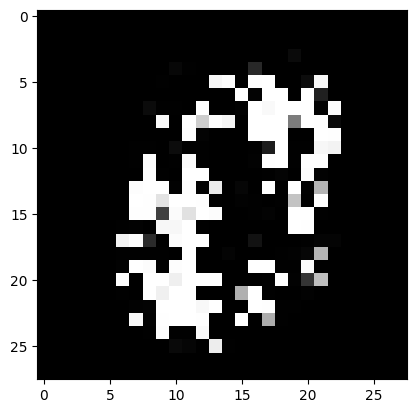

Epoch: 77050
loss_g: 0.020467674359679222 	loss_d: 5.279128551483154
Epoch: 77100
loss_g: 0.02045913226902485 	loss_d: 5.321840286254883
Epoch: 77150
loss_g: 0.02046266570687294 	loss_d: 5.084060192108154
Epoch: 77200
loss_g: 0.020475873723626137 	loss_d: 5.299524307250977
Epoch: 77250
loss_g: 0.020455291494727135 	loss_d: 5.449608325958252
Epoch: 77300
loss_g: 0.020475396886467934 	loss_d: 5.059991359710693
Epoch: 77350
loss_g: 0.020492160692811012 	loss_d: 5.275662899017334
Epoch: 77400
loss_g: 0.02045002020895481 	loss_d: 4.95546293258667
Epoch: 77450
loss_g: 0.020469656214118004 	loss_d: 5.512892723083496
Epoch: 77500
loss_g: 0.020461875945329666 	loss_d: 5.044926643371582


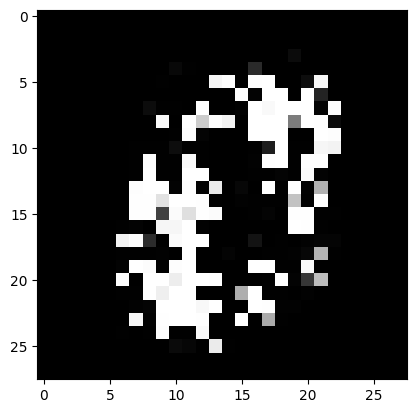

Epoch: 77550
loss_g: 0.020459238439798355 	loss_d: 5.234535217285156
Epoch: 77600
loss_g: 0.020416902378201485 	loss_d: 5.162660121917725
Epoch: 77650
loss_g: 0.020434321835637093 	loss_d: 5.179753303527832
Epoch: 77700
loss_g: 0.020449137315154076 	loss_d: 5.1926984786987305
Epoch: 77750
loss_g: 0.020425647497177124 	loss_d: 5.2590460777282715
Epoch: 77800
loss_g: 0.02043554000556469 	loss_d: 5.001704216003418
Epoch: 77850
loss_g: 0.02039700746536255 	loss_d: 5.40886116027832
Epoch: 77900
loss_g: 0.020435146987438202 	loss_d: 5.309981346130371
Epoch: 77950
loss_g: 0.020453214645385742 	loss_d: 5.413596153259277
Epoch: 78000
loss_g: 0.020429397001862526 	loss_d: 5.293637752532959


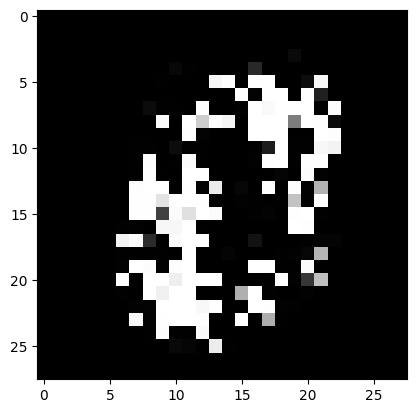

Epoch: 78050
loss_g: 0.020412134006619453 	loss_d: 5.440350532531738
Epoch: 78100
loss_g: 0.020434575155377388 	loss_d: 5.319439888000488
Epoch: 78150
loss_g: 0.020418213680386543 	loss_d: 5.062299728393555
Epoch: 78200
loss_g: 0.020400898531079292 	loss_d: 5.23953104019165
Epoch: 78250
loss_g: 0.020445533096790314 	loss_d: 5.104485511779785
Epoch: 78300
loss_g: 0.02041034586727619 	loss_d: 5.6045966148376465
Epoch: 78350
loss_g: 0.02039826288819313 	loss_d: 5.022299766540527
Epoch: 78400
loss_g: 0.020396096631884575 	loss_d: 5.331121921539307
Epoch: 78450
loss_g: 0.020411672070622444 	loss_d: 5.288654804229736
Epoch: 78500
loss_g: 0.020401889458298683 	loss_d: 5.736782550811768


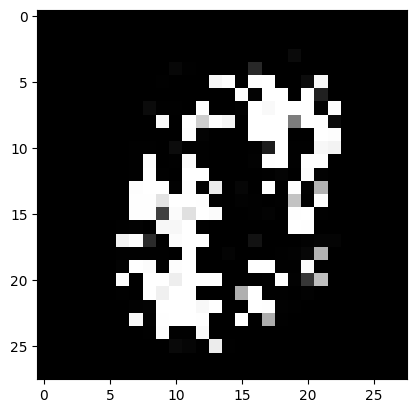

Epoch: 78550
loss_g: 0.02040955051779747 	loss_d: 5.526888370513916
Epoch: 78600
loss_g: 0.020411157980561256 	loss_d: 5.215862274169922
Epoch: 78650
loss_g: 0.020420826971530914 	loss_d: 5.521067142486572
Epoch: 78700
loss_g: 0.020405711606144905 	loss_d: 5.225736618041992
Epoch: 78750
loss_g: 0.02037174254655838 	loss_d: 5.799185276031494
Epoch: 78800
loss_g: 0.020385146141052246 	loss_d: 5.292418479919434
Epoch: 78850
loss_g: 0.020374663174152374 	loss_d: 5.098507404327393
Epoch: 78900
loss_g: 0.020365631207823753 	loss_d: 5.4019389152526855
Epoch: 78950
loss_g: 0.020384306088089943 	loss_d: 4.710375785827637
Epoch: 79000
loss_g: 0.020383410155773163 	loss_d: 5.532585620880127


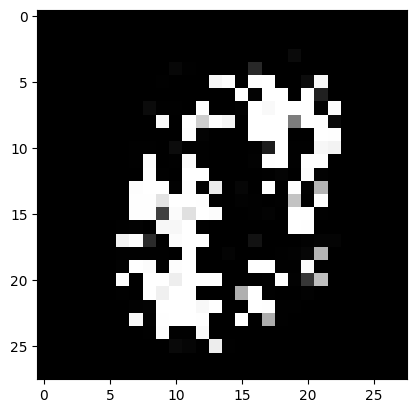

Epoch: 79050
loss_g: 0.02039647474884987 	loss_d: 4.855501651763916
Epoch: 79100
loss_g: 0.02038780227303505 	loss_d: 5.229578971862793
Epoch: 79150
loss_g: 0.020381374284625053 	loss_d: 5.235660076141357
Epoch: 79200
loss_g: 0.020360451191663742 	loss_d: 5.03502893447876
Epoch: 79250
loss_g: 0.020367490127682686 	loss_d: 5.773826599121094
Epoch: 79300
loss_g: 0.020355166867375374 	loss_d: 5.41445255279541
Epoch: 79350
loss_g: 0.02034125104546547 	loss_d: 5.324366092681885
Epoch: 79400
loss_g: 0.02036317251622677 	loss_d: 5.006855010986328
Epoch: 79450
loss_g: 0.02033466286957264 	loss_d: 5.285486698150635
Epoch: 79500
loss_g: 0.02033734694123268 	loss_d: 5.329756736755371


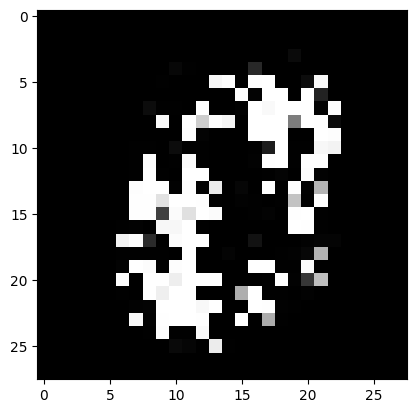

Epoch: 79550
loss_g: 0.020365837961435318 	loss_d: 5.089895248413086
Epoch: 79600
loss_g: 0.02034321241080761 	loss_d: 5.305075645446777
Epoch: 79650
loss_g: 0.02035629376769066 	loss_d: 5.455175876617432
Epoch: 79700
loss_g: 0.020322777330875397 	loss_d: 5.065424919128418
Epoch: 79750
loss_g: 0.020364731550216675 	loss_d: 5.2824015617370605
Epoch: 79800
loss_g: 0.02032947912812233 	loss_d: 4.961988925933838
Epoch: 79850
loss_g: 0.020317766815423965 	loss_d: 5.519749641418457
Epoch: 79900
loss_g: 0.020341604948043823 	loss_d: 5.050957679748535
Epoch: 79950
loss_g: 0.0203351229429245 	loss_d: 5.238402843475342
Epoch: 80000
loss_g: 0.02033645287156105 	loss_d: 5.167956352233887


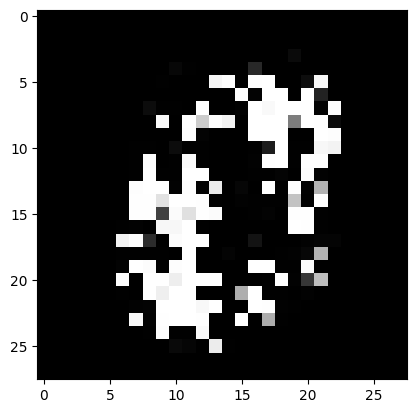

Epoch: 80050
loss_g: 0.020325612276792526 	loss_d: 5.187585830688477
Epoch: 80100
loss_g: 0.02031177468597889 	loss_d: 5.198322772979736
Epoch: 80150
loss_g: 0.02031061425805092 	loss_d: 5.263553142547607
Epoch: 80200
loss_g: 0.02031642384827137 	loss_d: 5.008185863494873
Epoch: 80250
loss_g: 0.02031196467578411 	loss_d: 5.414117813110352
Epoch: 80300
loss_g: 0.020331773906946182 	loss_d: 5.316580295562744
Epoch: 80350
loss_g: 0.02027984894812107 	loss_d: 5.42017936706543
Epoch: 80400
loss_g: 0.02029852382838726 	loss_d: 5.300107002258301
Epoch: 80450
loss_g: 0.020313918590545654 	loss_d: 5.446643829345703
Epoch: 80500
loss_g: 0.02028713747859001 	loss_d: 5.326034069061279


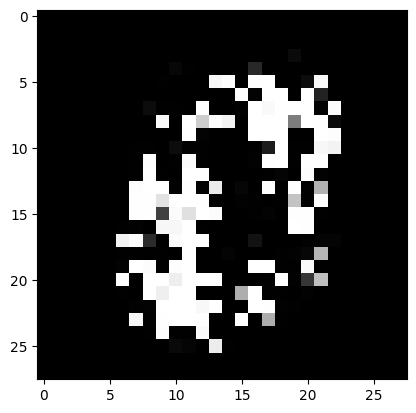

Epoch: 80550
loss_g: 0.020297778770327568 	loss_d: 5.068411350250244
Epoch: 80600
loss_g: 0.02029437944293022 	loss_d: 5.242798805236816
Epoch: 80650
loss_g: 0.020298218354582787 	loss_d: 5.111423969268799
Epoch: 80700
loss_g: 0.020270155742764473 	loss_d: 5.611279487609863
Epoch: 80750
loss_g: 0.02027188241481781 	loss_d: 5.027396202087402
Epoch: 80800
loss_g: 0.02031659707427025 	loss_d: 5.3359880447387695
Epoch: 80850
loss_g: 0.0202785637229681 	loss_d: 5.294196128845215
Epoch: 80900
loss_g: 0.020288418978452682 	loss_d: 5.744268417358398
Epoch: 80950
loss_g: 0.02031358703970909 	loss_d: 5.532001495361328
Epoch: 81000
loss_g: 0.020274588838219643 	loss_d: 5.2209577560424805


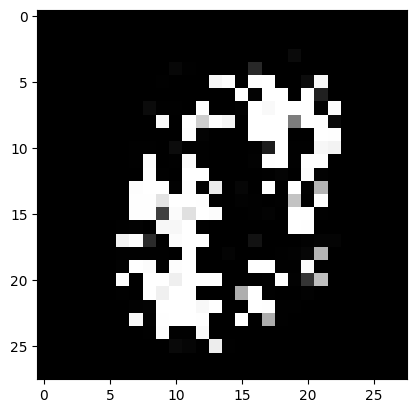

Epoch: 81050
loss_g: 0.02027078904211521 	loss_d: 5.526077747344971
Epoch: 81100
loss_g: 0.020292978733778 	loss_d: 5.231786727905273
Epoch: 81150
loss_g: 0.020272271707654 	loss_d: 5.804297924041748
Epoch: 81200
loss_g: 0.020269479602575302 	loss_d: 5.299388408660889
Epoch: 81250
loss_g: 0.020256077870726585 	loss_d: 5.103760242462158
Epoch: 81300
loss_g: 0.020293021574616432 	loss_d: 5.408577919006348
Epoch: 81350
loss_g: 0.020266372710466385 	loss_d: 4.714601516723633
Epoch: 81400
loss_g: 0.020266225561499596 	loss_d: 5.536425590515137
Epoch: 81450
loss_g: 0.02026548981666565 	loss_d: 4.861584186553955
Epoch: 81500
loss_g: 0.020253820344805717 	loss_d: 5.2352824211120605


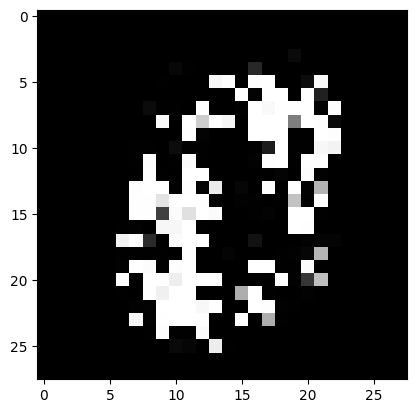

Epoch: 81550
loss_g: 0.02025493048131466 	loss_d: 5.2403340339660645
Epoch: 81600
loss_g: 0.020240072160959244 	loss_d: 5.042385578155518
Epoch: 81650
loss_g: 0.020233498886227608 	loss_d: 5.779457092285156
Epoch: 81700
loss_g: 0.02028205804526806 	loss_d: 5.418567657470703
Epoch: 81750
loss_g: 0.020237207412719727 	loss_d: 5.329400062561035
Epoch: 81800
loss_g: 0.02024000510573387 	loss_d: 5.011693477630615
Epoch: 81850
loss_g: 0.020244283601641655 	loss_d: 5.290423393249512
Epoch: 81900
loss_g: 0.020255498588085175 	loss_d: 5.333133220672607
Epoch: 81950
loss_g: 0.020226888358592987 	loss_d: 5.0944695472717285
Epoch: 82000
loss_g: 0.020216211676597595 	loss_d: 5.310175895690918


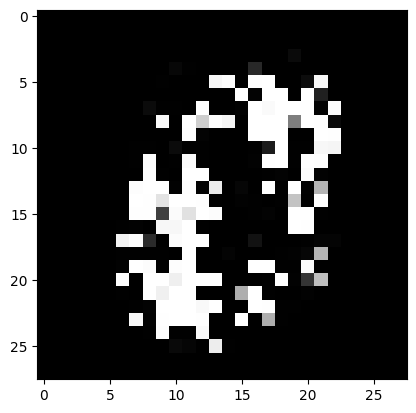

Epoch: 82050
loss_g: 0.020237021148204803 	loss_d: 5.462602138519287
Epoch: 82100
loss_g: 0.02024221606552601 	loss_d: 5.069692611694336
Epoch: 82150
loss_g: 0.020249895751476288 	loss_d: 5.286837100982666
Epoch: 82200
loss_g: 0.020228572189807892 	loss_d: 4.967236518859863
Epoch: 82250
loss_g: 0.020236052572727203 	loss_d: 5.524511814117432
Epoch: 82300
loss_g: 0.020244307816028595 	loss_d: 5.055753231048584
Epoch: 82350
loss_g: 0.020225543528795242 	loss_d: 5.245143890380859
Epoch: 82400
loss_g: 0.020230306312441826 	loss_d: 5.173754692077637
Epoch: 82450
loss_g: 0.020230574533343315 	loss_d: 5.1919684410095215
Epoch: 82500
loss_g: 0.020210226997733116 	loss_d: 5.204986095428467


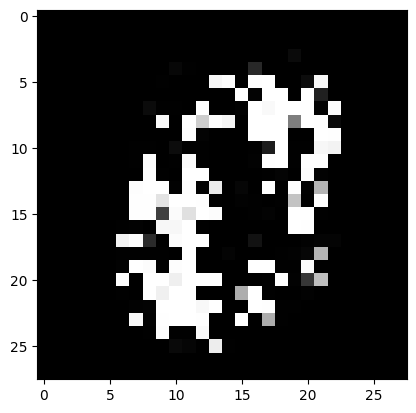

Epoch: 82550
loss_g: 0.020212393254041672 	loss_d: 5.269864082336426
Epoch: 82600
loss_g: 0.020184000954031944 	loss_d: 5.012695789337158
Epoch: 82650
loss_g: 0.02023531123995781 	loss_d: 5.4180426597595215
Epoch: 82700
loss_g: 0.02020872011780739 	loss_d: 5.321226596832275
Epoch: 82750
loss_g: 0.020216060802340508 	loss_d: 5.424524307250977
Epoch: 82800
loss_g: 0.02022985741496086 	loss_d: 5.306273460388184
Epoch: 82850
loss_g: 0.020201992243528366 	loss_d: 5.450860977172852
Epoch: 82900
loss_g: 0.020213382318615913 	loss_d: 5.329820156097412
Epoch: 82950
loss_g: 0.02021547593176365 	loss_d: 5.075033664703369
Epoch: 83000
loss_g: 0.020172052085399628 	loss_d: 5.249824523925781


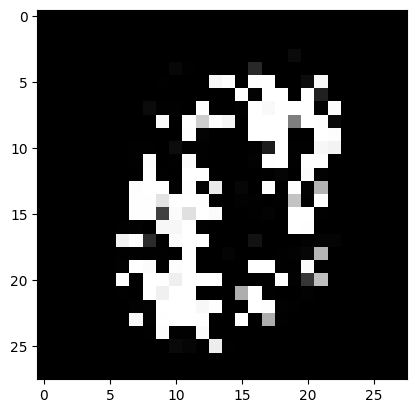

Epoch: 83050
loss_g: 0.020214781165122986 	loss_d: 5.117024898529053
Epoch: 83100
loss_g: 0.020200185477733612 	loss_d: 5.616278171539307
Epoch: 83150
loss_g: 0.02017798461019993 	loss_d: 5.030876636505127
Epoch: 83200
loss_g: 0.02018660306930542 	loss_d: 5.342564105987549
Epoch: 83250
loss_g: 0.020223181694746017 	loss_d: 5.299015522003174
Epoch: 83300
loss_g: 0.020203210413455963 	loss_d: 5.747206687927246
Epoch: 83350
loss_g: 0.02018674835562706 	loss_d: 5.536981105804443
Epoch: 83400
loss_g: 0.020183216780424118 	loss_d: 5.226940631866455
Epoch: 83450
loss_g: 0.020184997469186783 	loss_d: 5.531468868255615
Epoch: 83500
loss_g: 0.020185455679893494 	loss_d: 5.234738826751709


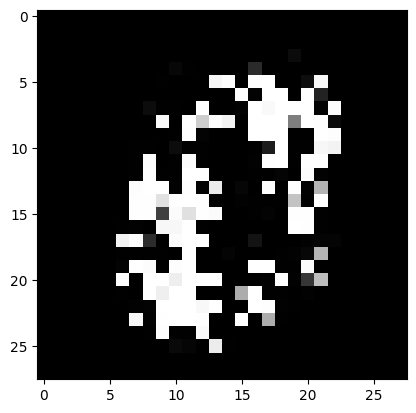

Epoch: 83550
loss_g: 0.020177340134978294 	loss_d: 5.809201240539551
Epoch: 83600
loss_g: 0.020165512338280678 	loss_d: 5.303830146789551
Epoch: 83650
loss_g: 0.020178260281682014 	loss_d: 5.108086585998535
Epoch: 83700
loss_g: 0.020186929032206535 	loss_d: 5.412774085998535
Epoch: 83750
loss_g: 0.02016037330031395 	loss_d: 4.718820095062256
Epoch: 83800
loss_g: 0.02016732469201088 	loss_d: 5.542255401611328
Epoch: 83850
loss_g: 0.02017013542354107 	loss_d: 4.864821910858154
Epoch: 83900
loss_g: 0.020185159519314766 	loss_d: 5.239657402038574
Epoch: 83950
loss_g: 0.02016584388911724 	loss_d: 5.245843410491943
Epoch: 84000
loss_g: 0.020157083868980408 	loss_d: 5.046633243560791


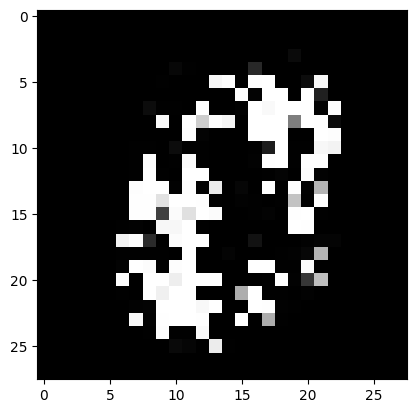

Epoch: 84050
loss_g: 0.020138325169682503 	loss_d: 5.783050537109375
Epoch: 84100
loss_g: 0.02015099674463272 	loss_d: 5.425297737121582
Epoch: 84150
loss_g: 0.02015594206750393 	loss_d: 5.333700656890869
Epoch: 84200
loss_g: 0.020180096849799156 	loss_d: 5.014334201812744
Epoch: 84250
loss_g: 0.020149026066064835 	loss_d: 5.295322895050049
Epoch: 84300
loss_g: 0.020144924521446228 	loss_d: 5.336516857147217
Epoch: 84350
loss_g: 0.02013939619064331 	loss_d: 5.0993828773498535
Epoch: 84400
loss_g: 0.02014784701168537 	loss_d: 5.314298629760742
Epoch: 84450
loss_g: 0.02012617141008377 	loss_d: 5.466485977172852
Epoch: 84500
loss_g: 0.020135965198278427 	loss_d: 5.07574462890625


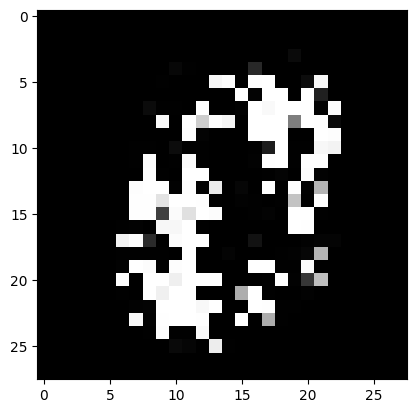

Epoch: 84550
loss_g: 0.020145360380411148 	loss_d: 5.291734218597412
Epoch: 84600
loss_g: 0.020117081701755524 	loss_d: 4.971031188964844
Epoch: 84650
loss_g: 0.02014172077178955 	loss_d: 5.529603958129883
Epoch: 84700
loss_g: 0.02015742100775242 	loss_d: 5.0612945556640625
Epoch: 84750
loss_g: 0.02014441415667534 	loss_d: 5.247504234313965
Epoch: 84800
loss_g: 0.020134517922997475 	loss_d: 5.177964210510254
Epoch: 84850
loss_g: 0.02013171836733818 	loss_d: 5.19600248336792
Epoch: 84900
loss_g: 0.020140260457992554 	loss_d: 5.206855297088623
Epoch: 84950
loss_g: 0.02015102095901966 	loss_d: 5.274291038513184
Epoch: 85000
loss_g: 0.020114345476031303 	loss_d: 5.017107009887695


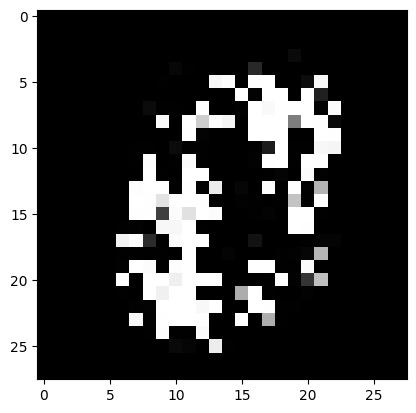

Epoch: 85050
loss_g: 0.020161155611276627 	loss_d: 5.421995639801025
Epoch: 85100
loss_g: 0.020135266706347466 	loss_d: 5.324233055114746
Epoch: 85150
loss_g: 0.0201506856828928 	loss_d: 5.428526878356934
Epoch: 85200
loss_g: 0.02011282369494438 	loss_d: 5.308930397033691
Epoch: 85250
loss_g: 0.02014157734811306 	loss_d: 5.454123497009277
Epoch: 85300
loss_g: 0.02011064440011978 	loss_d: 5.335239887237549
Epoch: 85350
loss_g: 0.020116686820983887 	loss_d: 5.078516483306885
Epoch: 85400
loss_g: 0.020119670778512955 	loss_d: 5.252866268157959
Epoch: 85450
loss_g: 0.02012227289378643 	loss_d: 5.119772434234619
Epoch: 85500
loss_g: 0.02012685500085354 	loss_d: 5.6188507080078125


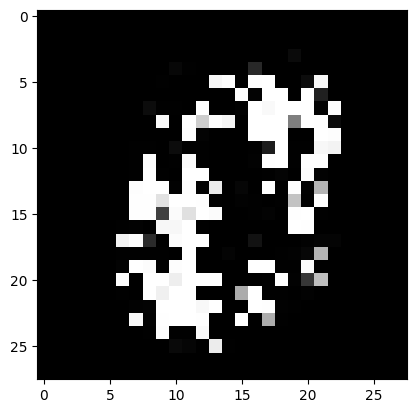

Epoch: 85550
loss_g: 0.02009938657283783 	loss_d: 5.034672737121582
Epoch: 85600
loss_g: 0.020108835771679878 	loss_d: 5.345732688903809
Epoch: 85650
loss_g: 0.020110798999667168 	loss_d: 5.3031005859375
Epoch: 85700
loss_g: 0.020119711756706238 	loss_d: 5.751979351043701
Epoch: 85750
loss_g: 0.020127858966588974 	loss_d: 5.54157829284668
Epoch: 85800
loss_g: 0.02010536380112171 	loss_d: 5.231315612792969
Epoch: 85850
loss_g: 0.020090550184249878 	loss_d: 5.535844802856445
Epoch: 85900
loss_g: 0.020105862990021706 	loss_d: 5.240205764770508
Epoch: 85950
loss_g: 0.020106257870793343 	loss_d: 5.81322717666626
Epoch: 86000
loss_g: 0.020091677084565163 	loss_d: 5.307337284088135


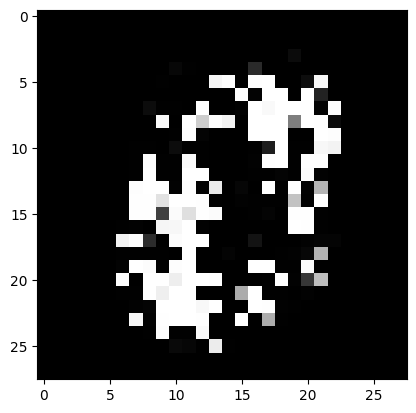

Epoch: 86050
loss_g: 0.020098473876714706 	loss_d: 5.111533164978027
Epoch: 86100
loss_g: 0.020121559500694275 	loss_d: 5.416829586029053
Epoch: 86150
loss_g: 0.020100098103284836 	loss_d: 4.7226128578186035
Epoch: 86200
loss_g: 0.020090743899345398 	loss_d: 5.545537948608398
Epoch: 86250
loss_g: 0.020109262317419052 	loss_d: 4.868185043334961
Epoch: 86300
loss_g: 0.020098645240068436 	loss_d: 5.241943836212158
Epoch: 86350
loss_g: 0.02010299079120159 	loss_d: 5.249168872833252
Epoch: 86400
loss_g: 0.02007114887237549 	loss_d: 5.049550533294678
Epoch: 86450
loss_g: 0.02009587548673153 	loss_d: 5.785478115081787
Epoch: 86500
loss_g: 0.020082931965589523 	loss_d: 5.4265546798706055


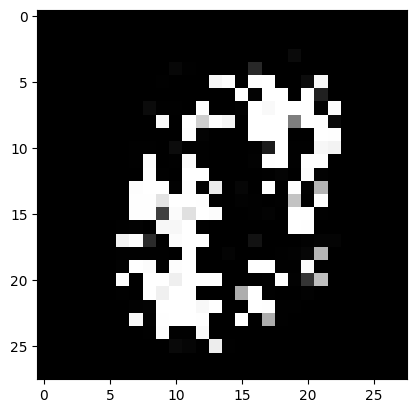

Epoch: 86550
loss_g: 0.020072640851140022 	loss_d: 5.337568283081055
Epoch: 86600
loss_g: 0.020082440227270126 	loss_d: 5.017975807189941
Epoch: 86650
loss_g: 0.020084800198674202 	loss_d: 5.299675464630127
Epoch: 86700
loss_g: 0.020089587196707726 	loss_d: 5.340566635131836
Epoch: 86750
loss_g: 0.020054088905453682 	loss_d: 5.105082035064697
Epoch: 86800
loss_g: 0.020086640492081642 	loss_d: 5.3190717697143555
Epoch: 86850
loss_g: 0.020071014761924744 	loss_d: 5.469210147857666
Epoch: 86900
loss_g: 0.020062198862433434 	loss_d: 5.077373504638672
Epoch: 86950
loss_g: 0.020079264417290688 	loss_d: 5.29472017288208
Epoch: 87000
loss_g: 0.020071638748049736 	loss_d: 4.9739155769348145


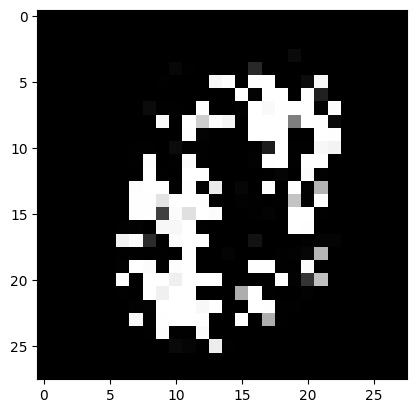

Epoch: 87050
loss_g: 0.020067811012268066 	loss_d: 5.531697750091553
Epoch: 87100
loss_g: 0.02009112387895584 	loss_d: 5.064032077789307
Epoch: 87150
loss_g: 0.020079566165804863 	loss_d: 5.250436782836914
Epoch: 87200
loss_g: 0.020075758919119835 	loss_d: 5.1807427406311035
Epoch: 87250
loss_g: 0.020089006051421165 	loss_d: 5.200358867645264
Epoch: 87300
loss_g: 0.020077470690011978 	loss_d: 5.209648132324219
Epoch: 87350
loss_g: 0.020035406574606895 	loss_d: 5.27746057510376
Epoch: 87400
loss_g: 0.020077748224139214 	loss_d: 5.021384239196777
Epoch: 87450
loss_g: 0.020056378096342087 	loss_d: 5.426218032836914
Epoch: 87500
loss_g: 0.02006731554865837 	loss_d: 5.3286590576171875


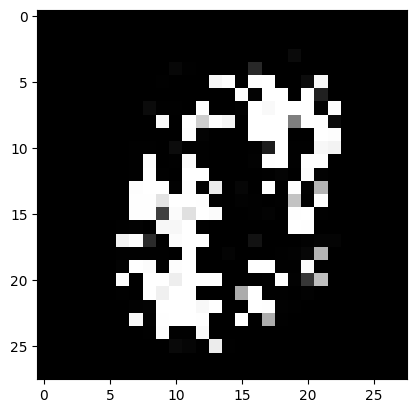

Epoch: 87550
loss_g: 0.020079996436834335 	loss_d: 5.430417060852051
Epoch: 87600
loss_g: 0.020072173327207565 	loss_d: 5.313100814819336
Epoch: 87650
loss_g: 0.020076705142855644 	loss_d: 5.4553375244140625
Epoch: 87700
loss_g: 0.020072348415851593 	loss_d: 5.33776330947876
Epoch: 87750
loss_g: 0.02005567029118538 	loss_d: 5.0813188552856445
Epoch: 87800
loss_g: 0.02005014382302761 	loss_d: 5.257615566253662
Epoch: 87850
loss_g: 0.0200545322149992 	loss_d: 5.123286724090576
Epoch: 87900
loss_g: 0.02004963345825672 	loss_d: 5.623241901397705
Epoch: 87950
loss_g: 0.02006889134645462 	loss_d: 5.039638996124268
Epoch: 88000
loss_g: 0.02003997564315796 	loss_d: 5.348449230194092


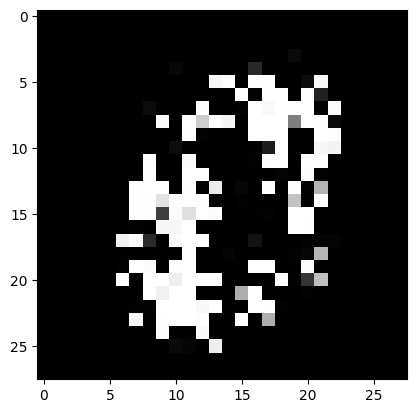

Epoch: 88050
loss_g: 0.020032664760947227 	loss_d: 5.306491851806641
Epoch: 88100
loss_g: 0.02007772959768772 	loss_d: 5.753760814666748
Epoch: 88150
loss_g: 0.02001584880053997 	loss_d: 5.5450639724731445
Epoch: 88200
loss_g: 0.02004234306514263 	loss_d: 5.2326436042785645
Epoch: 88250
loss_g: 0.02006617560982704 	loss_d: 5.540147304534912
Epoch: 88300
loss_g: 0.020048459991812706 	loss_d: 5.244387149810791
Epoch: 88350
loss_g: 0.020030280575156212 	loss_d: 5.817471027374268
Epoch: 88400
loss_g: 0.020044291391968727 	loss_d: 5.309126377105713
Epoch: 88450
loss_g: 0.02005055919289589 	loss_d: 5.114945411682129
Epoch: 88500
loss_g: 0.020045015960931778 	loss_d: 5.418828964233398


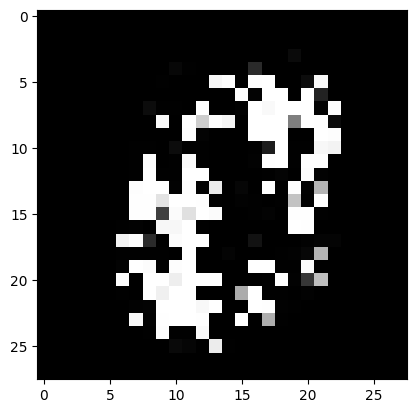

Epoch: 88550
loss_g: 0.020029162988066673 	loss_d: 4.726320266723633
Epoch: 88600
loss_g: 0.020030323415994644 	loss_d: 5.550185680389404
Epoch: 88650
loss_g: 0.020005125552415848 	loss_d: 4.872159481048584
Epoch: 88700
loss_g: 0.02006431110203266 	loss_d: 5.243927478790283
Epoch: 88750
loss_g: 0.0200223196297884 	loss_d: 5.251400470733643
Epoch: 88800
loss_g: 0.020045869052410126 	loss_d: 5.052670001983643
Epoch: 88850
loss_g: 0.020036697387695312 	loss_d: 5.789455890655518
Epoch: 88900
loss_g: 0.020027203485369682 	loss_d: 5.4326395988464355
Epoch: 88950
loss_g: 0.020000703632831573 	loss_d: 5.34084415435791
Epoch: 89000
loss_g: 0.020012885332107544 	loss_d: 5.021355152130127


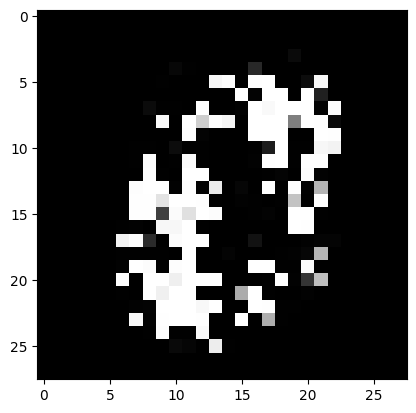

Epoch: 89050
loss_g: 0.020000776275992393 	loss_d: 5.301192283630371
Epoch: 89100
loss_g: 0.020060131326317787 	loss_d: 5.345039367675781
Epoch: 89150
loss_g: 0.020056800916790962 	loss_d: 5.106575012207031
Epoch: 89200
loss_g: 0.01999504491686821 	loss_d: 5.3211517333984375
Epoch: 89250
loss_g: 0.02004135400056839 	loss_d: 5.473829746246338
Epoch: 89300
loss_g: 0.02005903422832489 	loss_d: 5.080234050750732
Epoch: 89350
loss_g: 0.020013226196169853 	loss_d: 5.299417972564697
Epoch: 89400
loss_g: 0.0200020931661129 	loss_d: 4.977518558502197
Epoch: 89450
loss_g: 0.020018700510263443 	loss_d: 5.53521728515625


KeyboardInterrupt: 

In [5]:
lr = 0.01
k = 5
epochs = 250000

generator = Generator().to(device)
disciminator = Discriminator().to(device)

optimizer_gen = torch.optim.SGD(generator.parameters(), lr=lr)
optimizer_dis = torch.optim.SGD(disciminator.parameters(), lr=lr)

criterion_gen = Generator_loss()
criterion_dis = Discriminator_loss()

scheduler_gen = torch.optim.lr_scheduler.StepLR(optimizer_gen, step_size=25, gamma=0.998)
scheduler_dis = torch.optim.lr_scheduler.StepLR(optimizer_dis, step_size=25, gamma=0.998)

train_models(disciminator, criterion_dis, optimizer_dis, scheduler_dis, generator, criterion_gen, optimizer_gen, scheduler_gen, epochs, train_loader, k, batch_size)